# Stock Price Prediction using Graph Convolutional Layer. The model uses GCN and MLP. The input graphs were created using Pearson, Spearman, and Kendal Tau correlations/coefficients. Also, another graph is created based on financial news articles

# For the sake of making execution easier (and at once), I have kept multiple approaches in the same file. Because I initially tried separately and brought them together, some code might be a bit redundant/repeating. I may or may not have cleaned enough.

# Import Libraries

In [1]:
# import libraries
import os
import pandas as pd
import math

In [2]:
# Import Libraries for Graph, GNN, and GCN
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.layer import DeepGraphCNN
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

In [3]:
# Machine Learnig related library Imports
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow import keras

In [4]:
# If we want to drop NAN column or row wise
drop_cols_with_na = 1
drop_rows_with_na = 1

# Dataset: Use Fortune 30 companies as the paper used

In [5]:
df_s = pd.DataFrame();
data_file = "per-day-fortune-30-company-stock-price-data.csv";
df_s = pd.read_csv("./data/" + data_file, low_memory = False);
df_s.head()

,Date,AAPL,ABC,AMZN,ANTM,BA,BAC,CAH,COST,CVS,...,PCAR,PSX,T,UNH,UNP,VZ,WBA,WFC,WMT,XOM
0,2017-01-03 00:00:00,29.037500,82.610001,37.683498,NaN,156.970001,22.530001,74.480003,159.729996,80.349998,...,43.546665,86.790001,32.492447,161.449997,102.519997,54.580002,82.959999,56.000000,68.660004,90.889999
1,2017-01-04 00:00:00,29.004999,84.660004,37.859001,NaN,158.619995,22.950001,75.629997,159.759995,79.750000,...,44.146667,87.260002,32.303623,161.910004,103.139999,54.520000,82.980003,56.049999,69.059998,89.889999
2,2017-01-05 00:00:00,29.152500,83.680000,39.022499,NaN,158.710007,22.680000,74.500000,162.910004,81.419998,...,43.426666,86.739998,32.212990,162.179993,102.129997,54.639999,83.029999,55.180000,69.209999,88.550003
3,2017-01-06 00:00:00,29.477501,84.800003,39.799500,NaN,159.100006,22.680000,75.330002,162.830002,82.199997,...,43.919998,85.400002,31.208460,162.410004,103.190002,53.259998,83.099998,55.040001,68.260002,88.500000
4,2017-01-09 00:00:00,29.747499,85.480003,39.846001,NaN,158.320007,22.549999,74.760002,160.970001,81.699997,...,43.380001,84.019997,30.815710,161.949997,102.419998,52.680000,82.550003,54.240002,68.709999,87.040001


# Cure data such as replace missing/null values, use correct data type, sort by date (not really requured)

In [6]:
# convert Date field to be a Date Type
df_s["Date"] = df_s["Date"].astype('datetime64[ns]')

# Sort data by date although this is no longer needed as data already is sorted
#df_s = df_s.sort_values( by = ['Ticker','Date'], ascending = True )
df_s = df_s.sort_values( by = 'Date', ascending = True )
df_s.head()

,Date,AAPL,ABC,AMZN,ANTM,BA,BAC,CAH,COST,CVS,...,PCAR,PSX,T,UNH,UNP,VZ,WBA,WFC,WMT,XOM
0,2017-01-03,29.037500,82.610001,37.683498,NaN,156.970001,22.530001,74.480003,159.729996,80.349998,...,43.546665,86.790001,32.492447,161.449997,102.519997,54.580002,82.959999,56.000000,68.660004,90.889999
1,2017-01-04,29.004999,84.660004,37.859001,NaN,158.619995,22.950001,75.629997,159.759995,79.750000,...,44.146667,87.260002,32.303623,161.910004,103.139999,54.520000,82.980003,56.049999,69.059998,89.889999
2,2017-01-05,29.152500,83.680000,39.022499,NaN,158.710007,22.680000,74.500000,162.910004,81.419998,...,43.426666,86.739998,32.212990,162.179993,102.129997,54.639999,83.029999,55.180000,69.209999,88.550003
3,2017-01-06,29.477501,84.800003,39.799500,NaN,159.100006,22.680000,75.330002,162.830002,82.199997,...,43.919998,85.400002,31.208460,162.410004,103.190002,53.259998,83.099998,55.040001,68.260002,88.500000
4,2017-01-09,29.747499,85.480003,39.846001,NaN,158.320007,22.549999,74.760002,160.970001,81.699997,...,43.380001,84.019997,30.815710,161.949997,102.419998,52.680000,82.550003,54.240002,68.709999,87.040001


In [7]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
df_s_transpose = df_s

try:
  df_s_transpose = df_s_transpose.interpolate(inplace = False)
except:
  print("An exception occurred. Operation ignored")
  exit
    
df_s_transpose.isnull().values.any()
df_s_transpose[df_s_transpose.isna().any(axis = 1)]    

An exception occurred. Operation ignored


,Date,AAPL,ABC,AMZN,ANTM,BA,BAC,CAH,COST,CVS,...,PCAR,PSX,T,UNH,UNP,VZ,WBA,WFC,WMT,XOM
0,2017-01-03,29.037500,82.610001,37.683498,NaN,156.970001,22.530001,74.480003,159.729996,80.349998,...,43.546665,86.790001,32.492447,161.449997,102.519997,54.580002,82.959999,56.000000,68.660004,90.889999
1,2017-01-04,29.004999,84.660004,37.859001,NaN,158.619995,22.950001,75.629997,159.759995,79.750000,...,44.146667,87.260002,32.303623,161.910004,103.139999,54.520000,82.980003,56.049999,69.059998,89.889999
2,2017-01-05,29.152500,83.680000,39.022499,NaN,158.710007,22.680000,74.500000,162.910004,81.419998,...,43.426666,86.739998,32.212990,162.179993,102.129997,54.639999,83.029999,55.180000,69.209999,88.550003
3,2017-01-06,29.477501,84.800003,39.799500,NaN,159.100006,22.680000,75.330002,162.830002,82.199997,...,43.919998,85.400002,31.208460,162.410004,103.190002,53.259998,83.099998,55.040001,68.260002,88.500000
4,2017-01-09,29.747499,85.480003,39.846001,NaN,158.320007,22.549999,74.760002,160.970001,81.699997,...,43.380001,84.019997,30.815710,161.949997,102.419998,52.680000,82.550003,54.240002,68.709999,87.040001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,2019-12-23,71.000000,85.599998,89.650002,NaN,337.549988,35.169998,51.130001,293.309998,74.379997,...,53.033333,112.669998,29.509064,295.089996,179.419998,61.400002,58.570000,53.810001,119.029999,70.290001
749,2019-12-24,71.067497,85.419998,89.460503,NaN,333.000000,35.220001,51.290001,294.230011,74.510002,...,52.993332,113.199997,29.425982,294.540009,179.889999,61.279999,58.349998,53.820000,119.510002,70.019997
750,2019-12-26,72.477501,85.050003,93.438499,NaN,329.920013,35.520000,51.169998,295.730011,74.480003,...,53.006668,112.059998,29.577040,295.649994,180.809998,61.290001,58.900002,54.150002,119.519997,70.129997
751,2019-12-27,72.449997,84.910004,93.489998,NaN,330.140015,35.349998,51.500000,294.109985,74.400002,...,52.939999,110.599998,29.637463,295.970001,181.410004,61.529999,59.020000,53.919998,119.589996,69.889999


In [8]:
df_s_transpose = df_s

if drop_cols_with_na == 1:
    df_s_transpose = df_s_transpose.dropna(axis = 1);    
   
df_s_transpose, df_s_transpose.shape

(          Date       AAPL        ABC       AMZN          BA        BAC  \
 0   2017-01-03  29.037500  82.610001  37.683498  156.970001  22.530001   
 1   2017-01-04  29.004999  84.660004  37.859001  158.619995  22.950001   
 2   2017-01-05  29.152500  83.680000  39.022499  158.710007  22.680000   
 3   2017-01-06  29.477501  84.800003  39.799500  159.100006  22.680000   
 4   2017-01-09  29.747499  85.480003  39.846001  158.320007  22.549999   
 ..         ...        ...        ...        ...         ...        ...   
 748 2019-12-23  71.000000  85.599998  89.650002  337.549988  35.169998   
 749 2019-12-24  71.067497  85.419998  89.460503  333.000000  35.220001   
 750 2019-12-26  72.477501  85.050003  93.438499  329.920013  35.520000   
 751 2019-12-27  72.449997  84.910004  93.489998  330.140015  35.349998   
 752 2019-12-30  72.879997  83.639999  92.344498  326.399994  35.150002   
 
            CAH        COST        CVS         CVX  ...       PCAR         PSX  \
 0    74.480003 

In [9]:
df_s_transpose.isnull().values.any()
df_s_transpose[df_s_transpose.isna().any( axis = 1 )]

,Date,AAPL,ABC,AMZN,BA,BAC,CAH,COST,CVS,CVX,...,PCAR,PSX,T,UNH,UNP,VZ,WBA,WFC,WMT,XOM


In [10]:
# df_s_transpose.index = df_s_transpose['Date']
df_s_transpose.index = df_s_transpose.index.astype('datetime64[ns]')

# Pearson Correlation Coefficient

In [11]:
df_s_transpose_pearson = df_s_transpose.corr(method = 'pearson', numeric_only = True)
df_s_transpose_pearson

,AAPL,ABC,AMZN,BA,BAC,CAH,COST,CVS,CVX,F,...,PCAR,PSX,T,UNH,UNP,VZ,WBA,WFC,WMT,XOM
AAPL,1.000000,-0.036748,0.786106,0.692570,0.763609,-0.666770,0.863643,-0.342350,0.459125,-0.593845,...,0.427859,0.745233,-0.262982,0.760652,0.798973,0.676181,-0.658245,-0.197965,0.827489,-0.505612
ABC,-0.036748,1.000000,-0.127768,-0.126217,0.163579,0.466160,-0.130971,0.427752,0.029482,0.302385,...,0.154842,0.097029,0.358636,-0.055076,-0.178882,-0.252366,0.300615,0.574354,-0.079702,0.250188
AMZN,0.786106,-0.127768,1.000000,0.909833,0.739494,-0.876488,0.826927,-0.673998,0.601387,-0.721688,...,0.071989,0.690894,-0.677553,0.886126,0.929052,0.708967,-0.763988,-0.409286,0.765665,-0.457154
BA,0.692570,-0.126217,0.909833,1.000000,0.782307,-0.828416,0.699197,-0.661338,0.662725,-0.672301,...,0.103744,0.688694,-0.708575,0.886833,0.873865,0.653679,-0.707509,-0.328412,0.765026,-0.413556
BAC,0.763609,0.163579,0.739494,0.782307,1.000000,-0.523495,0.613895,-0.389465,0.670267,-0.347324,...,0.484901,0.804676,-0.315603,0.770331,0.727145,0.485319,-0.604695,0.127918,0.705303,-0.297798
CAH,-0.666770,0.466160,-0.876488,-0.828416,-0.523495,1.000000,-0.766108,0.746348,-0.539610,0.709460,...,0.059840,-0.558826,0.741128,-0.795163,-0.851249,-0.711528,0.791882,0.596125,-0.739558,0.523205
COST,0.863643,-0.130971,0.826927,0.699197,0.613895,-0.766108,1.000000,-0.553276,0.444068,-0.712750,...,0.317508,0.541579,-0.297706,0.695051,0.902083,0.864420,-0.766485,-0.473844,0.893336,-0.648205
CVS,-0.342350,0.427752,-0.673998,-0.661338,-0.389465,0.746348,-0.553276,1.000000,-0.440430,0.464550,...,0.017925,-0.225111,0.586122,-0.439705,-0.686060,-0.463266,0.850140,0.643467,-0.529032,0.449050
CVX,0.459125,0.029482,0.601387,0.662725,0.670267,-0.539610,0.444068,-0.440430,1.000000,-0.087233,...,0.293140,0.717509,-0.388580,0.594834,0.602565,0.419555,-0.535137,0.040413,0.482086,0.101968
F,-0.593845,0.302385,-0.721688,-0.672301,-0.347324,0.709460,-0.712750,0.464550,-0.087233,1.000000,...,0.115762,-0.306461,0.563575,-0.678168,-0.727356,-0.726151,0.467808,0.607512,-0.640430,0.652238


# Pearson Correlation Coefficient based Adjacency Graph Matrix

In [12]:
df_s_transpose_pearson[df_s_transpose_pearson >= 0.5] = 1
df_s_transpose_pearson[df_s_transpose_pearson < 0.5] = 0
df_s_transpose_pearson

,AAPL,ABC,AMZN,BA,BAC,CAH,COST,CVS,CVX,F,...,PCAR,PSX,T,UNH,UNP,VZ,WBA,WFC,WMT,XOM
AAPL,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
ABC,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AMZN,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
BA,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
BAC,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
CAH,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
COST,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
CVS,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
CVX,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [13]:
# make the diagonal element to be zero. No self loop
import numpy as np
np.fill_diagonal(df_s_transpose_pearson.values, 0)
df_s_transpose_pearson

,AAPL,ABC,AMZN,BA,BAC,CAH,COST,CVS,CVX,F,...,PCAR,PSX,T,UNH,UNP,VZ,WBA,WFC,WMT,XOM
AAPL,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
ABC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AMZN,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
BA,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
BAC,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
CAH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
COST,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
CVS,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
CVX,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


Create and visualize the Graphs

In [14]:
import networkx as nx
Graph_pearson = nx.Graph(df_s_transpose_pearson)

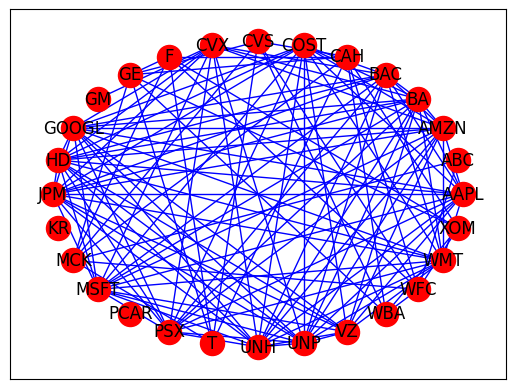

In [15]:
nx.draw_networkx(Graph_pearson, pos=nx.circular_layout(Graph_pearson), node_color='r', edge_color='b')

# Create GCN layer. Pearson

# Find all stocks = nodes

In [16]:
# improvement: make sure only stocks/nodes that are in the graph are taken
all_stock_nodes = df_s_transpose_pearson.index.to_list()
all_stock_nodes

['AAPL',
 'ABC',
 'AMZN',
 'BA',
 'BAC',
 'CAH',
 'COST',
 'CVS',
 'CVX',
 'F',
 'GE',
 'GM',
 'GOOGL',
 'HD',
 'JPM',
 'KR',
 'MCK',
 'MSFT',
 'PCAR',
 'PSX',
 'T',
 'UNH',
 'UNP',
 'VZ',
 'WBA',
 'WFC',
 'WMT',
 'XOM']

# Find all edges between nodes

In [17]:
source = [];
target = [];
edge_feature = [];

for aStock in all_stock_nodes:
    for anotherStock in all_stock_nodes:
        if df_s_transpose_pearson[aStock][anotherStock] > 0:
            #print(df_s_transpose_pearson[aStock][anotherStock])
            source.append(aStock)
            target.append(anotherStock)
            edge_feature.append(1)
            
source, target, edge_feature            

(['AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'ABC',
  'ABC',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'CAH',
  'CAH',
  'CAH',
  'CAH',
  'CAH',
  'CAH',
  'CAH',
  'CAH',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'CVS',
  'CVS',
  'CVS',
  'CVS',
  'CVS',
  'CVS',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'GE',
  'GE',
  'GE',
  'GE',
  'GE',
  'GE',
  'GE',
  'GM',
  'GOOGL',
  'GOOGL',


# variables to create stellar graph

In [18]:
# https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
pearson_edges = pd.DataFrame(
    {"source": source, "target": target}
)

pearson_edges_data = pd.DataFrame(
    {"source": source, "target": target, "edge_feature": edge_feature}
)


pearson_edges[:10]

,source,target
0,AAPL,AMZN
1,AAPL,BA
2,AAPL,BAC
3,AAPL,COST
4,AAPL,GOOGL
5,AAPL,HD
6,AAPL,JPM
7,AAPL,MSFT
8,AAPL,PSX
9,AAPL,UNH


#Graph with No Feature Data, No node data, only edges

pearson_graph = StellarGraph(edges = pearson_edges, node_type_default="corner", edge_type_default="line")
#pearson_graph = StellarGraph(nodes = all_stock_nodes, edges = pearson_edges)
#graph = sg.StellarGraph(all_stock_nodes, square_edges)
print(pearson_graph.info())

# have the time series data as part of the nodes

df_s_transpose

# Structure the Feature Matrix so that it can be passed to the GCN

In [19]:
df_s_transpose_feature = df_s_transpose.reset_index(drop = True, inplace = False)
# df_s_transpose_feature =  df_s_transpose_feature.values.tolist()
# print(df_s_transpose_feature.values.tolist())
#df_s_transpose_feature['WY'].values
df_s_transpose_feature['AAPL'].values

array([29.03750038, 29.00499916, 29.15250015, 29.47750092, 29.74749947,
       29.77750015, 29.9375    , 29.8125    , 29.76000023, 30.        ,
       29.99749947, 29.94499969, 30.        , 30.02000046, 29.99250031,
       30.46999931, 30.48500061, 30.48749924, 30.40749931, 30.33749962,
       32.1875    , 32.13249969, 32.27000046, 32.57249832, 32.88249969,
       33.00999832, 33.10499954, 33.02999878, 33.32249832, 33.75500107,
       33.87749863, 33.83750153, 33.93000031, 34.17499924, 34.27750015,
       34.13249969, 34.16500092, 34.23249817, 34.24750137, 34.94749832,
       34.74000168, 34.94499969, 34.83499908, 34.88000107, 34.75      ,
       34.66999817, 34.78499985, 34.79999924, 34.74750137, 35.11500168,
       35.17250061, 34.99750137, 35.36500168, 34.95999908, 35.35499954,
       35.22999954, 35.15999985, 35.22000122, 35.95000076, 36.02999878,
       35.98249817, 35.91500092, 35.92499924, 36.19250107, 36.00500107,
       35.91500092, 35.83499908, 35.79249954, 35.40750122, 35.45

In [20]:
node_Data = [];
for x in all_stock_nodes:
    node_Data.append( df_s_transpose_feature[x].values)
    
    
node_Data    

[array([29.03750038, 29.00499916, 29.15250015, 29.47750092, 29.74749947,
        29.77750015, 29.9375    , 29.8125    , 29.76000023, 30.        ,
        29.99749947, 29.94499969, 30.        , 30.02000046, 29.99250031,
        30.46999931, 30.48500061, 30.48749924, 30.40749931, 30.33749962,
        32.1875    , 32.13249969, 32.27000046, 32.57249832, 32.88249969,
        33.00999832, 33.10499954, 33.02999878, 33.32249832, 33.75500107,
        33.87749863, 33.83750153, 33.93000031, 34.17499924, 34.27750015,
        34.13249969, 34.16500092, 34.23249817, 34.24750137, 34.94749832,
        34.74000168, 34.94499969, 34.83499908, 34.88000107, 34.75      ,
        34.66999817, 34.78499985, 34.79999924, 34.74750137, 35.11500168,
        35.17250061, 34.99750137, 35.36500168, 34.95999908, 35.35499954,
        35.22999954, 35.15999985, 35.22000122, 35.95000076, 36.02999878,
        35.98249817, 35.91500092, 35.92499924, 36.19250107, 36.00500107,
        35.91500092, 35.83499908, 35.79249954, 35.4

In [21]:
pearson_graph_node_data = pd.DataFrame(node_Data, index = all_stock_nodes)
pearson_graph_node_data

,0,1,2,3,4,5,6,7,8,9,...,743,744,745,746,747,748,749,750,751,752
AAPL,29.037500,29.004999,29.152500,29.477501,29.747499,29.777500,29.937500,29.812500,29.760000,30.000000,...,69.964996,70.102501,69.934998,70.004997,69.860001,71.000000,71.067497,72.477501,72.449997,72.879997
ABC,82.610001,84.660004,83.680000,84.800003,85.480003,84.830002,81.529999,83.860001,84.620003,85.989998,...,85.959999,83.150002,83.550003,83.800003,85.669998,85.599998,85.419998,85.050003,84.910004,83.639999
AMZN,37.683498,37.859001,39.022499,39.799500,39.846001,39.794998,39.951000,40.681999,40.856998,40.486000,...,88.460503,89.532997,89.201500,89.613998,89.324997,89.650002,89.460503,93.438499,93.489998,92.344498
BA,156.970001,158.619995,158.710007,159.100006,158.320007,159.070007,159.399994,158.289993,158.830002,157.669998,...,327.000000,327.000000,330.679993,333.500000,328.000000,337.549988,333.000000,329.920013,330.140015,326.399994
BAC,22.530001,22.950001,22.680000,22.680000,22.549999,22.940001,23.070000,22.920000,23.010000,22.049999,...,34.700001,35.040001,35.110001,34.950001,34.959999,35.169998,35.220001,35.520000,35.349998,35.150002
CAH,74.480003,75.629997,74.500000,75.330002,74.760002,75.220001,73.720001,74.190002,75.000000,75.180000,...,53.700001,51.570000,51.099998,50.610001,51.799999,51.130001,51.290001,51.169998,51.500000,50.770000
COST,159.729996,159.759995,162.910004,162.830002,160.970001,161.660004,161.539993,161.869995,161.860001,163.809998,...,293.500000,295.549988,291.869995,293.709991,294.829987,293.309998,294.230011,295.730011,294.109985,295.140015
CVS,80.349998,79.750000,81.419998,82.199997,81.699997,82.669998,82.769997,82.599998,81.980003,83.919998,...,74.400002,73.349998,73.279999,74.099998,74.580002,74.379997,74.510002,74.480003,74.400002,73.699997
CVX,117.849998,117.820000,117.309998,116.839996,115.839996,114.959999,115.930000,116.160004,116.379997,116.279999,...,119.360001,118.599998,118.550003,118.129997,119.680000,120.330002,120.339996,120.599998,120.300003,119.849998
F,12.590000,13.170000,12.770000,12.760000,12.630000,12.850000,12.670000,12.590000,12.630000,12.610000,...,9.390000,9.390000,9.540000,9.410000,9.480000,9.440000,9.470000,9.450000,9.360000,9.250000


# Graph (stellar) with feature as part of Nodes

In [22]:
pearson_graph_with_node_features = StellarGraph(pearson_graph_node_data, edges = pearson_edges, node_type_default = "corner", edge_type_default = "line")
print(pearson_graph_with_node_features.info())

StellarGraph: Undirected multigraph
 Nodes: 28, Edges: 258

 Node types:
  corner: [28]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [258]
        Weights: all 1 (default)
        Features: none


In [23]:
# Generator
generator = FullBatchNodeGenerator(pearson_graph_with_node_features, method = "gcn") # , sparse = False
vars(generator)

Using GCN (local pooling) filters...


{'graph': <stellargraph.core.graph.StellarGraph at 0x1702016d910>,
 'name': None,
 'k': 1,
 'teleport_probability': 0.1,
 'method': 'gcn',
 'node_list': Index(['AAPL', 'ABC', 'AMZN', 'BA', 'BAC', 'CAH', 'COST', 'CVS', 'CVX', 'F',
        'GE', 'GM', 'GOOGL', 'HD', 'JPM', 'KR', 'MCK', 'MSFT', 'PCAR', 'PSX',
        'T', 'UNH', 'UNP', 'VZ', 'WBA', 'WFC', 'WMT', 'XOM'],
       dtype='object'),
 'Aadj': <28x28 sparse matrix of type '<class 'numpy.float64'>'
 	with 286 stored elements in Compressed Sparse Row format>,
 'use_sparse': True,
 'features': array([[ 29.0375,  29.005 ,  29.1525, ...,  72.4775,  72.45  ,  72.88  ],
        [ 82.61  ,  84.66  ,  83.68  , ...,  85.05  ,  84.91  ,  83.64  ],
        [ 37.6835,  37.859 ,  39.0225, ...,  93.4385,  93.49  ,  92.3445],
        ...,
        [ 56.    ,  56.05  ,  55.18  , ...,  54.15  ,  53.92  ,  53.6   ],
        [ 68.66  ,  69.06  ,  69.21  , ..., 119.52  , 119.59  , 119.4   ],
        [ 90.89  ,  89.89  ,  88.55  , ...,  70.13  ,  69.89

# Train Test Split

In [24]:
train_subjects, test_subjects = model_selection.train_test_split(
    pearson_graph_node_data #, train_size = 6, test_size = 4
)
# , train_size=6, test_size=None, stratify=pearson_graph_node_data

val_subjects, test_subjects_step_2 = model_selection.train_test_split(
    test_subjects #, test_size = 2
)

#, train_size = 500, test_size = None, stratify = test_subjects


train_subjects.shape, test_subjects.shape, val_subjects.shape, test_subjects_step_2.shape

((21, 753), (7, 753), (5, 753), (2, 753))

In [25]:
pearson_graph_node_data[:10]

,0,1,2,3,4,5,6,7,8,9,...,743,744,745,746,747,748,749,750,751,752
AAPL,29.037500,29.004999,29.152500,29.477501,29.747499,29.777500,29.937500,29.812500,29.760000,30.000000,...,69.964996,70.102501,69.934998,70.004997,69.860001,71.000000,71.067497,72.477501,72.449997,72.879997
ABC,82.610001,84.660004,83.680000,84.800003,85.480003,84.830002,81.529999,83.860001,84.620003,85.989998,...,85.959999,83.150002,83.550003,83.800003,85.669998,85.599998,85.419998,85.050003,84.910004,83.639999
AMZN,37.683498,37.859001,39.022499,39.799500,39.846001,39.794998,39.951000,40.681999,40.856998,40.486000,...,88.460503,89.532997,89.201500,89.613998,89.324997,89.650002,89.460503,93.438499,93.489998,92.344498
BA,156.970001,158.619995,158.710007,159.100006,158.320007,159.070007,159.399994,158.289993,158.830002,157.669998,...,327.000000,327.000000,330.679993,333.500000,328.000000,337.549988,333.000000,329.920013,330.140015,326.399994
BAC,22.530001,22.950001,22.680000,22.680000,22.549999,22.940001,23.070000,22.920000,23.010000,22.049999,...,34.700001,35.040001,35.110001,34.950001,34.959999,35.169998,35.220001,35.520000,35.349998,35.150002
CAH,74.480003,75.629997,74.500000,75.330002,74.760002,75.220001,73.720001,74.190002,75.000000,75.180000,...,53.700001,51.570000,51.099998,50.610001,51.799999,51.130001,51.290001,51.169998,51.500000,50.770000
COST,159.729996,159.759995,162.910004,162.830002,160.970001,161.660004,161.539993,161.869995,161.860001,163.809998,...,293.500000,295.549988,291.869995,293.709991,294.829987,293.309998,294.230011,295.730011,294.109985,295.140015
CVS,80.349998,79.750000,81.419998,82.199997,81.699997,82.669998,82.769997,82.599998,81.980003,83.919998,...,74.400002,73.349998,73.279999,74.099998,74.580002,74.379997,74.510002,74.480003,74.400002,73.699997
CVX,117.849998,117.820000,117.309998,116.839996,115.839996,114.959999,115.930000,116.160004,116.379997,116.279999,...,119.360001,118.599998,118.550003,118.129997,119.680000,120.330002,120.339996,120.599998,120.300003,119.849998
F,12.590000,13.170000,12.770000,12.760000,12.630000,12.850000,12.670000,12.590000,12.630000,12.610000,...,9.390000,9.390000,9.540000,9.410000,9.480000,9.440000,9.470000,9.450000,9.360000,9.250000


In [26]:
train_targets = train_subjects; 
val_targets = val_subjects; 
test_targets = test_subjects; 

In [27]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [28]:
# debug
train_subjects.index, 
train_targets[:2]

,0,1,2,3,4,5,6,7,8,9,...,743,744,745,746,747,748,749,750,751,752
BAC,22.530001,22.950001,22.68,22.680000,22.549999,22.940001,23.070000,22.920000,23.010000,22.049999,...,34.700001,35.040001,35.110001,34.950001,34.959999,35.169998,35.220001,35.520000,35.349998,35.150002
ABC,82.610001,84.660004,83.68,84.800003,85.480003,84.830002,81.529999,83.860001,84.620003,85.989998,...,85.959999,83.150002,83.550003,83.800003,85.669998,85.599998,85.419998,85.050003,84.910004,83.639999


#train data size
#it is not must to use a number like unit_count
unit_count = train_subjects.shape[0]
unit_count

# The Model for all of the approaches utilized in this file
# Model for Pearson, Spearman, Kendal Tau, Financial News Based prediction

In [29]:
layer_sizes = [32, 32]
activations = ["relu", "relu"]

gcn = GCN(layer_sizes = layer_sizes, activations = activations, generator = generator) #, dropout = 0.5
x_inp, x_out = gcn.in_out_tensors()

# MLP -- Regression
predictions = layers.Dense(units = train_targets.shape[1], activation = "linear")(x_out)
x_out, 
x_inp, x_out

([<KerasTensor: shape=(1, 28, 753) dtype=float32 (created by layer 'input_1')>,
  <KerasTensor: shape=(1, None) dtype=int32 (created by layer 'input_2')>,
  <KerasTensor: shape=(1, None, 2) dtype=int64 (created by layer 'input_3')>,
  <KerasTensor: shape=(1, None) dtype=float32 (created by layer 'input_4')>],
 <KerasTensor: shape=(1, None, 32) dtype=float32 (created by layer 'gather_indices')>)

hard coded size adjustments
test_subjects_adjusted = test_subjects[:len(val_subjects)]

val_gen = generator.flow(val_subjects.index, test_subjects_adjusted)
#train_gen[1], val_gen[1]

In [30]:
# Models

In [31]:
# loss functions: https://keras.io/api/losses/

model = Model(
    inputs = x_inp, outputs = predictions)

'''
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.1),
    loss=losses.MeanSquaredError(),
    metrics=["acc"],
)
'''

# REF: https://stackoverflow.com/questions/57301698/how-to-change-a-learning-rate-for-adam-in-tf2
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PolynomialDecay
train_steps = 1000
lr_fn = optimizers.schedules.PolynomialDecay(1e-3, train_steps, 1e-5, 2)


# https://keras.io/api/metrics/
model.compile(
    loss = 'mean_absolute_error', 
    optimizer = optimizers.Adam( lr_fn ),
    # metrics = ['mean_squared_error']
    metrics=['mse', 'mae', 'mape']
)

# mape: https://towardsdatascience.com/choosing-the-correct-error-metric-mape-vs-smape-5328dec53fac
model.compile( 
    loss = 'mean_absolute_error', 
    optimizer = optimizers.Adam(learning_rate = 0.015), 
    #optimizer = optimizers.Adam(lr_fn), 
    # metrics=['mean_squared_error']
    metrics=['mean_squared_error', 'mae', 'mape']
    # metrics=[
    #    metrics.MeanSquaredError(),
    #    metrics.AUC(),
    #]
)

In [32]:
len(x_inp), predictions.shape, print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(1, 28, 753)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(1, None, 2)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(1, None)]          0           []                               
                                                                                                  
 dropout (Dropout)              (1, 28, 753)         0           ['input_1[0][0]']                
                                                                                              

(4, TensorShape([1, None, 753]), None)

In [33]:
len(val_subjects)
test_subjects_ = test_subjects[:len(val_subjects)]

In [34]:
# hard coded size adjustments
test_subjects_ = test_subjects[:len(val_subjects)]

val_gen = generator.flow(val_subjects.index, test_subjects_)
#train_gen[1], val_gen[1]

train_gen[:1][:4]

In [35]:
# type(train_gen_data), type(data_valid), type(x_inp), type(x_out) 

In [36]:
# https://keras.io/api/callbacks/early_stopping/
from tensorflow.keras.callbacks import EarlyStopping

epochs_to_test = 1000
patience_to_test = 1000

es_callback = EarlyStopping(
    monitor = "val_mean_squared_error", 
    patience = patience_to_test, 
    restore_best_weights = True
)

data_valid = val_gen #[:1][:4];
train_gen_data = train_gen #[:1][:4];

history = model.fit( train_gen_data, epochs = epochs_to_test, validation_data = data_valid, verbose = 2,    
    # shuffling = true means shuffling the whole graph
    shuffle = False, callbacks = [es_callback],
)


Epoch 1/1000
1/1 - 1s - loss: 101.6600 - mean_squared_error: 16701.3535 - mae: 101.6600 - mape: 100.6315 - val_loss: 129.0589 - val_mean_squared_error: 29908.6758 - val_mae: 129.0589 - val_mape: 216.2603 - 1s/epoch - 1s/step
Epoch 2/1000
1/1 - 0s - loss: 119.2013 - mean_squared_error: 25386.2852 - mae: 119.2013 - mape: 201.0098 - val_loss: 35.8468 - val_mean_squared_error: 1870.7067 - val_mae: 35.8468 - val_mape: 55.3497 - 51ms/epoch - 51ms/step
Epoch 3/1000
1/1 - 0s - loss: 72.0097 - mean_squared_error: 10222.6699 - mae: 72.0097 - mape: 70.8721 - val_loss: 35.5926 - val_mean_squared_error: 1811.9568 - val_mae: 35.5926 - val_mape: 54.9575 - 67ms/epoch - 67ms/step
Epoch 4/1000
1/1 - 0s - loss: 71.6550 - mean_squared_error: 10094.5723 - mae: 71.6550 - mape: 70.6226 - val_loss: 54.4370 - val_mean_squared_error: 5333.3608 - val_mae: 54.4370 - val_mape: 89.9868 - 79ms/epoch - 79ms/step
Epoch 5/1000
1/1 - 0s - loss: 64.0169 - mean_squared_error: 7653.7441 - mae: 64.0169 - mape: 96.1159 - val

Epoch 38/1000
1/1 - 0s - loss: 45.9471 - mean_squared_error: 4763.1831 - mae: 45.9471 - mape: 66.4353 - val_loss: 36.2690 - val_mean_squared_error: 1798.2008 - val_mae: 36.2690 - val_mape: 60.9496 - 52ms/epoch - 52ms/step
Epoch 39/1000
1/1 - 0s - loss: 45.8287 - mean_squared_error: 4701.2842 - mae: 45.8287 - mape: 67.2134 - val_loss: 38.8055 - val_mean_squared_error: 2068.5684 - val_mae: 38.8055 - val_mape: 65.4128 - 60ms/epoch - 60ms/step
Epoch 40/1000
1/1 - 0s - loss: 45.8700 - mean_squared_error: 4553.2036 - mae: 45.8700 - mape: 70.0882 - val_loss: 37.9071 - val_mean_squared_error: 1979.3499 - val_mae: 37.9071 - val_mape: 63.8147 - 55ms/epoch - 55ms/step
Epoch 41/1000
1/1 - 0s - loss: 45.8568 - mean_squared_error: 4601.3525 - mae: 45.8568 - mape: 69.1812 - val_loss: 35.7902 - val_mean_squared_error: 1760.6641 - val_mae: 35.7902 - val_mape: 60.0990 - 51ms/epoch - 51ms/step
Epoch 42/1000
1/1 - 0s - loss: 45.8446 - mean_squared_error: 4725.4614 - mae: 45.8446 - mape: 66.9107 - val_loss

Epoch 75/1000
1/1 - 0s - loss: 45.4310 - mean_squared_error: 4709.7148 - mae: 45.4310 - mape: 65.9899 - val_loss: 37.3198 - val_mean_squared_error: 1875.4221 - val_mae: 37.3198 - val_mape: 63.1892 - 45ms/epoch - 45ms/step
Epoch 76/1000
1/1 - 0s - loss: 45.3919 - mean_squared_error: 4585.3267 - mae: 45.3919 - mape: 68.1110 - val_loss: 36.3136 - val_mean_squared_error: 1771.8562 - val_mae: 36.3136 - val_mape: 61.4220 - 49ms/epoch - 49ms/step
Epoch 77/1000
1/1 - 0s - loss: 45.3527 - mean_squared_error: 4640.7290 - mae: 45.3527 - mape: 66.9996 - val_loss: 36.1009 - val_mean_squared_error: 1757.7205 - val_mae: 36.1009 - val_mape: 61.0001 - 48ms/epoch - 48ms/step
Epoch 78/1000
1/1 - 0s - loss: 45.3281 - mean_squared_error: 4642.3843 - mae: 45.3281 - mape: 66.8374 - val_loss: 37.7848 - val_mean_squared_error: 1933.9534 - val_mae: 37.7848 - val_mape: 63.9915 - 46ms/epoch - 46ms/step
Epoch 79/1000
1/1 - 0s - loss: 45.3545 - mean_squared_error: 4536.5913 - mae: 45.3545 - mape: 68.7788 - val_loss

Epoch 112/1000
1/1 - 0s - loss: 45.0490 - mean_squared_error: 4552.4712 - mae: 45.0490 - mape: 67.4784 - val_loss: 36.4314 - val_mean_squared_error: 1809.2988 - val_mae: 36.4314 - val_mape: 61.7065 - 47ms/epoch - 47ms/step
Epoch 113/1000
1/1 - 0s - loss: 45.0332 - mean_squared_error: 4499.2944 - mae: 45.0332 - mape: 67.6257 - val_loss: 34.5971 - val_mean_squared_error: 1654.3285 - val_mae: 34.5971 - val_mape: 58.0631 - 48ms/epoch - 48ms/step
Epoch 114/1000
1/1 - 0s - loss: 45.0974 - mean_squared_error: 4619.1479 - mae: 45.0974 - mape: 65.4216 - val_loss: 35.2618 - val_mean_squared_error: 1674.4329 - val_mae: 35.2618 - val_mape: 59.8209 - 44ms/epoch - 44ms/step
Epoch 115/1000
1/1 - 0s - loss: 44.9581 - mean_squared_error: 4592.7197 - mae: 44.9581 - mape: 66.0956 - val_loss: 35.7089 - val_mean_squared_error: 1692.0215 - val_mae: 35.7089 - val_mape: 60.9379 - 49ms/epoch - 49ms/step
Epoch 116/1000
1/1 - 0s - loss: 44.9910 - mean_squared_error: 4592.7925 - mae: 44.9910 - mape: 66.6227 - val

Epoch 149/1000
1/1 - 0s - loss: 45.3129 - mean_squared_error: 4465.7163 - mae: 45.3129 - mape: 69.9565 - val_loss: 40.6989 - val_mean_squared_error: 2191.3254 - val_mae: 40.6989 - val_mape: 70.0268 - 49ms/epoch - 49ms/step
Epoch 150/1000
1/1 - 0s - loss: 45.5276 - mean_squared_error: 4489.5649 - mae: 45.5276 - mape: 70.9626 - val_loss: 34.9524 - val_mean_squared_error: 1583.5525 - val_mae: 34.9524 - val_mape: 59.3334 - 48ms/epoch - 48ms/step
Epoch 151/1000
1/1 - 0s - loss: 45.0583 - mean_squared_error: 4707.4741 - mae: 45.0583 - mape: 64.1370 - val_loss: 32.8898 - val_mean_squared_error: 1494.3832 - val_mae: 32.8898 - val_mape: 54.4681 - 45ms/epoch - 45ms/step
Epoch 152/1000
1/1 - 0s - loss: 45.4804 - mean_squared_error: 4814.1616 - mae: 45.4804 - mape: 62.2844 - val_loss: 41.5126 - val_mean_squared_error: 2469.7563 - val_mae: 41.5126 - val_mape: 69.7969 - 43ms/epoch - 43ms/step
Epoch 153/1000
1/1 - 0s - loss: 45.7067 - mean_squared_error: 4241.0444 - mae: 45.7067 - mape: 72.2986 - val

Epoch 186/1000
1/1 - 0s - loss: 44.9031 - mean_squared_error: 4546.0596 - mae: 44.9031 - mape: 67.0227 - val_loss: 35.4315 - val_mean_squared_error: 1737.5930 - val_mae: 35.4315 - val_mape: 59.9909 - 50ms/epoch - 50ms/step
Epoch 187/1000
1/1 - 0s - loss: 44.8402 - mean_squared_error: 4540.4331 - mae: 44.8402 - mape: 67.0288 - val_loss: 32.3195 - val_mean_squared_error: 1423.5135 - val_mae: 32.3195 - val_mape: 54.6001 - 55ms/epoch - 55ms/step
Epoch 188/1000
1/1 - 0s - loss: 44.9932 - mean_squared_error: 4775.5444 - mae: 44.9932 - mape: 63.6432 - val_loss: 39.5804 - val_mean_squared_error: 2088.9736 - val_mae: 39.5804 - val_mape: 67.7766 - 118ms/epoch - 118ms/step
Epoch 189/1000
1/1 - 0s - loss: 45.2620 - mean_squared_error: 4426.4634 - mae: 45.2620 - mape: 70.7836 - val_loss: 39.2766 - val_mean_squared_error: 2051.0659 - val_mae: 39.2766 - val_mape: 67.2080 - 76ms/epoch - 76ms/step
Epoch 190/1000
1/1 - 0s - loss: 45.2234 - mean_squared_error: 4443.0381 - mae: 45.2234 - mape: 70.2306 - v

Epoch 223/1000
1/1 - 0s - loss: 45.0077 - mean_squared_error: 4522.9248 - mae: 45.0077 - mape: 68.4580 - val_loss: 34.3242 - val_mean_squared_error: 1568.5898 - val_mae: 34.3242 - val_mape: 58.8646 - 70ms/epoch - 70ms/step
Epoch 224/1000
1/1 - 0s - loss: 45.1911 - mean_squared_error: 4691.8823 - mae: 45.1911 - mape: 66.6723 - val_loss: 34.0531 - val_mean_squared_error: 1548.6334 - val_mae: 34.0531 - val_mape: 58.2020 - 75ms/epoch - 75ms/step
Epoch 225/1000
1/1 - 0s - loss: 45.0765 - mean_squared_error: 4691.1221 - mae: 45.0765 - mape: 66.0857 - val_loss: 35.3208 - val_mean_squared_error: 1720.5779 - val_mae: 35.3208 - val_mape: 59.8677 - 64ms/epoch - 64ms/step
Epoch 226/1000
1/1 - 0s - loss: 44.9282 - mean_squared_error: 4550.8262 - mae: 44.9282 - mape: 67.1751 - val_loss: 36.1110 - val_mean_squared_error: 1849.8824 - val_mae: 36.1110 - val_mape: 60.8191 - 62ms/epoch - 62ms/step
Epoch 227/1000
1/1 - 0s - loss: 45.1138 - mean_squared_error: 4493.9048 - mae: 45.1138 - mape: 68.0327 - val

Epoch 260/1000
1/1 - 0s - loss: 45.1280 - mean_squared_error: 4372.0195 - mae: 45.1280 - mape: 68.4684 - val_loss: 41.5025 - val_mean_squared_error: 2320.5347 - val_mae: 41.5025 - val_mape: 70.0955 - 49ms/epoch - 49ms/step
Epoch 261/1000
1/1 - 0s - loss: 45.2825 - mean_squared_error: 4303.0068 - mae: 45.2825 - mape: 70.3255 - val_loss: 37.5414 - val_mean_squared_error: 1890.2432 - val_mae: 37.5414 - val_mape: 63.1344 - 47ms/epoch - 47ms/step
Epoch 262/1000
1/1 - 0s - loss: 44.9290 - mean_squared_error: 4495.9644 - mae: 44.9290 - mape: 66.0201 - val_loss: 32.4227 - val_mean_squared_error: 1434.3058 - val_mae: 32.4227 - val_mape: 53.8919 - 45ms/epoch - 45ms/step
Epoch 263/1000
1/1 - 0s - loss: 45.4225 - mean_squared_error: 4855.4565 - mae: 45.4225 - mape: 61.6066 - val_loss: 38.3019 - val_mean_squared_error: 1932.5394 - val_mae: 38.3019 - val_mape: 64.9630 - 49ms/epoch - 49ms/step
Epoch 264/1000
1/1 - 0s - loss: 45.0309 - mean_squared_error: 4490.6328 - mae: 45.0309 - mape: 67.2628 - val

Epoch 297/1000
1/1 - 0s - loss: 44.8211 - mean_squared_error: 4522.1196 - mae: 44.8211 - mape: 66.6024 - val_loss: 34.2019 - val_mean_squared_error: 1584.2825 - val_mae: 34.2019 - val_mape: 57.8939 - 47ms/epoch - 47ms/step
Epoch 298/1000
1/1 - 0s - loss: 44.8134 - mean_squared_error: 4662.9614 - mae: 44.8134 - mape: 64.5438 - val_loss: 35.0334 - val_mean_squared_error: 1645.1316 - val_mae: 35.0334 - val_mape: 59.4530 - 49ms/epoch - 49ms/step
Epoch 299/1000
1/1 - 0s - loss: 44.7911 - mean_squared_error: 4617.9048 - mae: 44.7911 - mape: 65.2772 - val_loss: 35.3184 - val_mean_squared_error: 1702.1080 - val_mae: 35.3184 - val_mape: 59.7866 - 52ms/epoch - 52ms/step
Epoch 300/1000
1/1 - 0s - loss: 44.7589 - mean_squared_error: 4578.2881 - mae: 44.7589 - mape: 65.7066 - val_loss: 34.5630 - val_mean_squared_error: 1651.2887 - val_mae: 34.5630 - val_mape: 58.3314 - 53ms/epoch - 53ms/step
Epoch 301/1000
1/1 - 0s - loss: 44.7962 - mean_squared_error: 4619.7485 - mae: 44.7962 - mape: 65.1021 - val

Epoch 334/1000
1/1 - 0s - loss: 45.1331 - mean_squared_error: 4367.6182 - mae: 45.1331 - mape: 69.8276 - val_loss: 42.2876 - val_mean_squared_error: 2412.1414 - val_mae: 42.2876 - val_mape: 72.3692 - 49ms/epoch - 49ms/step
Epoch 335/1000
1/1 - 0s - loss: 45.4308 - mean_squared_error: 4314.1802 - mae: 45.4308 - mape: 72.4613 - val_loss: 37.5435 - val_mean_squared_error: 1850.7513 - val_mae: 37.5435 - val_mape: 64.0420 - 48ms/epoch - 48ms/step
Epoch 336/1000
1/1 - 0s - loss: 45.0511 - mean_squared_error: 4557.4893 - mae: 45.0511 - mape: 66.7854 - val_loss: 32.3274 - val_mean_squared_error: 1374.4741 - val_mae: 32.3274 - val_mape: 54.6413 - 50ms/epoch - 50ms/step
Epoch 337/1000
1/1 - 0s - loss: 45.2664 - mean_squared_error: 4879.3647 - mae: 45.2664 - mape: 61.7196 - val_loss: 34.3191 - val_mean_squared_error: 1581.6595 - val_mae: 34.3191 - val_mape: 57.7604 - 50ms/epoch - 50ms/step
Epoch 338/1000
1/1 - 0s - loss: 44.9210 - mean_squared_error: 4684.6123 - mae: 44.9210 - mape: 63.4785 - val

Epoch 371/1000
1/1 - 0s - loss: 45.0114 - mean_squared_error: 4456.8193 - mae: 45.0114 - mape: 66.6346 - val_loss: 46.0044 - val_mean_squared_error: 2858.5400 - val_mae: 46.0044 - val_mape: 78.1139 - 46ms/epoch - 46ms/step
Epoch 372/1000
1/1 - 0s - loss: 45.8565 - mean_squared_error: 4181.5024 - mae: 45.8565 - mape: 75.0446 - val_loss: 43.7120 - val_mean_squared_error: 2559.2554 - val_mae: 43.7120 - val_mape: 73.9988 - 49ms/epoch - 49ms/step
Epoch 373/1000
1/1 - 0s - loss: 45.4749 - mean_squared_error: 4242.7979 - mae: 45.4749 - mape: 72.1409 - val_loss: 36.1218 - val_mean_squared_error: 1718.5056 - val_mae: 36.1218 - val_mape: 60.5547 - 47ms/epoch - 47ms/step
Epoch 374/1000
1/1 - 0s - loss: 45.0064 - mean_squared_error: 4614.6509 - mae: 45.0064 - mape: 63.7598 - val_loss: 31.6521 - val_mean_squared_error: 1337.3533 - val_mae: 31.6521 - val_mape: 52.3826 - 48ms/epoch - 48ms/step
Epoch 375/1000
1/1 - 0s - loss: 45.8093 - mean_squared_error: 4970.1514 - mae: 45.8093 - mape: 60.1667 - val

Epoch 408/1000
1/1 - 0s - loss: 44.6881 - mean_squared_error: 4574.6636 - mae: 44.6881 - mape: 65.8192 - val_loss: 34.7315 - val_mean_squared_error: 1644.9626 - val_mae: 34.7315 - val_mape: 58.8067 - 45ms/epoch - 45ms/step
Epoch 409/1000
1/1 - 0s - loss: 44.6730 - mean_squared_error: 4611.4795 - mae: 44.6730 - mape: 65.1517 - val_loss: 35.1710 - val_mean_squared_error: 1676.8848 - val_mae: 35.1710 - val_mape: 59.5748 - 49ms/epoch - 49ms/step
Epoch 410/1000
1/1 - 0s - loss: 44.6707 - mean_squared_error: 4588.7451 - mae: 44.6707 - mape: 65.4223 - val_loss: 34.3244 - val_mean_squared_error: 1621.6750 - val_mae: 34.3244 - val_mape: 57.9136 - 45ms/epoch - 45ms/step
Epoch 411/1000
1/1 - 0s - loss: 44.7048 - mean_squared_error: 4634.0244 - mae: 44.7048 - mape: 64.6631 - val_loss: 37.4843 - val_mean_squared_error: 1891.6555 - val_mae: 37.4843 - val_mape: 63.6397 - 44ms/epoch - 44ms/step
Epoch 412/1000
1/1 - 0s - loss: 44.8367 - mean_squared_error: 4459.7251 - mae: 44.8367 - mape: 67.7638 - val

Epoch 445/1000
1/1 - 0s - loss: 44.7729 - mean_squared_error: 4532.2476 - mae: 44.7729 - mape: 66.5753 - val_loss: 34.2791 - val_mean_squared_error: 1586.4897 - val_mae: 34.2791 - val_mape: 58.1838 - 61ms/epoch - 61ms/step
Epoch 446/1000
1/1 - 0s - loss: 44.7573 - mean_squared_error: 4650.2397 - mae: 44.7573 - mape: 64.8548 - val_loss: 34.3192 - val_mean_squared_error: 1608.8936 - val_mae: 34.3192 - val_mape: 58.1788 - 67ms/epoch - 67ms/step
Epoch 447/1000
1/1 - 0s - loss: 44.7257 - mean_squared_error: 4634.4785 - mae: 44.7257 - mape: 65.0130 - val_loss: 36.4091 - val_mean_squared_error: 1816.3629 - val_mae: 36.4091 - val_mape: 61.8064 - 60ms/epoch - 60ms/step
Epoch 448/1000
1/1 - 0s - loss: 44.7719 - mean_squared_error: 4498.3364 - mae: 44.7719 - mape: 67.1581 - val_loss: 34.8526 - val_mean_squared_error: 1672.5322 - val_mae: 34.8526 - val_mape: 59.0577 - 57ms/epoch - 57ms/step
Epoch 449/1000
1/1 - 0s - loss: 44.7138 - mean_squared_error: 4589.0181 - mae: 44.7138 - mape: 65.6897 - val

Epoch 482/1000
1/1 - 0s - loss: 44.8734 - mean_squared_error: 4584.0928 - mae: 44.8734 - mape: 64.4801 - val_loss: 41.5918 - val_mean_squared_error: 2387.0095 - val_mae: 41.5918 - val_mape: 70.3347 - 66ms/epoch - 66ms/step
Epoch 483/1000
1/1 - 0s - loss: 45.3340 - mean_squared_error: 4233.5786 - mae: 45.3340 - mape: 72.0462 - val_loss: 40.2117 - val_mean_squared_error: 2272.0435 - val_mae: 40.2117 - val_mape: 68.0870 - 58ms/epoch - 58ms/step
Epoch 484/1000
1/1 - 0s - loss: 45.2774 - mean_squared_error: 4270.1055 - mae: 45.2774 - mape: 71.8305 - val_loss: 32.5295 - val_mean_squared_error: 1472.3253 - val_mae: 32.5295 - val_mape: 54.8435 - 64ms/epoch - 64ms/step
Epoch 485/1000
1/1 - 0s - loss: 45.1036 - mean_squared_error: 4717.0400 - mae: 45.1036 - mape: 65.0623 - val_loss: 31.8092 - val_mean_squared_error: 1359.9210 - val_mae: 31.8092 - val_mape: 54.5103 - 58ms/epoch - 58ms/step
Epoch 486/1000
1/1 - 0s - loss: 44.9972 - mean_squared_error: 4788.6792 - mae: 44.9972 - mape: 64.8657 - val

Epoch 519/1000
1/1 - 0s - loss: 44.6514 - mean_squared_error: 4657.6836 - mae: 44.6514 - mape: 63.6682 - val_loss: 35.4840 - val_mean_squared_error: 1697.1586 - val_mae: 35.4840 - val_mape: 60.0792 - 67ms/epoch - 67ms/step
Epoch 520/1000
1/1 - 0s - loss: 44.5913 - mean_squared_error: 4580.7539 - mae: 44.5913 - mape: 64.9176 - val_loss: 35.2480 - val_mean_squared_error: 1685.9294 - val_mae: 35.2480 - val_mape: 59.6950 - 59ms/epoch - 59ms/step
Epoch 521/1000
1/1 - 0s - loss: 44.5722 - mean_squared_error: 4586.4512 - mae: 44.5722 - mape: 64.9655 - val_loss: 34.2696 - val_mean_squared_error: 1607.4598 - val_mae: 34.2696 - val_mape: 57.9754 - 53ms/epoch - 53ms/step
Epoch 522/1000
1/1 - 0s - loss: 44.6102 - mean_squared_error: 4644.7134 - mae: 44.6102 - mape: 64.2776 - val_loss: 37.8394 - val_mean_squared_error: 1916.4551 - val_mae: 37.8394 - val_mape: 64.4021 - 46ms/epoch - 46ms/step
Epoch 523/1000
1/1 - 0s - loss: 44.7994 - mean_squared_error: 4451.2852 - mae: 44.7994 - mape: 67.7825 - val

Epoch 556/1000
1/1 - 0s - loss: 44.8542 - mean_squared_error: 4542.4009 - mae: 44.8542 - mape: 66.6852 - val_loss: 34.5575 - val_mean_squared_error: 1621.8979 - val_mae: 34.5575 - val_mape: 58.3964 - 78ms/epoch - 78ms/step
Epoch 557/1000
1/1 - 0s - loss: 44.8321 - mean_squared_error: 4649.5513 - mae: 44.8321 - mape: 64.4379 - val_loss: 35.3069 - val_mean_squared_error: 1728.4489 - val_mae: 35.3069 - val_mape: 59.4257 - 64ms/epoch - 64ms/step
Epoch 558/1000
1/1 - 0s - loss: 44.8218 - mean_squared_error: 4583.5522 - mae: 44.8218 - mape: 65.1152 - val_loss: 37.0002 - val_mean_squared_error: 1883.2201 - val_mae: 37.0002 - val_mape: 62.5560 - 60ms/epoch - 60ms/step
Epoch 559/1000
1/1 - 0s - loss: 44.7959 - mean_squared_error: 4470.4385 - mae: 44.7959 - mape: 67.0329 - val_loss: 35.9760 - val_mean_squared_error: 1742.5472 - val_mae: 35.9760 - val_mape: 61.1116 - 59ms/epoch - 59ms/step
Epoch 560/1000
1/1 - 0s - loss: 44.7448 - mean_squared_error: 4540.1055 - mae: 44.7448 - mape: 66.3820 - val

Epoch 593/1000
1/1 - 0s - loss: 46.8532 - mean_squared_error: 4149.0791 - mae: 46.8532 - mape: 80.4055 - val_loss: 42.1497 - val_mean_squared_error: 2337.0476 - val_mae: 42.1497 - val_mape: 71.3456 - 90ms/epoch - 90ms/step
Epoch 594/1000
1/1 - 0s - loss: 45.2696 - mean_squared_error: 4373.5146 - mae: 45.2696 - mape: 69.0842 - val_loss: 32.5471 - val_mean_squared_error: 1378.7794 - val_mae: 32.5471 - val_mape: 54.0829 - 67ms/epoch - 67ms/step
Epoch 595/1000
1/1 - 0s - loss: 45.8726 - mean_squared_error: 4971.6929 - mae: 45.8726 - mape: 59.4657 - val_loss: 33.8140 - val_mean_squared_error: 1530.6409 - val_mae: 33.8140 - val_mape: 55.8227 - 83ms/epoch - 83ms/step
Epoch 596/1000
1/1 - 0s - loss: 45.4466 - mean_squared_error: 4811.9893 - mae: 45.4466 - mape: 60.5894 - val_loss: 42.2472 - val_mean_squared_error: 2460.4924 - val_mae: 42.2472 - val_mape: 70.7702 - 67ms/epoch - 67ms/step
Epoch 597/1000
1/1 - 0s - loss: 45.2563 - mean_squared_error: 4230.6284 - mae: 45.2563 - mape: 70.0436 - val

Epoch 630/1000
1/1 - 0s - loss: 44.5575 - mean_squared_error: 4494.9194 - mae: 44.5575 - mape: 66.1870 - val_loss: 31.3429 - val_mean_squared_error: 1370.1956 - val_mae: 31.3429 - val_mape: 52.3053 - 51ms/epoch - 51ms/step
Epoch 631/1000
1/1 - 0s - loss: 45.4188 - mean_squared_error: 4893.7871 - mae: 45.4188 - mape: 61.7493 - val_loss: 44.4624 - val_mean_squared_error: 2664.0815 - val_mae: 44.4624 - val_mape: 76.0657 - 59ms/epoch - 59ms/step
Epoch 632/1000
1/1 - 0s - loss: 45.6815 - mean_squared_error: 4217.7051 - mae: 45.6815 - mape: 75.1139 - val_loss: 45.6458 - val_mean_squared_error: 2799.0513 - val_mae: 45.6458 - val_mape: 78.1629 - 55ms/epoch - 55ms/step
Epoch 633/1000
1/1 - 0s - loss: 45.8834 - mean_squared_error: 4236.6836 - mae: 45.8834 - mape: 75.7306 - val_loss: 35.2818 - val_mean_squared_error: 1631.0681 - val_mae: 35.2818 - val_mape: 59.3773 - 50ms/epoch - 50ms/step
Epoch 634/1000
1/1 - 0s - loss: 44.7813 - mean_squared_error: 4663.5859 - mae: 44.7813 - mape: 62.6675 - val

Epoch 667/1000
1/1 - 0s - loss: 44.4611 - mean_squared_error: 4590.9946 - mae: 44.4611 - mape: 64.8799 - val_loss: 37.6746 - val_mean_squared_error: 1903.4830 - val_mae: 37.6746 - val_mape: 64.1794 - 48ms/epoch - 48ms/step
Epoch 668/1000
1/1 - 0s - loss: 44.6957 - mean_squared_error: 4434.1255 - mae: 44.6957 - mape: 68.0179 - val_loss: 32.7238 - val_mean_squared_error: 1458.1528 - val_mae: 32.7238 - val_mape: 55.2859 - 48ms/epoch - 48ms/step
Epoch 669/1000
1/1 - 0s - loss: 44.6379 - mean_squared_error: 4746.2490 - mae: 44.6379 - mape: 62.5494 - val_loss: 39.1271 - val_mean_squared_error: 2055.2229 - val_mae: 39.1271 - val_mape: 66.6923 - 49ms/epoch - 49ms/step
Epoch 670/1000
1/1 - 0s - loss: 44.7567 - mean_squared_error: 4371.0303 - mae: 44.7567 - mape: 68.9820 - val_loss: 36.6691 - val_mean_squared_error: 1817.8695 - val_mae: 36.6691 - val_mape: 62.2538 - 46ms/epoch - 46ms/step
Epoch 671/1000
1/1 - 0s - loss: 44.4720 - mean_squared_error: 4493.6333 - mae: 44.4720 - mape: 65.9676 - val

Epoch 704/1000
1/1 - 0s - loss: 46.3140 - mean_squared_error: 4147.0161 - mae: 46.3140 - mape: 79.0029 - val_loss: 31.7506 - val_mean_squared_error: 1455.5018 - val_mae: 31.7506 - val_mape: 53.2842 - 57ms/epoch - 57ms/step
Epoch 705/1000
1/1 - 0s - loss: 44.8168 - mean_squared_error: 4702.3052 - mae: 44.8168 - mape: 65.2514 - val_loss: 34.8440 - val_mean_squared_error: 1762.0820 - val_mae: 34.8440 - val_mape: 58.6127 - 59ms/epoch - 59ms/step
Epoch 706/1000
1/1 - 0s - loss: 44.6499 - mean_squared_error: 4498.7666 - mae: 44.6499 - mape: 67.5288 - val_loss: 36.3037 - val_mean_squared_error: 1888.9880 - val_mae: 36.3037 - val_mape: 61.0972 - 57ms/epoch - 57ms/step
Epoch 707/1000
1/1 - 0s - loss: 44.6760 - mean_squared_error: 4435.4053 - mae: 44.6760 - mape: 68.0963 - val_loss: 30.6950 - val_mean_squared_error: 1349.3033 - val_mae: 30.6950 - val_mape: 51.3920 - 57ms/epoch - 57ms/step
Epoch 708/1000
1/1 - 0s - loss: 45.1692 - mean_squared_error: 4830.0171 - mae: 45.1692 - mape: 63.1070 - val

Epoch 741/1000
1/1 - 0s - loss: 44.2925 - mean_squared_error: 4545.5508 - mae: 44.2925 - mape: 65.6419 - val_loss: 34.3163 - val_mean_squared_error: 1631.5608 - val_mae: 34.3163 - val_mape: 58.1654 - 45ms/epoch - 45ms/step
Epoch 742/1000
1/1 - 0s - loss: 44.4471 - mean_squared_error: 4586.3667 - mae: 44.4471 - mape: 64.8941 - val_loss: 36.8828 - val_mean_squared_error: 1916.5977 - val_mae: 36.8828 - val_mape: 62.4895 - 49ms/epoch - 49ms/step
Epoch 743/1000
1/1 - 0s - loss: 44.5698 - mean_squared_error: 4416.5771 - mae: 44.5698 - mape: 67.6117 - val_loss: 36.0112 - val_mean_squared_error: 1816.4421 - val_mae: 36.0112 - val_mape: 60.9174 - 46ms/epoch - 46ms/step
Epoch 744/1000
1/1 - 0s - loss: 44.4088 - mean_squared_error: 4469.3931 - mae: 44.4088 - mape: 66.2537 - val_loss: 33.5477 - val_mean_squared_error: 1545.6125 - val_mae: 33.5477 - val_mape: 56.6537 - 47ms/epoch - 47ms/step
Epoch 745/1000
1/1 - 0s - loss: 44.2817 - mean_squared_error: 4643.2896 - mae: 44.2817 - mape: 63.2076 - val

Epoch 778/1000
1/1 - 0s - loss: 44.4800 - mean_squared_error: 4514.6094 - mae: 44.4800 - mape: 65.0024 - val_loss: 34.2218 - val_mean_squared_error: 1572.2043 - val_mae: 34.2218 - val_mape: 57.5338 - 46ms/epoch - 46ms/step
Epoch 779/1000
1/1 - 0s - loss: 44.5259 - mean_squared_error: 4634.1753 - mae: 44.5259 - mape: 62.9267 - val_loss: 38.6797 - val_mean_squared_error: 2033.3777 - val_mae: 38.6797 - val_mape: 65.8615 - 45ms/epoch - 45ms/step
Epoch 780/1000
1/1 - 0s - loss: 44.6948 - mean_squared_error: 4333.9043 - mae: 44.6948 - mape: 69.9453 - val_loss: 36.3115 - val_mean_squared_error: 1787.5010 - val_mae: 36.3115 - val_mape: 61.9816 - 49ms/epoch - 49ms/step
Epoch 781/1000
1/1 - 0s - loss: 44.3978 - mean_squared_error: 4447.4619 - mae: 44.3978 - mape: 67.7758 - val_loss: 29.5935 - val_mean_squared_error: 1192.9644 - val_mae: 29.5935 - val_mape: 50.2146 - 52ms/epoch - 52ms/step
Epoch 782/1000
1/1 - 0s - loss: 45.2020 - mean_squared_error: 4936.9365 - mae: 45.2020 - mape: 62.0853 - val

Epoch 815/1000
1/1 - 0s - loss: 44.9731 - mean_squared_error: 4851.4976 - mae: 44.9731 - mape: 59.3309 - val_loss: 50.1317 - val_mean_squared_error: 3546.5051 - val_mae: 50.1317 - val_mape: 86.7138 - 46ms/epoch - 46ms/step
Epoch 816/1000
1/1 - 0s - loss: 48.1941 - mean_squared_error: 4119.9307 - mae: 48.1941 - mape: 89.2220 - val_loss: 30.3430 - val_mean_squared_error: 1248.8556 - val_mae: 30.3430 - val_mape: 49.4712 - 46ms/epoch - 46ms/step
Epoch 817/1000
1/1 - 0s - loss: 47.8210 - mean_squared_error: 5257.2710 - mae: 47.8210 - mape: 58.7182 - val_loss: 42.8087 - val_mean_squared_error: 2523.1802 - val_mae: 42.8087 - val_mape: 70.3440 - 48ms/epoch - 48ms/step
Epoch 818/1000
1/1 - 0s - loss: 46.0767 - mean_squared_error: 4333.0566 - mae: 46.0767 - mape: 67.7233 - val_loss: 54.2835 - val_mean_squared_error: 4281.0454 - val_mae: 54.2835 - val_mape: 92.9392 - 47ms/epoch - 47ms/step
Epoch 819/1000
1/1 - 0s - loss: 48.5107 - mean_squared_error: 4019.7332 - mae: 48.5107 - mape: 90.3558 - val

Epoch 852/1000
1/1 - 0s - loss: 44.2288 - mean_squared_error: 4403.4160 - mae: 44.2288 - mape: 69.7292 - val_loss: 35.8062 - val_mean_squared_error: 1724.1149 - val_mae: 35.8062 - val_mape: 61.3863 - 49ms/epoch - 49ms/step
Epoch 853/1000
1/1 - 0s - loss: 44.0953 - mean_squared_error: 4480.9395 - mae: 44.0953 - mape: 67.0123 - val_loss: 32.2436 - val_mean_squared_error: 1382.4896 - val_mae: 32.2436 - val_mape: 54.7795 - 48ms/epoch - 48ms/step
Epoch 854/1000
1/1 - 0s - loss: 44.2975 - mean_squared_error: 4738.5527 - mae: 44.2975 - mape: 62.2808 - val_loss: 37.9935 - val_mean_squared_error: 1949.4883 - val_mae: 37.9935 - val_mape: 64.9675 - 48ms/epoch - 48ms/step
Epoch 855/1000
1/1 - 0s - loss: 44.1638 - mean_squared_error: 4356.2236 - mae: 44.1638 - mape: 68.6676 - val_loss: 37.0631 - val_mean_squared_error: 1871.5020 - val_mae: 37.0631 - val_mape: 63.3430 - 45ms/epoch - 45ms/step
Epoch 856/1000
1/1 - 0s - loss: 44.0360 - mean_squared_error: 4382.8252 - mae: 44.0360 - mape: 67.9925 - val

Epoch 889/1000
1/1 - 0s - loss: 44.8280 - mean_squared_error: 4179.1992 - mae: 44.8280 - mape: 75.5009 - val_loss: 39.8525 - val_mean_squared_error: 2257.3706 - val_mae: 39.8525 - val_mape: 68.7454 - 48ms/epoch - 48ms/step
Epoch 890/1000
1/1 - 0s - loss: 44.3924 - mean_squared_error: 4214.6602 - mae: 44.3924 - mape: 73.5219 - val_loss: 34.2218 - val_mean_squared_error: 1564.2251 - val_mae: 34.2218 - val_mape: 58.2166 - 50ms/epoch - 50ms/step
Epoch 891/1000
1/1 - 0s - loss: 44.2078 - mean_squared_error: 4612.9419 - mae: 44.2078 - mape: 63.7210 - val_loss: 34.4185 - val_mean_squared_error: 1561.2321 - val_mae: 34.4185 - val_mape: 58.7618 - 45ms/epoch - 45ms/step
Epoch 892/1000
1/1 - 0s - loss: 44.7844 - mean_squared_error: 4669.0225 - mae: 44.7844 - mape: 65.1591 - val_loss: 36.2505 - val_mean_squared_error: 1757.9111 - val_mae: 36.2505 - val_mape: 62.3350 - 48ms/epoch - 48ms/step
Epoch 893/1000
1/1 - 0s - loss: 44.6112 - mean_squared_error: 4505.1538 - mae: 44.6112 - mape: 68.8712 - val

Epoch 926/1000
1/1 - 0s - loss: 45.5883 - mean_squared_error: 4135.7837 - mae: 45.5883 - mape: 82.4246 - val_loss: 35.6384 - val_mean_squared_error: 1682.7621 - val_mae: 35.6384 - val_mape: 58.5802 - 47ms/epoch - 47ms/step
Epoch 927/1000
1/1 - 0s - loss: 44.3379 - mean_squared_error: 4646.3706 - mae: 44.3379 - mape: 58.7998 - val_loss: 34.8959 - val_mean_squared_error: 1634.8792 - val_mae: 34.8959 - val_mape: 57.1377 - 56ms/epoch - 56ms/step
Epoch 928/1000
1/1 - 0s - loss: 44.5399 - mean_squared_error: 4709.2827 - mae: 44.5399 - mape: 58.2293 - val_loss: 43.7213 - val_mean_squared_error: 2740.6179 - val_mae: 43.7213 - val_mape: 75.3879 - 59ms/epoch - 59ms/step
Epoch 929/1000
1/1 - 0s - loss: 44.9776 - mean_squared_error: 4084.5361 - mae: 44.9776 - mape: 79.5985 - val_loss: 31.5499 - val_mean_squared_error: 1411.9535 - val_mae: 31.5499 - val_mape: 52.2724 - 61ms/epoch - 61ms/step
Epoch 930/1000
1/1 - 0s - loss: 44.4747 - mean_squared_error: 4757.4087 - mae: 44.4747 - mape: 61.3753 - val

Epoch 963/1000
1/1 - 0s - loss: 43.6356 - mean_squared_error: 4653.9448 - mae: 43.6356 - mape: 62.4280 - val_loss: 39.5142 - val_mean_squared_error: 2166.6011 - val_mae: 39.5142 - val_mape: 67.9741 - 57ms/epoch - 57ms/step
Epoch 964/1000
1/1 - 0s - loss: 43.6960 - mean_squared_error: 4234.2212 - mae: 43.6960 - mape: 72.0064 - val_loss: 35.9420 - val_mean_squared_error: 1734.2830 - val_mae: 35.9420 - val_mape: 60.6150 - 61ms/epoch - 61ms/step
Epoch 965/1000
1/1 - 0s - loss: 43.4163 - mean_squared_error: 4463.8179 - mae: 43.4163 - mape: 63.3978 - val_loss: 34.8734 - val_mean_squared_error: 1654.5266 - val_mae: 34.8734 - val_mape: 59.2819 - 52ms/epoch - 52ms/step
Epoch 966/1000
1/1 - 0s - loss: 43.2840 - mean_squared_error: 4477.7710 - mae: 43.2840 - mape: 64.5851 - val_loss: 36.8992 - val_mean_squared_error: 1924.0095 - val_mae: 36.8992 - val_mape: 64.5483 - 50ms/epoch - 50ms/step
Epoch 967/1000
1/1 - 0s - loss: 43.6682 - mean_squared_error: 4333.0210 - mae: 43.6682 - mape: 73.0199 - val

Epoch 1000/1000
1/1 - 0s - loss: 43.2481 - mean_squared_error: 4318.7256 - mae: 43.2481 - mape: 69.8020 - val_loss: 32.7074 - val_mean_squared_error: 1546.6071 - val_mae: 32.7074 - val_mape: 55.5115 - 55ms/epoch - 55ms/step


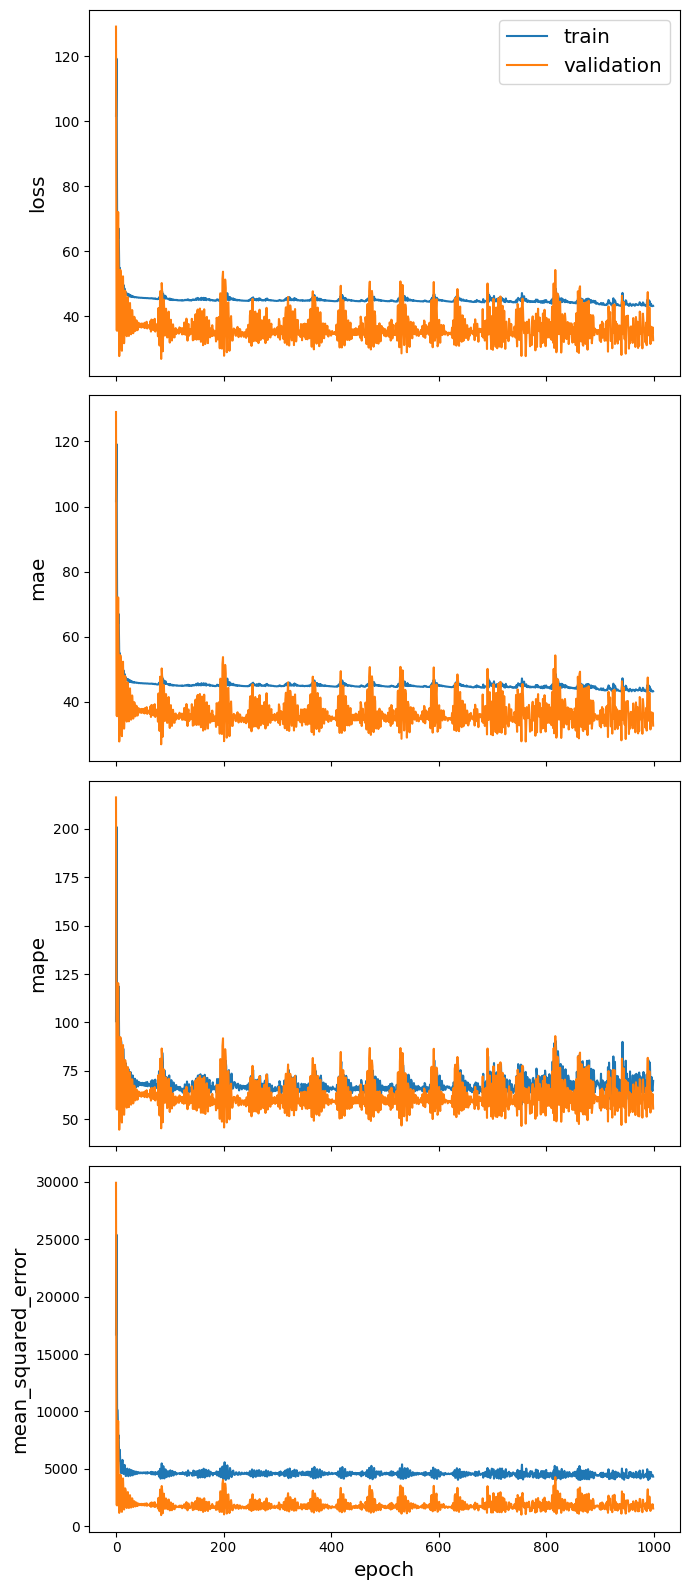

In [37]:
sg.utils.plot_history(history)

In [38]:
val_subjects, 
test_subjects

,0,1,2,3,4,5,6,7,8,9,...,743,744,745,746,747,748,749,750,751,752
AAPL,29.037500,29.004999,29.152500,29.477501,29.747499,29.777500,29.937500,29.812500,29.760000,30.000000,...,69.964996,70.102501,69.934998,70.004997,69.860001,71.000000,71.067497,72.477501,72.449997,72.879997
GOOGL,40.400501,40.388500,40.651001,41.260502,41.359001,41.300499,41.493000,41.476501,41.547001,41.373001,...,68.035004,67.744499,67.595497,67.821999,67.560997,67.531502,67.221497,68.123497,67.732002,66.985497
AMZN,37.683498,37.859001,39.022499,39.799500,39.846001,39.794998,39.951000,40.681999,40.856998,40.486000,...,88.460503,89.532997,89.201500,89.613998,89.324997,89.650002,89.460503,93.438499,93.489998,92.344498
WBA,82.959999,82.980003,83.029999,83.099998,82.550003,82.669998,84.430000,83.919998,83.820000,84.220001,...,57.799999,57.090000,57.200001,57.750000,58.389999,58.570000,58.349998,58.900002,59.020000,58.910000
XOM,90.889999,89.889999,88.550003,88.500000,87.040001,85.930000,86.809998,86.339996,86.349998,87.360001,...,70.000000,69.680000,69.870003,69.389999,69.940002,70.290001,70.019997,70.129997,69.889999,69.480003
PCAR,43.546665,44.146667,43.426666,43.919998,43.380001,44.166668,44.533333,44.220001,45.013332,44.613335,...,55.213333,54.766666,55.080002,53.126667,53.446667,53.033333,52.993332,53.006668,52.939999,52.646667
UNP,102.519997,103.139999,102.129997,103.190002,102.419998,103.419998,104.269997,104.699997,105.250000,103.370003,...,180.089996,177.389999,178.220001,177.470001,180.399994,179.419998,179.889999,180.809998,181.410004,180.149994


In [39]:
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))
    
    
    

1/1 [==============================] - 0s 43ms/step - loss: 31.8990 - mean_squared_error: 1489.0559 - mae: 31.8990 - mape: 52.8181

Test Set Metrics:
	loss: 31.8990
	mean_squared_error: 1489.0559
	mae: 31.8990
	mape: 52.8181


In [40]:
df_metrics = pd.DataFrame(columns=['Method', 'Loss', 'MSE', 'MAE', 'MAPE'])

temp = list()
temp.append('GCN-Pearson');
for name, val in zip(model.metrics_names, test_metrics):
    # print(val)
    temp.append(val)

print(temp)
df_metrics.loc[1] = temp
df_metrics

['GCN-Pearson', 31.898990631103516, 1489.055908203125, 31.898990631103516, 52.81810760498047]


,Method,Loss,MSE,MAE,MAPE
1,GCN-Pearson,31.898991,1489.055908,31.898991,52.818108


# Show the predicted prices by the Model

At this point, I still need to make sense of what GCN ( and CNN) combination + MLP is predicting. 
I am just displaying the output. 
It appears that price is predicted for each timestamp (day)

In [41]:
all_nodes = pearson_graph_node_data.index;
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

all_nodes, all_predictions, all_predictions.shape, pearson_graph_node_data.shape

1/1 [==============================] - 0s 136ms/step


(Index(['AAPL', 'ABC', 'AMZN', 'BA', 'BAC', 'CAH', 'COST', 'CVS', 'CVX', 'F',
        'GE', 'GM', 'GOOGL', 'HD', 'JPM', 'KR', 'MCK', 'MSFT', 'PCAR', 'PSX',
        'T', 'UNH', 'UNP', 'VZ', 'WBA', 'WFC', 'WMT', 'XOM'],
       dtype='object'),
 array([[[ 76.82284 ,  79.31212 ,  79.422806, ..., 142.56424 ,
          152.33507 , 145.27367 ],
         [ 83.06175 ,  85.74313 ,  84.474724, ...,  79.64526 ,
           81.46773 ,  79.58551 ],
         [ 80.01588 ,  82.60882 ,  82.69298 , ..., 148.053   ,
          158.18494 , 150.80885 ],
         ...,
         [ 78.82555 ,  81.36771 ,  80.17156 , ...,  75.416336,
           77.15175 ,  75.366554],
         [ 76.87235 ,  79.36332 ,  79.473   , ..., 142.63313 ,
          152.40826 , 145.34175 ],
         [ 60.963715,  62.918835,  62.027374, ...,  57.585163,
           58.953587,  57.577385]]], dtype=float32),
 (1, 28, 753),
 (28, 753))

In [42]:
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict
model.predict(
    all_gen,
    batch_size = None,
    verbose = 2,
    steps = None,
    callbacks = None,
    max_queue_size = 10,
    workers = 1,
    use_multiprocessing = False
)

1/1 - 0s - 75ms/epoch - 75ms/step


array([[[ 76.82284 ,  79.31212 ,  79.422806, ..., 142.56424 ,
         152.33507 , 145.27367 ],
        [ 83.06175 ,  85.74313 ,  84.474724, ...,  79.64526 ,
          81.46773 ,  79.58551 ],
        [ 80.01588 ,  82.60882 ,  82.69298 , ..., 148.053   ,
         158.18494 , 150.80885 ],
        ...,
        [ 78.82555 ,  81.36771 ,  80.17156 , ...,  75.416336,
          77.15175 ,  75.366554],
        [ 76.87235 ,  79.36332 ,  79.473   , ..., 142.63313 ,
         152.40826 , 145.34175 ],
        [ 60.963715,  62.918835,  62.027374, ...,  57.585163,
          58.953587,  57.577385]]], dtype=float32)

In [43]:
# all_predictions = model.predict(all_nodes)

# all_predictions, all_predictions.shape, pearson_graph_node_data.shape
vars(all_gen)

{'A_indices': array([[[ 0,  0],
         [ 0,  2],
         [ 0,  3],
         [ 0,  4],
         [ 0,  6],
         [ 0, 12],
         [ 0, 13],
         [ 0, 14],
         [ 0, 17],
         [ 0, 19],
         [ 0, 21],
         [ 0, 22],
         [ 0, 23],
         [ 0, 26],
         [ 1,  1],
         [ 1, 16],
         [ 1, 25],
         [ 2,  0],
         [ 2,  2],
         [ 2,  3],
         [ 2,  4],
         [ 2,  6],
         [ 2,  8],
         [ 2, 12],
         [ 2, 13],
         [ 2, 14],
         [ 2, 17],
         [ 2, 19],
         [ 2, 21],
         [ 2, 22],
         [ 2, 23],
         [ 2, 26],
         [ 3,  0],
         [ 3,  2],
         [ 3,  3],
         [ 3,  4],
         [ 3,  6],
         [ 3,  8],
         [ 3, 12],
         [ 3, 13],
         [ 3, 14],
         [ 3, 17],
         [ 3, 19],
         [ 3, 21],
         [ 3, 22],
         [ 3, 23],
         [ 3, 26],
         [ 4,  0],
         [ 4,  2],
         [ 4,  3],
         [ 4,  4],
         [ 4,  6],

In [44]:
pearson_graph_node_data

,0,1,2,3,4,5,6,7,8,9,...,743,744,745,746,747,748,749,750,751,752
AAPL,29.037500,29.004999,29.152500,29.477501,29.747499,29.777500,29.937500,29.812500,29.760000,30.000000,...,69.964996,70.102501,69.934998,70.004997,69.860001,71.000000,71.067497,72.477501,72.449997,72.879997
ABC,82.610001,84.660004,83.680000,84.800003,85.480003,84.830002,81.529999,83.860001,84.620003,85.989998,...,85.959999,83.150002,83.550003,83.800003,85.669998,85.599998,85.419998,85.050003,84.910004,83.639999
AMZN,37.683498,37.859001,39.022499,39.799500,39.846001,39.794998,39.951000,40.681999,40.856998,40.486000,...,88.460503,89.532997,89.201500,89.613998,89.324997,89.650002,89.460503,93.438499,93.489998,92.344498
BA,156.970001,158.619995,158.710007,159.100006,158.320007,159.070007,159.399994,158.289993,158.830002,157.669998,...,327.000000,327.000000,330.679993,333.500000,328.000000,337.549988,333.000000,329.920013,330.140015,326.399994
BAC,22.530001,22.950001,22.680000,22.680000,22.549999,22.940001,23.070000,22.920000,23.010000,22.049999,...,34.700001,35.040001,35.110001,34.950001,34.959999,35.169998,35.220001,35.520000,35.349998,35.150002
CAH,74.480003,75.629997,74.500000,75.330002,74.760002,75.220001,73.720001,74.190002,75.000000,75.180000,...,53.700001,51.570000,51.099998,50.610001,51.799999,51.130001,51.290001,51.169998,51.500000,50.770000
COST,159.729996,159.759995,162.910004,162.830002,160.970001,161.660004,161.539993,161.869995,161.860001,163.809998,...,293.500000,295.549988,291.869995,293.709991,294.829987,293.309998,294.230011,295.730011,294.109985,295.140015
CVS,80.349998,79.750000,81.419998,82.199997,81.699997,82.669998,82.769997,82.599998,81.980003,83.919998,...,74.400002,73.349998,73.279999,74.099998,74.580002,74.379997,74.510002,74.480003,74.400002,73.699997
CVX,117.849998,117.820000,117.309998,116.839996,115.839996,114.959999,115.930000,116.160004,116.379997,116.279999,...,119.360001,118.599998,118.550003,118.129997,119.680000,120.330002,120.339996,120.599998,120.300003,119.849998
F,12.590000,13.170000,12.770000,12.760000,12.630000,12.850000,12.670000,12.590000,12.630000,12.610000,...,9.390000,9.390000,9.540000,9.410000,9.480000,9.440000,9.470000,9.450000,9.360000,9.250000


In [45]:
vars(all_gen)

{'A_indices': array([[[ 0,  0],
         [ 0,  2],
         [ 0,  3],
         [ 0,  4],
         [ 0,  6],
         [ 0, 12],
         [ 0, 13],
         [ 0, 14],
         [ 0, 17],
         [ 0, 19],
         [ 0, 21],
         [ 0, 22],
         [ 0, 23],
         [ 0, 26],
         [ 1,  1],
         [ 1, 16],
         [ 1, 25],
         [ 2,  0],
         [ 2,  2],
         [ 2,  3],
         [ 2,  4],
         [ 2,  6],
         [ 2,  8],
         [ 2, 12],
         [ 2, 13],
         [ 2, 14],
         [ 2, 17],
         [ 2, 19],
         [ 2, 21],
         [ 2, 22],
         [ 2, 23],
         [ 2, 26],
         [ 3,  0],
         [ 3,  2],
         [ 3,  3],
         [ 3,  4],
         [ 3,  6],
         [ 3,  8],
         [ 3, 12],
         [ 3, 13],
         [ 3, 14],
         [ 3, 17],
         [ 3, 19],
         [ 3, 21],
         [ 3, 22],
         [ 3, 23],
         [ 3, 26],
         [ 4,  0],
         [ 4,  2],
         [ 4,  3],
         [ 4,  4],
         [ 4,  6],

In [46]:
train_gen[:1][:4]

([array([[[ 29.0375,  29.005 ,  29.1525, ...,  72.4775,  72.45  ,
            72.88  ],
          [ 82.61  ,  84.66  ,  83.68  , ...,  85.05  ,  84.91  ,
            83.64  ],
          [ 37.6835,  37.859 ,  39.0225, ...,  93.4385,  93.49  ,
            92.3445],
          ...,
          [ 56.    ,  56.05  ,  55.18  , ...,  54.15  ,  53.92  ,
            53.6   ],
          [ 68.66  ,  69.06  ,  69.21  , ..., 119.52  , 119.59  ,
           119.4   ],
          [ 90.89  ,  89.89  ,  88.55  , ...,  70.13  ,  69.89  ,
            69.48  ]]], dtype=float32),
  array([[ 4,  1, 20,  6,  3, 14, 11,  9, 25, 23, 15,  8, 21, 10, 16, 13,
          26,  5, 17,  7, 19]], dtype=uint8),
  array([[[ 0,  0],
          [ 0,  2],
          [ 0,  3],
          [ 0,  4],
          [ 0,  6],
          [ 0, 12],
          [ 0, 13],
          [ 0, 14],
          [ 0, 17],
          [ 0, 19],
          [ 0, 21],
          [ 0, 22],
          [ 0, 23],
          [ 0, 26],
          [ 1,  1],
          [ 1, 16],

# SPEARMAN

StellarGraph: Undirected multigraph
 Nodes: 28, Edges: 258

 Node types:
  corner: [28]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [258]
        Weights: all 1 (default)
        Features: none
Using GCN (local pooling) filters...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(1, 28, 753)]       0           []                               
                                                                                                  
 input_7 (InputLayer)           [(1, None, 2)]       0           []                               
                                                                                                  
 input_8 (InputLayer)           [(1, None)]          0           []                   

Epoch 22/1000
1/1 - 0s - loss: 50.0641 - mean_squared_error: 5731.3877 - mae: 50.0641 - mape: 71.3963 - val_loss: 44.6855 - val_mean_squared_error: 3177.0105 - val_mae: 44.6855 - val_mape: 37.1360 - 45ms/epoch - 45ms/step
Epoch 23/1000
1/1 - 0s - loss: 51.5461 - mean_squared_error: 6387.0557 - mae: 51.5461 - mape: 64.1021 - val_loss: 42.6802 - val_mean_squared_error: 2937.8794 - val_mae: 42.6802 - val_mape: 35.5240 - 45ms/epoch - 45ms/step
Epoch 24/1000
1/1 - 0s - loss: 50.8610 - mean_squared_error: 6163.4209 - mae: 50.8610 - mape: 65.8855 - val_loss: 37.4929 - val_mean_squared_error: 2245.5366 - val_mae: 37.4929 - val_mape: 32.5658 - 46ms/epoch - 46ms/step
Epoch 25/1000
1/1 - 0s - loss: 50.1235 - mean_squared_error: 5502.4238 - mae: 50.1235 - mape: 76.2689 - val_loss: 35.7534 - val_mean_squared_error: 1978.3529 - val_mae: 35.7534 - val_mape: 32.5568 - 46ms/epoch - 46ms/step
Epoch 26/1000
1/1 - 0s - loss: 51.1117 - mean_squared_error: 5238.8335 - mae: 51.1117 - mape: 85.4474 - val_loss

Epoch 59/1000
1/1 - 0s - loss: 49.3811 - mean_squared_error: 5564.1147 - mae: 49.3811 - mape: 72.8295 - val_loss: 37.8369 - val_mean_squared_error: 2286.2532 - val_mae: 37.8369 - val_mape: 32.3295 - 52ms/epoch - 52ms/step
Epoch 60/1000
1/1 - 0s - loss: 49.3813 - mean_squared_error: 5563.8306 - mae: 49.3813 - mape: 72.8381 - val_loss: 38.0731 - val_mean_squared_error: 2318.8511 - val_mae: 38.0731 - val_mape: 32.4442 - 50ms/epoch - 50ms/step
Epoch 61/1000
1/1 - 0s - loss: 49.3820 - mean_squared_error: 5593.7905 - mae: 49.3820 - mape: 72.2473 - val_loss: 37.9674 - val_mean_squared_error: 2302.5298 - val_mae: 37.9674 - val_mape: 32.4139 - 53ms/epoch - 53ms/step
Epoch 62/1000
1/1 - 0s - loss: 49.3745 - mean_squared_error: 5576.4717 - mae: 49.3745 - mape: 72.5432 - val_loss: 37.9573 - val_mean_squared_error: 2301.2004 - val_mae: 37.9573 - val_mape: 32.4142 - 54ms/epoch - 54ms/step
Epoch 63/1000
1/1 - 0s - loss: 49.3670 - mean_squared_error: 5573.2061 - mae: 49.3670 - mape: 72.5523 - val_loss

Epoch 96/1000
1/1 - 0s - loss: 49.1614 - mean_squared_error: 5574.5815 - mae: 49.1614 - mape: 71.5659 - val_loss: 37.2503 - val_mean_squared_error: 2189.0684 - val_mae: 37.2503 - val_mape: 32.1993 - 45ms/epoch - 45ms/step
Epoch 97/1000
1/1 - 0s - loss: 49.1659 - mean_squared_error: 5472.2529 - mae: 49.1659 - mape: 73.5836 - val_loss: 37.9539 - val_mean_squared_error: 2284.4966 - val_mae: 37.9539 - val_mape: 32.4988 - 45ms/epoch - 45ms/step
Epoch 98/1000
1/1 - 0s - loss: 49.1327 - mean_squared_error: 5566.3149 - mae: 49.1327 - mape: 71.6194 - val_loss: 37.7212 - val_mean_squared_error: 2252.4019 - val_mae: 37.7212 - val_mape: 32.3949 - 46ms/epoch - 46ms/step
Epoch 99/1000
1/1 - 0s - loss: 49.1058 - mean_squared_error: 5536.7754 - mae: 49.1058 - mape: 72.1084 - val_loss: 37.2988 - val_mean_squared_error: 2196.0364 - val_mae: 37.2988 - val_mape: 32.2085 - 45ms/epoch - 45ms/step
Epoch 100/1000
1/1 - 0s - loss: 49.1013 - mean_squared_error: 5483.8242 - mae: 49.1013 - mape: 73.1222 - val_los

Epoch 133/1000
1/1 - 0s - loss: 48.9020 - mean_squared_error: 5452.9854 - mae: 48.9020 - mape: 74.7538 - val_loss: 35.1954 - val_mean_squared_error: 1936.1364 - val_mae: 35.1954 - val_mape: 30.7225 - 46ms/epoch - 46ms/step
Epoch 134/1000
1/1 - 0s - loss: 48.9630 - mean_squared_error: 5393.2266 - mae: 48.9630 - mape: 75.5996 - val_loss: 38.1824 - val_mean_squared_error: 2282.2861 - val_mae: 38.1824 - val_mape: 32.4301 - 47ms/epoch - 47ms/step
Epoch 135/1000
1/1 - 0s - loss: 49.1823 - mean_squared_error: 5730.6968 - mae: 49.1823 - mape: 69.4893 - val_loss: 35.9446 - val_mean_squared_error: 2007.1273 - val_mae: 35.9446 - val_mape: 31.1318 - 45ms/epoch - 45ms/step
Epoch 136/1000
1/1 - 0s - loss: 48.8483 - mean_squared_error: 5475.5581 - mae: 48.8483 - mape: 73.8410 - val_loss: 34.4708 - val_mean_squared_error: 1827.0586 - val_mae: 34.4708 - val_mape: 30.5361 - 46ms/epoch - 46ms/step
Epoch 137/1000
1/1 - 0s - loss: 49.1448 - mean_squared_error: 5310.0386 - mae: 49.1448 - mape: 78.3494 - val

Epoch 170/1000
1/1 - 0s - loss: 48.8357 - mean_squared_error: 5522.4238 - mae: 48.8357 - mape: 73.7266 - val_loss: 35.6038 - val_mean_squared_error: 1970.2367 - val_mae: 35.6038 - val_mape: 30.7897 - 59ms/epoch - 59ms/step
Epoch 171/1000
1/1 - 0s - loss: 48.8299 - mean_squared_error: 5488.9189 - mae: 48.8299 - mape: 73.8441 - val_loss: 35.6379 - val_mean_squared_error: 1970.4879 - val_mae: 35.6379 - val_mape: 30.8041 - 50ms/epoch - 50ms/step
Epoch 172/1000
1/1 - 0s - loss: 48.7972 - mean_squared_error: 5495.0942 - mae: 48.7972 - mape: 73.7695 - val_loss: 35.7553 - val_mean_squared_error: 1973.4414 - val_mae: 35.7553 - val_mape: 30.8939 - 59ms/epoch - 59ms/step
Epoch 173/1000
1/1 - 0s - loss: 48.8078 - mean_squared_error: 5514.8726 - mae: 48.8078 - mape: 73.7529 - val_loss: 35.2270 - val_mean_squared_error: 1914.9418 - val_mae: 35.2270 - val_mape: 30.5988 - 50ms/epoch - 50ms/step
Epoch 174/1000
1/1 - 0s - loss: 48.8101 - mean_squared_error: 5456.9585 - mae: 48.8101 - mape: 74.9016 - val

Epoch 207/1000
1/1 - 0s - loss: 48.8381 - mean_squared_error: 5473.5869 - mae: 48.8381 - mape: 74.6808 - val_loss: 34.3661 - val_mean_squared_error: 1797.1975 - val_mae: 34.3661 - val_mape: 30.3982 - 48ms/epoch - 48ms/step
Epoch 208/1000
1/1 - 0s - loss: 49.0462 - mean_squared_error: 5338.9263 - mae: 49.0462 - mape: 77.9777 - val_loss: 38.0784 - val_mean_squared_error: 2246.8674 - val_mae: 38.0784 - val_mape: 32.4285 - 47ms/epoch - 47ms/step
Epoch 209/1000
1/1 - 0s - loss: 49.1506 - mean_squared_error: 5723.7710 - mae: 49.1506 - mape: 69.3923 - val_loss: 36.0033 - val_mean_squared_error: 2015.0502 - val_mae: 36.0033 - val_mape: 31.3006 - 55ms/epoch - 55ms/step
Epoch 210/1000
1/1 - 0s - loss: 48.9467 - mean_squared_error: 5451.7017 - mae: 48.9467 - mape: 73.3629 - val_loss: 35.0819 - val_mean_squared_error: 1891.2767 - val_mae: 35.0819 - val_mape: 30.7896 - 57ms/epoch - 57ms/step
Epoch 211/1000
1/1 - 0s - loss: 48.8827 - mean_squared_error: 5374.3447 - mae: 48.8827 - mape: 75.7881 - val

Epoch 244/1000
1/1 - 0s - loss: 48.9097 - mean_squared_error: 5600.4800 - mae: 48.9097 - mape: 72.2604 - val_loss: 35.5582 - val_mean_squared_error: 1939.2971 - val_mae: 35.5582 - val_mape: 30.8822 - 51ms/epoch - 51ms/step
Epoch 245/1000
1/1 - 0s - loss: 48.8111 - mean_squared_error: 5483.4038 - mae: 48.8111 - mape: 74.4979 - val_loss: 34.7600 - val_mean_squared_error: 1871.1791 - val_mae: 34.7600 - val_mape: 30.3529 - 49ms/epoch - 49ms/step
Epoch 246/1000
1/1 - 0s - loss: 48.8939 - mean_squared_error: 5394.9614 - mae: 48.8939 - mape: 75.9353 - val_loss: 37.4702 - val_mean_squared_error: 2174.5342 - val_mae: 37.4702 - val_mape: 31.9272 - 48ms/epoch - 48ms/step
Epoch 247/1000
1/1 - 0s - loss: 49.0379 - mean_squared_error: 5691.1436 - mae: 49.0379 - mape: 70.3902 - val_loss: 34.6710 - val_mean_squared_error: 1843.0443 - val_mae: 34.6710 - val_mape: 30.3573 - 49ms/epoch - 49ms/step
Epoch 248/1000
1/1 - 0s - loss: 48.8841 - mean_squared_error: 5394.6758 - mae: 48.8841 - mape: 76.5194 - val

Epoch 281/1000
1/1 - 0s - loss: 48.9270 - mean_squared_error: 5430.3081 - mae: 48.9270 - mape: 75.5387 - val_loss: 37.7371 - val_mean_squared_error: 2209.9590 - val_mae: 37.7371 - val_mape: 32.1944 - 49ms/epoch - 49ms/step
Epoch 282/1000
1/1 - 0s - loss: 49.1449 - mean_squared_error: 5698.2168 - mae: 49.1449 - mape: 70.7085 - val_loss: 36.0298 - val_mean_squared_error: 2003.4480 - val_mae: 36.0298 - val_mape: 31.1694 - 51ms/epoch - 51ms/step
Epoch 283/1000
1/1 - 0s - loss: 48.8497 - mean_squared_error: 5488.9023 - mae: 48.8497 - mape: 73.6363 - val_loss: 34.3142 - val_mean_squared_error: 1829.9277 - val_mae: 34.3142 - val_mape: 30.2697 - 62ms/epoch - 62ms/step
Epoch 284/1000
1/1 - 0s - loss: 49.1716 - mean_squared_error: 5295.4165 - mae: 49.1716 - mape: 78.0050 - val_loss: 36.9502 - val_mean_squared_error: 2118.7095 - val_mae: 36.9502 - val_mape: 31.5789 - 56ms/epoch - 56ms/step
Epoch 285/1000
1/1 - 0s - loss: 48.9286 - mean_squared_error: 5619.0117 - mae: 48.9286 - mape: 71.4504 - val

Epoch 318/1000
1/1 - 0s - loss: 48.8334 - mean_squared_error: 5587.1250 - mae: 48.8334 - mape: 71.7253 - val_loss: 34.3644 - val_mean_squared_error: 1810.4910 - val_mae: 34.3644 - val_mape: 30.2735 - 59ms/epoch - 59ms/step
Epoch 319/1000
1/1 - 0s - loss: 48.9376 - mean_squared_error: 5348.3242 - mae: 48.9376 - mape: 77.3900 - val_loss: 37.3357 - val_mean_squared_error: 2159.9753 - val_mae: 37.3357 - val_mape: 31.8532 - 63ms/epoch - 63ms/step
Epoch 320/1000
1/1 - 0s - loss: 48.9952 - mean_squared_error: 5678.4277 - mae: 48.9952 - mape: 70.6560 - val_loss: 35.8811 - val_mean_squared_error: 1987.0807 - val_mae: 35.8811 - val_mape: 31.0131 - 82ms/epoch - 82ms/step
Epoch 321/1000
1/1 - 0s - loss: 48.7961 - mean_squared_error: 5503.7720 - mae: 48.7961 - mape: 73.3997 - val_loss: 34.1689 - val_mean_squared_error: 1806.5469 - val_mae: 34.1689 - val_mape: 30.1115 - 90ms/epoch - 90ms/step
Epoch 322/1000
1/1 - 0s - loss: 49.0259 - mean_squared_error: 5316.1172 - mae: 49.0259 - mape: 77.6123 - val

Epoch 355/1000
1/1 - 0s - loss: 48.8865 - mean_squared_error: 5351.2021 - mae: 48.8865 - mape: 76.3911 - val_loss: 37.1221 - val_mean_squared_error: 2131.5903 - val_mae: 37.1221 - val_mape: 31.7953 - 46ms/epoch - 46ms/step
Epoch 356/1000
1/1 - 0s - loss: 48.9058 - mean_squared_error: 5623.8398 - mae: 48.9058 - mape: 71.1254 - val_loss: 36.0480 - val_mean_squared_error: 2003.2791 - val_mae: 36.0480 - val_mape: 31.1372 - 46ms/epoch - 46ms/step
Epoch 357/1000
1/1 - 0s - loss: 48.7755 - mean_squared_error: 5515.7212 - mae: 48.7755 - mape: 73.2361 - val_loss: 34.1439 - val_mean_squared_error: 1792.2781 - val_mae: 34.1439 - val_mape: 30.1371 - 44ms/epoch - 44ms/step
Epoch 358/1000
1/1 - 0s - loss: 49.0229 - mean_squared_error: 5321.4912 - mae: 49.0229 - mape: 78.0817 - val_loss: 37.8990 - val_mean_squared_error: 2232.8489 - val_mae: 37.8990 - val_mape: 32.1621 - 52ms/epoch - 52ms/step
Epoch 359/1000
1/1 - 0s - loss: 49.0993 - mean_squared_error: 5739.8618 - mae: 49.0993 - mape: 69.5421 - val

Epoch 392/1000
1/1 - 0s - loss: 48.7454 - mean_squared_error: 5456.1504 - mae: 48.7454 - mape: 74.5071 - val_loss: 35.2998 - val_mean_squared_error: 1914.0084 - val_mae: 35.2998 - val_mape: 30.7136 - 55ms/epoch - 55ms/step
Epoch 393/1000
1/1 - 0s - loss: 48.7506 - mean_squared_error: 5459.9307 - mae: 48.7506 - mape: 74.6344 - val_loss: 36.3840 - val_mean_squared_error: 2048.5483 - val_mae: 36.3840 - val_mape: 31.2876 - 54ms/epoch - 54ms/step
Epoch 394/1000
1/1 - 0s - loss: 48.7796 - mean_squared_error: 5572.0586 - mae: 48.7796 - mape: 72.0462 - val_loss: 34.8244 - val_mean_squared_error: 1880.2289 - val_mae: 34.8244 - val_mape: 30.3903 - 82ms/epoch - 82ms/step
Epoch 395/1000
1/1 - 0s - loss: 48.8216 - mean_squared_error: 5406.2119 - mae: 48.8216 - mape: 75.4370 - val_loss: 36.1701 - val_mean_squared_error: 2021.7239 - val_mae: 36.1701 - val_mape: 31.1446 - 60ms/epoch - 60ms/step
Epoch 396/1000
1/1 - 0s - loss: 48.7607 - mean_squared_error: 5557.1646 - mae: 48.7607 - mape: 72.5605 - val

Epoch 429/1000
1/1 - 0s - loss: 48.8910 - mean_squared_error: 5645.5635 - mae: 48.8910 - mape: 70.9364 - val_loss: 35.5160 - val_mean_squared_error: 1942.7747 - val_mae: 35.5160 - val_mape: 30.8077 - 51ms/epoch - 51ms/step
Epoch 430/1000
1/1 - 0s - loss: 48.7213 - mean_squared_error: 5472.2119 - mae: 48.7213 - mape: 74.0631 - val_loss: 34.3361 - val_mean_squared_error: 1816.8539 - val_mae: 34.3361 - val_mape: 30.2017 - 48ms/epoch - 48ms/step
Epoch 431/1000
1/1 - 0s - loss: 48.9147 - mean_squared_error: 5345.3442 - mae: 48.9147 - mape: 77.0691 - val_loss: 38.1250 - val_mean_squared_error: 2252.0164 - val_mae: 38.1250 - val_mape: 32.4139 - 49ms/epoch - 49ms/step
Epoch 432/1000
1/1 - 0s - loss: 49.1354 - mean_squared_error: 5750.2642 - mae: 49.1354 - mape: 69.2194 - val_loss: 35.4712 - val_mean_squared_error: 1928.8840 - val_mae: 35.4712 - val_mape: 30.8631 - 52ms/epoch - 52ms/step
Epoch 433/1000
1/1 - 0s - loss: 48.7467 - mean_squared_error: 5458.1460 - mae: 48.7467 - mape: 74.4932 - val

Epoch 466/1000
1/1 - 0s - loss: 48.8004 - mean_squared_error: 5422.9409 - mae: 48.8004 - mape: 75.9357 - val_loss: 36.1574 - val_mean_squared_error: 2017.6744 - val_mae: 36.1574 - val_mape: 31.0993 - 68ms/epoch - 68ms/step
Epoch 467/1000
1/1 - 0s - loss: 48.7613 - mean_squared_error: 5564.0347 - mae: 48.7613 - mape: 72.7298 - val_loss: 35.8041 - val_mean_squared_error: 1982.5371 - val_mae: 35.8041 - val_mape: 30.8687 - 51ms/epoch - 51ms/step
Epoch 468/1000
1/1 - 0s - loss: 48.7010 - mean_squared_error: 5517.3022 - mae: 48.7010 - mape: 73.2456 - val_loss: 34.8822 - val_mean_squared_error: 1889.6409 - val_mae: 34.8822 - val_mape: 30.3293 - 66ms/epoch - 66ms/step
Epoch 469/1000
1/1 - 0s - loss: 48.7998 - mean_squared_error: 5419.0806 - mae: 48.7998 - mape: 75.3027 - val_loss: 37.0113 - val_mean_squared_error: 2125.2883 - val_mae: 37.0113 - val_mape: 31.5662 - 55ms/epoch - 55ms/step
Epoch 470/1000
1/1 - 0s - loss: 48.8881 - mean_squared_error: 5655.5874 - mae: 48.8881 - mape: 70.9405 - val

Epoch 503/1000
1/1 - 0s - loss: 48.8406 - mean_squared_error: 5355.1455 - mae: 48.8406 - mape: 76.8943 - val_loss: 36.4873 - val_mean_squared_error: 2055.8806 - val_mae: 36.4873 - val_mape: 31.3467 - 47ms/epoch - 47ms/step
Epoch 504/1000
1/1 - 0s - loss: 48.7682 - mean_squared_error: 5578.0088 - mae: 48.7682 - mape: 71.9871 - val_loss: 36.1091 - val_mean_squared_error: 2010.1660 - val_mae: 36.1091 - val_mape: 31.1543 - 45ms/epoch - 45ms/step
Epoch 505/1000
1/1 - 0s - loss: 48.7197 - mean_squared_error: 5528.6016 - mae: 48.7197 - mape: 72.7727 - val_loss: 34.6434 - val_mean_squared_error: 1849.9268 - val_mae: 34.6434 - val_mape: 30.3721 - 46ms/epoch - 46ms/step
Epoch 506/1000
1/1 - 0s - loss: 48.7972 - mean_squared_error: 5367.7637 - mae: 48.7972 - mape: 76.1673 - val_loss: 36.7530 - val_mean_squared_error: 2092.5906 - val_mae: 36.7530 - val_mape: 31.5178 - 48ms/epoch - 48ms/step
Epoch 507/1000
1/1 - 0s - loss: 48.7692 - mean_squared_error: 5592.3511 - mae: 48.7692 - mape: 71.2722 - val

Epoch 540/1000
1/1 - 0s - loss: 49.1485 - mean_squared_error: 5298.5059 - mae: 49.1485 - mape: 79.6534 - val_loss: 38.8800 - val_mean_squared_error: 2334.0833 - val_mae: 38.8800 - val_mape: 32.9495 - 56ms/epoch - 56ms/step
Epoch 541/1000
1/1 - 0s - loss: 49.2804 - mean_squared_error: 5835.8750 - mae: 49.2804 - mape: 68.0306 - val_loss: 35.3905 - val_mean_squared_error: 1938.0349 - val_mae: 35.3905 - val_mape: 30.7181 - 48ms/epoch - 48ms/step
Epoch 542/1000
1/1 - 0s - loss: 48.7024 - mean_squared_error: 5441.5142 - mae: 48.7024 - mape: 74.0281 - val_loss: 33.7418 - val_mean_squared_error: 1745.3704 - val_mae: 33.7418 - val_mape: 30.1181 - 71ms/epoch - 71ms/step
Epoch 543/1000
1/1 - 0s - loss: 49.1299 - mean_squared_error: 5244.9077 - mae: 49.1299 - mape: 79.4193 - val_loss: 39.9308 - val_mean_squared_error: 2462.5532 - val_mae: 39.9308 - val_mape: 33.7957 - 58ms/epoch - 58ms/step
Epoch 544/1000
1/1 - 0s - loss: 49.4669 - mean_squared_error: 5898.3477 - mae: 49.4669 - mape: 66.5365 - val

Epoch 577/1000
1/1 - 0s - loss: 48.7941 - mean_squared_error: 5366.1528 - mae: 48.7941 - mape: 76.0436 - val_loss: 36.5246 - val_mean_squared_error: 2071.5356 - val_mae: 36.5246 - val_mape: 31.4032 - 63ms/epoch - 63ms/step
Epoch 578/1000
1/1 - 0s - loss: 48.7533 - mean_squared_error: 5554.0845 - mae: 48.7533 - mape: 71.7733 - val_loss: 36.1715 - val_mean_squared_error: 2028.3523 - val_mae: 36.1715 - val_mape: 31.1556 - 61ms/epoch - 61ms/step
Epoch 579/1000
1/1 - 0s - loss: 48.6896 - mean_squared_error: 5526.4805 - mae: 48.6896 - mape: 72.4708 - val_loss: 34.8758 - val_mean_squared_error: 1868.8293 - val_mae: 34.8758 - val_mape: 30.5112 - 53ms/epoch - 53ms/step
Epoch 580/1000
1/1 - 0s - loss: 48.7396 - mean_squared_error: 5395.4697 - mae: 48.7396 - mape: 75.8997 - val_loss: 36.5055 - val_mean_squared_error: 2062.7886 - val_mae: 36.5055 - val_mape: 31.3196 - 49ms/epoch - 49ms/step
Epoch 581/1000
1/1 - 0s - loss: 48.7484 - mean_squared_error: 5585.9365 - mae: 48.7484 - mape: 72.0104 - val

Epoch 614/1000
1/1 - 0s - loss: 48.9606 - mean_squared_error: 5339.5259 - mae: 48.9606 - mape: 76.2864 - val_loss: 34.9334 - val_mean_squared_error: 1861.2490 - val_mae: 34.9334 - val_mape: 30.8105 - 47ms/epoch - 47ms/step
Epoch 615/1000
1/1 - 0s - loss: 48.9169 - mean_squared_error: 5345.9307 - mae: 48.9169 - mape: 76.9182 - val_loss: 37.1212 - val_mean_squared_error: 2131.0000 - val_mae: 37.1212 - val_mape: 32.1628 - 46ms/epoch - 46ms/step
Epoch 616/1000
1/1 - 0s - loss: 48.8785 - mean_squared_error: 5532.7524 - mae: 48.8785 - mape: 71.4587 - val_loss: 36.9684 - val_mean_squared_error: 2096.5767 - val_mae: 36.9684 - val_mape: 32.4901 - 45ms/epoch - 45ms/step
Epoch 617/1000
1/1 - 0s - loss: 48.9811 - mean_squared_error: 5451.0298 - mae: 48.9811 - mape: 72.9151 - val_loss: 39.2493 - val_mean_squared_error: 2421.5063 - val_mae: 39.2493 - val_mape: 32.9207 - 47ms/epoch - 47ms/step
Epoch 618/1000
1/1 - 0s - loss: 49.5196 - mean_squared_error: 5925.1562 - mae: 49.5196 - mape: 67.8021 - val

Epoch 651/1000
1/1 - 0s - loss: 49.0250 - mean_squared_error: 5472.8135 - mae: 49.0250 - mape: 71.0293 - val_loss: 34.7868 - val_mean_squared_error: 1945.8730 - val_mae: 34.7868 - val_mape: 31.1477 - 54ms/epoch - 54ms/step
Epoch 652/1000
1/1 - 0s - loss: 49.8431 - mean_squared_error: 5153.7905 - mae: 49.8431 - mape: 79.2212 - val_loss: 39.1430 - val_mean_squared_error: 2424.2336 - val_mae: 39.1430 - val_mape: 33.3955 - 55ms/epoch - 55ms/step
Epoch 653/1000
1/1 - 0s - loss: 49.1103 - mean_squared_error: 5638.1069 - mae: 49.1103 - mape: 67.9523 - val_loss: 39.5272 - val_mean_squared_error: 2467.4937 - val_mae: 39.5272 - val_mape: 33.5251 - 55ms/epoch - 55ms/step
Epoch 654/1000
1/1 - 0s - loss: 49.1997 - mean_squared_error: 5732.9756 - mae: 49.1997 - mape: 67.3388 - val_loss: 35.5644 - val_mean_squared_error: 1921.8542 - val_mae: 35.5644 - val_mape: 31.6566 - 52ms/epoch - 52ms/step
Epoch 655/1000
1/1 - 0s - loss: 49.1600 - mean_squared_error: 5279.3506 - mae: 49.1600 - mape: 77.5575 - val

Epoch 688/1000
1/1 - 0s - loss: 49.2313 - mean_squared_error: 5300.3623 - mae: 49.2313 - mape: 75.5418 - val_loss: 38.2076 - val_mean_squared_error: 2298.1294 - val_mae: 38.2076 - val_mape: 32.6496 - 57ms/epoch - 57ms/step
Epoch 689/1000
1/1 - 0s - loss: 48.8958 - mean_squared_error: 5590.3848 - mae: 48.8958 - mape: 69.3447 - val_loss: 37.7369 - val_mean_squared_error: 2224.7205 - val_mae: 37.7369 - val_mape: 32.2965 - 58ms/epoch - 58ms/step
Epoch 690/1000
1/1 - 0s - loss: 48.8007 - mean_squared_error: 5579.8774 - mae: 48.8007 - mape: 69.9911 - val_loss: 35.1747 - val_mean_squared_error: 1909.0886 - val_mae: 35.1747 - val_mape: 30.8528 - 67ms/epoch - 67ms/step
Epoch 691/1000
1/1 - 0s - loss: 48.7954 - mean_squared_error: 5351.2524 - mae: 48.7954 - mape: 75.6474 - val_loss: 35.3124 - val_mean_squared_error: 1911.9812 - val_mae: 35.3124 - val_mape: 30.7517 - 59ms/epoch - 59ms/step
Epoch 692/1000
1/1 - 0s - loss: 48.7287 - mean_squared_error: 5450.4976 - mae: 48.7287 - mape: 74.7794 - val

Epoch 725/1000
1/1 - 0s - loss: 48.8243 - mean_squared_error: 5319.3887 - mae: 48.8243 - mape: 76.8113 - val_loss: 37.0145 - val_mean_squared_error: 2121.8335 - val_mae: 37.0145 - val_mape: 31.5630 - 43ms/epoch - 43ms/step
Epoch 726/1000
1/1 - 0s - loss: 48.8035 - mean_squared_error: 5664.0723 - mae: 48.8035 - mape: 70.7385 - val_loss: 35.2458 - val_mean_squared_error: 1912.8743 - val_mae: 35.2458 - val_mape: 30.3721 - 46ms/epoch - 46ms/step
Epoch 727/1000
1/1 - 0s - loss: 48.6828 - mean_squared_error: 5536.6533 - mae: 48.6828 - mape: 74.1672 - val_loss: 34.8464 - val_mean_squared_error: 1867.9573 - val_mae: 34.8464 - val_mape: 30.2223 - 43ms/epoch - 43ms/step
Epoch 728/1000
1/1 - 0s - loss: 48.6410 - mean_squared_error: 5467.4473 - mae: 48.6410 - mape: 74.9520 - val_loss: 36.6944 - val_mean_squared_error: 2082.6204 - val_mae: 36.6944 - val_mape: 31.5178 - 44ms/epoch - 44ms/step
Epoch 729/1000
1/1 - 0s - loss: 48.6757 - mean_squared_error: 5573.6582 - mae: 48.6757 - mape: 71.3129 - val

Epoch 762/1000
1/1 - 0s - loss: 48.7209 - mean_squared_error: 5363.2236 - mae: 48.7209 - mape: 75.8946 - val_loss: 36.5222 - val_mean_squared_error: 2048.4692 - val_mae: 36.5222 - val_mape: 31.5384 - 48ms/epoch - 48ms/step
Epoch 763/1000
1/1 - 0s - loss: 48.7063 - mean_squared_error: 5557.3228 - mae: 48.7063 - mape: 72.3925 - val_loss: 36.0243 - val_mean_squared_error: 1984.0472 - val_mae: 36.0243 - val_mape: 31.3001 - 42ms/epoch - 42ms/step
Epoch 764/1000
1/1 - 0s - loss: 48.6624 - mean_squared_error: 5502.1045 - mae: 48.6624 - mape: 73.6810 - val_loss: 35.3804 - val_mean_squared_error: 1922.6902 - val_mae: 35.3804 - val_mape: 30.9052 - 44ms/epoch - 44ms/step
Epoch 765/1000
1/1 - 0s - loss: 48.6343 - mean_squared_error: 5411.2046 - mae: 48.6343 - mape: 74.8901 - val_loss: 36.6047 - val_mean_squared_error: 2081.6147 - val_mae: 36.6047 - val_mape: 31.4438 - 45ms/epoch - 45ms/step
Epoch 766/1000
1/1 - 0s - loss: 48.6593 - mean_squared_error: 5546.4424 - mae: 48.6593 - mape: 71.7565 - val

Epoch 799/1000
1/1 - 0s - loss: 48.9912 - mean_squared_error: 5752.7793 - mae: 48.9912 - mape: 68.2762 - val_loss: 34.3439 - val_mean_squared_error: 1825.3191 - val_mae: 34.3439 - val_mape: 30.5018 - 44ms/epoch - 44ms/step
Epoch 800/1000
1/1 - 0s - loss: 48.9926 - mean_squared_error: 5260.2822 - mae: 48.9926 - mape: 77.7011 - val_loss: 37.4518 - val_mean_squared_error: 2174.9097 - val_mae: 37.4518 - val_mape: 32.0973 - 45ms/epoch - 45ms/step
Epoch 801/1000
1/1 - 0s - loss: 48.6756 - mean_squared_error: 5593.1064 - mae: 48.6756 - mape: 70.0101 - val_loss: 36.5099 - val_mean_squared_error: 2060.5806 - val_mae: 36.5099 - val_mape: 31.4865 - 47ms/epoch - 47ms/step
Epoch 802/1000
1/1 - 0s - loss: 48.5714 - mean_squared_error: 5507.5464 - mae: 48.5714 - mape: 71.7734 - val_loss: 34.4689 - val_mean_squared_error: 1831.4281 - val_mae: 34.4689 - val_mape: 30.2375 - 45ms/epoch - 45ms/step
Epoch 803/1000
1/1 - 0s - loss: 48.6894 - mean_squared_error: 5341.9380 - mae: 48.6894 - mape: 76.3288 - val

Epoch 836/1000
1/1 - 0s - loss: 48.7883 - mean_squared_error: 5479.6743 - mae: 48.7883 - mape: 71.2437 - val_loss: 34.3983 - val_mean_squared_error: 1846.8127 - val_mae: 34.3983 - val_mape: 30.5421 - 45ms/epoch - 45ms/step
Epoch 837/1000
1/1 - 0s - loss: 49.2250 - mean_squared_error: 5222.7520 - mae: 49.2250 - mape: 78.5256 - val_loss: 37.7120 - val_mean_squared_error: 2233.8311 - val_mae: 37.7120 - val_mape: 31.7885 - 44ms/epoch - 44ms/step
Epoch 838/1000
1/1 - 0s - loss: 48.9056 - mean_squared_error: 5727.7944 - mae: 48.9056 - mape: 69.4165 - val_loss: 36.1425 - val_mean_squared_error: 2041.7214 - val_mae: 36.1425 - val_mape: 30.7517 - 49ms/epoch - 49ms/step
Epoch 839/1000
1/1 - 0s - loss: 48.6996 - mean_squared_error: 5604.4570 - mae: 48.6996 - mape: 72.3443 - val_loss: 33.8586 - val_mean_squared_error: 1725.9281 - val_mae: 33.8586 - val_mape: 30.2231 - 41ms/epoch - 41ms/step
Epoch 840/1000
1/1 - 0s - loss: 49.4465 - mean_squared_error: 5310.0557 - mae: 49.4465 - mape: 81.3098 - val

Epoch 873/1000
1/1 - 0s - loss: 48.7046 - mean_squared_error: 5426.7290 - mae: 48.7046 - mape: 73.4923 - val_loss: 34.5546 - val_mean_squared_error: 1833.2744 - val_mae: 34.5546 - val_mape: 30.5108 - 47ms/epoch - 47ms/step
Epoch 874/1000
1/1 - 0s - loss: 48.9035 - mean_squared_error: 5296.1099 - mae: 48.9035 - mape: 77.1715 - val_loss: 36.3386 - val_mean_squared_error: 2032.1475 - val_mae: 36.3386 - val_mape: 31.3098 - 46ms/epoch - 46ms/step
Epoch 875/1000
1/1 - 0s - loss: 48.6431 - mean_squared_error: 5526.4326 - mae: 48.6431 - mape: 72.2335 - val_loss: 37.1345 - val_mean_squared_error: 2130.3560 - val_mae: 37.1345 - val_mape: 31.6689 - 44ms/epoch - 44ms/step
Epoch 876/1000
1/1 - 0s - loss: 48.7893 - mean_squared_error: 5669.6680 - mae: 48.7893 - mape: 70.5073 - val_loss: 34.7775 - val_mean_squared_error: 1850.7926 - val_mae: 34.7775 - val_mape: 30.2514 - 46ms/epoch - 46ms/step
Epoch 877/1000
1/1 - 0s - loss: 48.6553 - mean_squared_error: 5457.8188 - mae: 48.6553 - mape: 75.2650 - val

Epoch 910/1000
1/1 - 0s - loss: 48.8562 - mean_squared_error: 5666.8867 - mae: 48.8562 - mape: 69.2916 - val_loss: 34.8848 - val_mean_squared_error: 1867.6927 - val_mae: 34.8848 - val_mape: 30.5056 - 61ms/epoch - 61ms/step
Epoch 911/1000
1/1 - 0s - loss: 48.7467 - mean_squared_error: 5382.3755 - mae: 48.7467 - mape: 75.8545 - val_loss: 34.2972 - val_mean_squared_error: 1799.2473 - val_mae: 34.2972 - val_mape: 30.1244 - 49ms/epoch - 49ms/step
Epoch 912/1000
1/1 - 0s - loss: 48.8086 - mean_squared_error: 5357.9028 - mae: 48.8086 - mape: 77.1413 - val_loss: 37.4999 - val_mean_squared_error: 2181.6257 - val_mae: 37.4999 - val_mape: 31.8922 - 50ms/epoch - 50ms/step
Epoch 913/1000
1/1 - 0s - loss: 48.8115 - mean_squared_error: 5689.5215 - mae: 48.8115 - mape: 69.8383 - val_loss: 37.0255 - val_mean_squared_error: 2121.1362 - val_mae: 37.0255 - val_mape: 31.6428 - 55ms/epoch - 55ms/step
Epoch 914/1000
1/1 - 0s - loss: 48.6890 - mean_squared_error: 5618.5771 - mae: 48.6890 - mape: 70.6356 - val

Epoch 947/1000
1/1 - 0s - loss: 49.0828 - mean_squared_error: 5299.1865 - mae: 49.0828 - mape: 79.5542 - val_loss: 39.9455 - val_mean_squared_error: 2502.5105 - val_mae: 39.9455 - val_mape: 33.6917 - 49ms/epoch - 49ms/step
Epoch 948/1000
1/1 - 0s - loss: 49.2419 - mean_squared_error: 5842.4834 - mae: 49.2419 - mape: 66.0624 - val_loss: 38.8574 - val_mean_squared_error: 2379.3042 - val_mae: 38.8574 - val_mape: 33.3767 - 50ms/epoch - 50ms/step
Epoch 949/1000
1/1 - 0s - loss: 48.8919 - mean_squared_error: 5555.9756 - mae: 48.8919 - mape: 68.4741 - val_loss: 35.8134 - val_mean_squared_error: 2039.0424 - val_mae: 35.8134 - val_mape: 32.0613 - 46ms/epoch - 46ms/step
Epoch 950/1000
1/1 - 0s - loss: 49.5659 - mean_squared_error: 5172.2578 - mae: 49.5659 - mape: 77.4033 - val_loss: 37.7098 - val_mean_squared_error: 2253.2554 - val_mae: 37.7098 - val_mape: 32.7442 - 47ms/epoch - 47ms/step
Epoch 951/1000
1/1 - 0s - loss: 48.8964 - mean_squared_error: 5411.5850 - mae: 48.8964 - mape: 71.0906 - val

Epoch 984/1000
1/1 - 0s - loss: 48.5766 - mean_squared_error: 5520.4497 - mae: 48.5766 - mape: 70.9920 - val_loss: 37.3084 - val_mean_squared_error: 2159.3179 - val_mae: 37.3084 - val_mape: 31.9619 - 48ms/epoch - 48ms/step
Epoch 985/1000
1/1 - 0s - loss: 48.6265 - mean_squared_error: 5591.9072 - mae: 48.6265 - mape: 69.9095 - val_loss: 34.3848 - val_mean_squared_error: 1829.7507 - val_mae: 34.3848 - val_mape: 30.2128 - 46ms/epoch - 46ms/step
Epoch 986/1000
1/1 - 0s - loss: 48.7194 - mean_squared_error: 5321.3457 - mae: 48.7194 - mape: 76.3066 - val_loss: 36.0857 - val_mean_squared_error: 2008.1719 - val_mae: 36.0857 - val_mape: 31.0547 - 45ms/epoch - 45ms/step
Epoch 987/1000
1/1 - 0s - loss: 48.5066 - mean_squared_error: 5535.0439 - mae: 48.5066 - mape: 72.0413 - val_loss: 35.9550 - val_mean_squared_error: 1988.3649 - val_mae: 35.9550 - val_mape: 30.9601 - 43ms/epoch - 43ms/step
Epoch 988/1000
1/1 - 0s - loss: 48.5965 - mean_squared_error: 5556.2324 - mae: 48.5965 - mape: 72.7118 - val

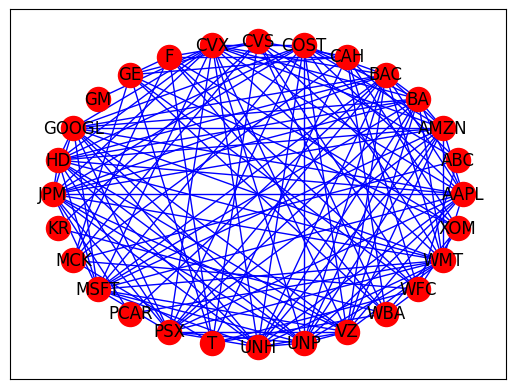

In [47]:
# Spearman

df_s_transpose_spearman = df_s_transpose.corr(method = 'spearman', numeric_only = True)
df_s_transpose_spearman


# # Pearson Correlation Coefficient based Adjacency Graph Matrix

# In[32]:


df_s_transpose_spearman[df_s_transpose_spearman >= 0.4] = 1
df_s_transpose_spearman[df_s_transpose_spearman < 0.4] = 0
df_s_transpose_spearman


# In[33]:


# make the diagonal element to be zero. No self loop
import numpy as np
np.fill_diagonal(df_s_transpose_spearman.values, 0)
df_s_transpose_spearman


# Create and visualize the Graphs

# In[34]:


import networkx as nx
Graph_spearman = nx.Graph(df_s_transpose_spearman)


# In[36]:


nx.draw_networkx(Graph_spearman, pos=nx.circular_layout(Graph_spearman), node_color='r', edge_color='b')


# # Create GCN layer. Graph_spearman

# # Find all stocks = nodes

# In[37]:


# improvement: make sure only stocks/nodes that are in the graph are taken
all_stock_nodes = df_s_transpose_spearman.index.to_list()
all_stock_nodes


# # Find all edges between nodes

# In[38]:


source = [];
target = [];
edge_feature = [];

for aStock in all_stock_nodes:
    for anotherStock in all_stock_nodes:
        if df_s_transpose_spearman[aStock][anotherStock] > 0:
            #print(df_s_transpose_spearman[aStock][anotherStock])
            source.append(aStock)
            target.append(anotherStock)
            edge_feature.append(1)
            
source, target, edge_feature            


# In[39]:


# https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
spearman_edges = pd.DataFrame(
    {"source": source, "target": target}
)

spearman_edges_data = pd.DataFrame(
    {"source": source, "target": target, "edge_feature": edge_feature}
)


spearman_edges[:10]


# # Graph with No Feature Data, No node data, only edges

# spearman_graph = StellarGraph(edges = spearman_edges, node_type_default="corner", edge_type_default="line")
# #spearman_graph = StellarGraph(nodes = all_stock_nodes, edges = spearman_edges)
# # graph = sg.StellarGraph(all_stock_nodes, square_edges)
# print(spearman_graph.info())

# In[40]:


# Trying to have the time series data as part of the nodes


# In[41]:


df_s_transpose


# # Structure the Feature Matrix so that it can be passed to the GCN

# In[43]:


df_s_transpose_feature = df_s_transpose.reset_index(drop = True, inplace = False)
# df_s_transpose_feature =  df_s_transpose_feature.values.tolist()
# print(df_s_transpose_feature.values.tolist())
#df_s_transpose_feature['WY'].values
df_s_transpose_feature['AAPL'].values


# In[44]:


node_Data = [];
for x in all_stock_nodes:
    node_Data.append( df_s_transpose_feature[x].values)
    
    
node_Data    


# In[45]:


spearman_graph_node_data = pd.DataFrame(node_Data, index = all_stock_nodes)
spearman_graph_node_data


# # Graph with feature as part of Nodes

# In[46]:


spearman_graph_with_node_features = StellarGraph(spearman_graph_node_data, edges = spearman_edges, node_type_default = "corner", edge_type_default = "line")
print(pearson_graph_with_node_features.info())


# In[47]:


# Generator
generator = FullBatchNodeGenerator(spearman_graph_with_node_features, method = "gcn") # , sparse = False
vars(generator)


# # Train Test Split

# In[48]:


train_subjects, test_subjects = model_selection.train_test_split(
    spearman_graph_node_data #, train_size = 6, test_size = 4
)
# , train_size=6, test_size=None, stratify=pearson_graph_node_data

val_subjects, test_subjects_step_2 = model_selection.train_test_split(
    test_subjects #, test_size = 2
)

#, train_size = 500, test_size = None, stratify = test_subjects


train_subjects.shape, test_subjects.shape, val_subjects.shape, test_subjects_step_2.shape


# In[49]:


spearman_graph_node_data


# In[50]:


train_targets = train_subjects; 
val_targets = val_subjects; 
test_targets = test_subjects; 


# In[51]:


train_gen = generator.flow(train_subjects.index, train_targets)


# In[52]:


# debug
train_subjects.index, 
train_targets


# In[53]:


# train data size
# it is not must to use a number like unit_count
unit_count = train_subjects.shape[0]
unit_count


# In[54]:


from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow import keras

layer_sizes = [32, 32]
activations = ["relu", "relu"]

gcn = GCN(layer_sizes = layer_sizes, activations = activations, generator = generator) #, dropout = 0.5
x_inp, x_out = gcn.in_out_tensors()

# MLP -- Regression
predictions = layers.Dense(units = train_targets.shape[1], activation = "linear")(x_out)
x_out, 
x_inp, x_out


# # hard coded size adjustments
# test_subjects_adjusted = test_subjects[:len(val_subjects)]
# 
# val_gen = generator.flow(val_subjects.index, test_subjects_adjusted)
# # train_gen[1], val_gen[1]

# In[55]:


# Models Although this code could be removed as Model is defined earlier and the same model/architecture is used by all approaches


# In[56]:


# loss functions: https://keras.io/api/losses/

model = Model(
    inputs = x_inp, outputs = predictions)

'''
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.1),
    loss=losses.MeanSquaredError(),
    metrics=["acc"],
)
'''

# REF: https://stackoverflow.com/questions/57301698/how-to-change-a-learning-rate-for-adam-in-tf2
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PolynomialDecay
train_steps = 1000
lr_fn = optimizers.schedules.PolynomialDecay(1e-3, train_steps, 1e-5, 2)


# https://keras.io/api/metrics/
'''
model.compile(
    loss = 'mean_absolute_error', 
    optimizer = optimizers.Adam( lr_fn ),
    # metrics = ['mean_squared_error']
    metrics=['mse', 'mae', 'mape']
)
'''

# mape: https://towardsdatascience.com/choosing-the-correct-error-metric-mape-vs-smape-5328dec53fac
model.compile( 
    loss = 'mean_absolute_error', 
    optimizer = optimizers.Adam(learning_rate = 0.015), 
    #optimizer = optimizers.Adam(lr_fn), 
    # metrics=['mean_squared_error']
    metrics=['mean_squared_error', 'mae', 'mape']
    # metrics=[
    #    metrics.MeanSquaredError(),
    #    metrics.AUC(),
    #]
)


# In[57]:


len(x_inp), predictions.shape, print(model.summary())


# In[58]:


len(val_subjects)
test_subjects_ = test_subjects[:len(val_subjects)]


# In[59]:


# hard coded size adjustments
test_subjects_ = test_subjects[:len(val_subjects)]

val_gen = generator.flow(val_subjects.index, test_subjects_)
#train_gen[1], val_gen[1]


# train_gen[:1][:4]

# In[60]:


# https://keras.io/api/callbacks/early_stopping/
from tensorflow.keras.callbacks import EarlyStopping

#epochs_to_test = 1000
#patience_to_test = 1000

es_callback = EarlyStopping(
    monitor = "val_mean_squared_error", 
    patience = patience_to_test, 
    restore_best_weights = True
)

data_valid = val_gen #[:1][:4];
train_gen_data = train_gen #[:1][:4];

history = model.fit( train_gen_data, epochs = epochs_to_test, validation_data = data_valid, verbose = 2,    
    # shuffling = true means shuffling the whole graph
    shuffle = False, callbacks = [es_callback],
)




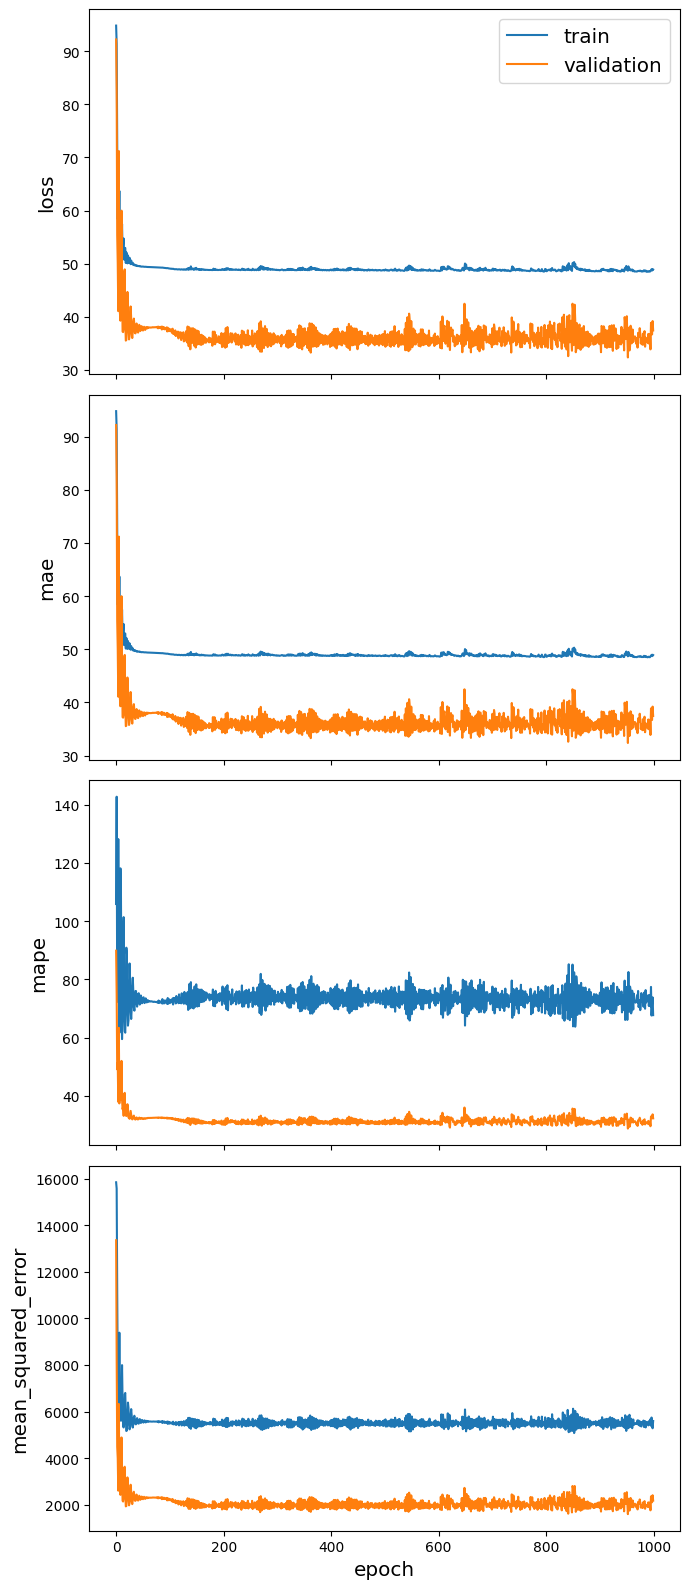

In [48]:
sg.utils.plot_history(history)

In [49]:
# [1]


# In[61]:


val_subjects, 
test_subjects


# In[62]:


test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))
    
    
#df_metrics = pd.DataFrame(columns=['Method', 'Loss', 'MSE', 'MAE', 'MAPE'])

temp = list()
temp.append('GCN-Spearman');
for name, val in zip(model.metrics_names, test_metrics):
    # print(val)
    temp.append(val)

print(temp)
df_metrics.loc[2] = temp
df_metrics

    


# # Show the predicted prices by the Model
# 
# At this point, I still need to make sense of what GCN ( and CNN) combination + MLP is predicting. 
# I am just displaying the output. 
# It appears that price is predicted for each timestamp (day)

# In[63]:


all_nodes = spearman_graph_node_data.index;
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

all_nodes, all_predictions, all_predictions.shape, spearman_graph_node_data.shape


# In[64]:


# https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict
model.predict(
    all_gen,
    batch_size = None,
    verbose = 2,
    steps = None,
    callbacks = None,
    max_queue_size = 10,
    workers = 1,
    use_multiprocessing = False
)


# In[65]:


# all_predictions = model.predict(all_nodes)

# all_predictions, all_predictions.shape, spearman_graph_node_data.shape
vars(all_gen)


# In[66]:


spearman_graph_node_data


# In[67]:


vars(all_gen)


# In[ ]:


# In[68]:


train_gen[:1][:4]


# In[ ]:



1/1 [==============================] - 0s 45ms/step - loss: 24.5669 - mean_squared_error: 1153.0258 - mae: 24.5669 - mape: 22.7411

Test Set Metrics:
	loss: 24.5669
	mean_squared_error: 1153.0258
	mae: 24.5669
	mape: 22.7411
['GCN-Spearman', 24.56689453125, 1153.0257568359375, 24.56689453125, 22.74113655090332]
1/1 [==============================] - 0s 101ms/step
1/1 - 0s - 33ms/epoch - 33ms/step


([array([[[ 29.0375,  29.005 ,  29.1525, ...,  72.4775,  72.45  ,
            72.88  ],
          [ 82.61  ,  84.66  ,  83.68  , ...,  85.05  ,  84.91  ,
            83.64  ],
          [ 37.6835,  37.859 ,  39.0225, ...,  93.4385,  93.49  ,
            92.3445],
          ...,
          [ 56.    ,  56.05  ,  55.18  , ...,  54.15  ,  53.92  ,
            53.6   ],
          [ 68.66  ,  69.06  ,  69.21  , ..., 119.52  , 119.59  ,
           119.4   ],
          [ 90.89  ,  89.89  ,  88.55  , ...,  70.13  ,  69.89  ,
            69.48  ]]], dtype=float32),
  array([[16,  7, 14, 23,  2, 13,  9,  3,  4, 12,  6, 11, 25,  0, 21, 24,
          18, 15, 26,  1, 20]], dtype=uint8),
  array([[[ 0,  0],
          [ 0,  2],
          [ 0,  3],
          [ 0,  4],
          [ 0,  6],
          [ 0,  8],
          [ 0, 12],
          [ 0, 13],
          [ 0, 14],
          [ 0, 17],
          [ 0, 19],
          [ 0, 21],
          [ 0, 22],
          [ 0, 23],
          [ 0, 26],
          [ 1,  1],

# Kendal Tau

StellarGraph: Undirected multigraph
 Nodes: 28, Edges: 278

 Node types:
  corner: [28]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [278]
        Weights: all 1 (default)
        Features: none
Using GCN (local pooling) filters...
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(1, 28, 753)]       0           []                               
                                                                                                  
 input_11 (InputLayer)          [(1, None, 2)]       0           []                               
                                                                                                  
 input_12 (InputLayer)          [(1, None)]          0           []                   

Epoch 22/1000
1/1 - 0s - loss: 45.5463 - mean_squared_error: 4963.1821 - mae: 45.5463 - mape: 66.5480 - val_loss: 63.7233 - val_mean_squared_error: 5200.5288 - val_mae: 63.7233 - val_mape: 77.8409 - 44ms/epoch - 44ms/step
Epoch 23/1000
1/1 - 0s - loss: 45.8751 - mean_squared_error: 4447.4004 - mae: 45.8751 - mape: 82.2104 - val_loss: 63.4288 - val_mean_squared_error: 5169.8716 - val_mae: 63.4288 - val_mape: 77.0335 - 43ms/epoch - 43ms/step
Epoch 24/1000
1/1 - 0s - loss: 45.5118 - mean_squared_error: 4451.8242 - mae: 45.5118 - mape: 81.1591 - val_loss: 58.5271 - val_mean_squared_error: 5202.0967 - val_mae: 58.5271 - val_mape: 61.8211 - 45ms/epoch - 45ms/step
Epoch 25/1000
1/1 - 0s - loss: 45.1465 - mean_squared_error: 4929.0444 - mae: 45.1465 - mape: 67.2485 - val_loss: 57.8841 - val_mean_squared_error: 5274.4751 - val_mae: 57.8841 - val_mape: 59.3875 - 46ms/epoch - 46ms/step
Epoch 26/1000
1/1 - 0s - loss: 45.6680 - mean_squared_error: 5084.7881 - mae: 45.6680 - mape: 65.3891 - val_loss

Epoch 59/1000
1/1 - 0s - loss: 43.6387 - mean_squared_error: 4488.8545 - mae: 43.6387 - mape: 70.9563 - val_loss: 60.9811 - val_mean_squared_error: 5081.5850 - val_mae: 60.9811 - val_mape: 67.8094 - 47ms/epoch - 47ms/step
Epoch 60/1000
1/1 - 0s - loss: 43.5993 - mean_squared_error: 4515.9072 - mae: 43.5993 - mape: 69.9076 - val_loss: 61.1371 - val_mean_squared_error: 5082.8965 - val_mae: 61.1371 - val_mape: 68.1560 - 47ms/epoch - 47ms/step
Epoch 61/1000
1/1 - 0s - loss: 43.5923 - mean_squared_error: 4496.3809 - mae: 43.5923 - mape: 70.3171 - val_loss: 61.3263 - val_mean_squared_error: 5091.6484 - val_mae: 61.3263 - val_mape: 68.7355 - 44ms/epoch - 44ms/step
Epoch 62/1000
1/1 - 0s - loss: 43.6653 - mean_squared_error: 4533.4346 - mae: 43.6653 - mape: 70.7477 - val_loss: 61.2285 - val_mean_squared_error: 5100.7222 - val_mae: 61.2285 - val_mape: 68.2121 - 47ms/epoch - 47ms/step
Epoch 63/1000
1/1 - 0s - loss: 43.6857 - mean_squared_error: 4477.4634 - mae: 43.6857 - mape: 70.6771 - val_loss

Epoch 96/1000
1/1 - 0s - loss: 43.5423 - mean_squared_error: 4565.7241 - mae: 43.5423 - mape: 69.0157 - val_loss: 61.9835 - val_mean_squared_error: 5082.1323 - val_mae: 61.9835 - val_mape: 71.0832 - 46ms/epoch - 46ms/step
Epoch 97/1000
1/1 - 0s - loss: 43.7009 - mean_squared_error: 4406.6978 - mae: 43.7009 - mape: 73.6549 - val_loss: 60.3827 - val_mean_squared_error: 5122.8818 - val_mae: 60.3827 - val_mape: 65.5782 - 43ms/epoch - 43ms/step
Epoch 98/1000
1/1 - 0s - loss: 43.6696 - mean_squared_error: 4629.3296 - mae: 43.6696 - mape: 68.1840 - val_loss: 61.5322 - val_mean_squared_error: 5082.3936 - val_mae: 61.5322 - val_mape: 69.6052 - 46ms/epoch - 46ms/step
Epoch 99/1000
1/1 - 0s - loss: 43.5662 - mean_squared_error: 4443.0996 - mae: 43.5662 - mape: 72.0034 - val_loss: 60.9489 - val_mean_squared_error: 5091.8813 - val_mae: 60.9489 - val_mape: 67.6373 - 45ms/epoch - 45ms/step
Epoch 100/1000
1/1 - 0s - loss: 43.5082 - mean_squared_error: 4511.2227 - mae: 43.5082 - mape: 70.0384 - val_los

Epoch 133/1000
1/1 - 0s - loss: 43.4945 - mean_squared_error: 4497.9790 - mae: 43.4945 - mape: 70.0873 - val_loss: 61.3134 - val_mean_squared_error: 5089.5420 - val_mae: 61.3134 - val_mape: 68.7893 - 52ms/epoch - 52ms/step
Epoch 134/1000
1/1 - 0s - loss: 43.4886 - mean_squared_error: 4480.4043 - mae: 43.4886 - mape: 70.9618 - val_loss: 60.5259 - val_mean_squared_error: 5116.2305 - val_mae: 60.5259 - val_mape: 66.0763 - 52ms/epoch - 52ms/step
Epoch 135/1000
1/1 - 0s - loss: 43.5929 - mean_squared_error: 4594.6372 - mae: 43.5929 - mape: 68.5535 - val_loss: 62.1697 - val_mean_squared_error: 5090.8115 - val_mae: 62.1697 - val_mape: 71.7328 - 48ms/epoch - 48ms/step
Epoch 136/1000
1/1 - 0s - loss: 43.7813 - mean_squared_error: 4367.5547 - mae: 43.7813 - mape: 74.0558 - val_loss: 60.7303 - val_mean_squared_error: 5112.9424 - val_mae: 60.7303 - val_mape: 66.7283 - 51ms/epoch - 51ms/step
Epoch 137/1000
1/1 - 0s - loss: 43.5644 - mean_squared_error: 4579.3867 - mae: 43.5644 - mape: 69.1246 - val

Epoch 170/1000
1/1 - 0s - loss: 43.7013 - mean_squared_error: 4574.6138 - mae: 43.7013 - mape: 70.9104 - val_loss: 61.0737 - val_mean_squared_error: 5098.1343 - val_mae: 61.0737 - val_mape: 67.9988 - 53ms/epoch - 53ms/step
Epoch 171/1000
1/1 - 0s - loss: 43.5414 - mean_squared_error: 4533.3516 - mae: 43.5414 - mape: 70.4734 - val_loss: 61.2847 - val_mean_squared_error: 5094.8877 - val_mae: 61.2847 - val_mape: 69.0272 - 49ms/epoch - 49ms/step
Epoch 172/1000
1/1 - 0s - loss: 43.6892 - mean_squared_error: 4432.9893 - mae: 43.6892 - mape: 71.5328 - val_loss: 59.9703 - val_mean_squared_error: 5137.7900 - val_mae: 59.9703 - val_mape: 64.4164 - 48ms/epoch - 48ms/step
Epoch 173/1000
1/1 - 0s - loss: 43.7790 - mean_squared_error: 4633.5669 - mae: 43.7790 - mape: 67.2301 - val_loss: 61.7269 - val_mean_squared_error: 5094.8486 - val_mae: 61.7269 - val_mape: 70.2620 - 50ms/epoch - 50ms/step
Epoch 174/1000
1/1 - 0s - loss: 43.6616 - mean_squared_error: 4416.8960 - mae: 43.6616 - mape: 72.9335 - val

Epoch 207/1000
1/1 - 0s - loss: 43.5437 - mean_squared_error: 4442.5249 - mae: 43.5437 - mape: 71.2077 - val_loss: 61.0076 - val_mean_squared_error: 5103.8252 - val_mae: 61.0076 - val_mape: 67.7689 - 48ms/epoch - 48ms/step
Epoch 208/1000
1/1 - 0s - loss: 43.5077 - mean_squared_error: 4494.3062 - mae: 43.5077 - mape: 69.5858 - val_loss: 60.8530 - val_mean_squared_error: 5108.9082 - val_mae: 60.8530 - val_mape: 67.1965 - 48ms/epoch - 48ms/step
Epoch 209/1000
1/1 - 0s - loss: 43.5024 - mean_squared_error: 4528.3096 - mae: 43.5024 - mape: 69.1264 - val_loss: 61.7389 - val_mean_squared_error: 5092.3667 - val_mae: 61.7389 - val_mape: 70.1861 - 45ms/epoch - 45ms/step
Epoch 210/1000
1/1 - 0s - loss: 43.5896 - mean_squared_error: 4426.8027 - mae: 43.5896 - mape: 72.2403 - val_loss: 60.2884 - val_mean_squared_error: 5140.0898 - val_mae: 60.2884 - val_mape: 65.1530 - 43ms/epoch - 43ms/step
Epoch 211/1000
1/1 - 0s - loss: 43.7105 - mean_squared_error: 4650.8145 - mae: 43.7105 - mape: 67.5251 - val

Epoch 244/1000
1/1 - 0s - loss: 44.1183 - mean_squared_error: 4296.8218 - mae: 44.1183 - mape: 76.9085 - val_loss: 61.1671 - val_mean_squared_error: 5099.2729 - val_mae: 61.1671 - val_mape: 68.4091 - 45ms/epoch - 45ms/step
Epoch 245/1000
1/1 - 0s - loss: 43.5218 - mean_squared_error: 4470.7817 - mae: 43.5218 - mape: 70.1815 - val_loss: 59.2101 - val_mean_squared_error: 5212.6250 - val_mae: 59.2101 - val_mape: 61.4941 - 44ms/epoch - 44ms/step
Epoch 246/1000
1/1 - 0s - loss: 44.3138 - mean_squared_error: 4817.7900 - mae: 44.3138 - mape: 64.3164 - val_loss: 62.8254 - val_mean_squared_error: 5109.2158 - val_mae: 62.8254 - val_mape: 73.9132 - 46ms/epoch - 46ms/step
Epoch 247/1000
1/1 - 0s - loss: 44.0285 - mean_squared_error: 4310.0942 - mae: 44.0285 - mape: 76.4510 - val_loss: 62.2101 - val_mean_squared_error: 5094.9971 - val_mae: 62.2101 - val_mape: 71.8540 - 43ms/epoch - 43ms/step
Epoch 248/1000
1/1 - 0s - loss: 43.7629 - mean_squared_error: 4364.2231 - mae: 43.7629 - mape: 74.2722 - val

Epoch 281/1000
1/1 - 0s - loss: 43.5299 - mean_squared_error: 4528.9429 - mae: 43.5299 - mape: 69.8534 - val_loss: 61.0558 - val_mean_squared_error: 5109.7764 - val_mae: 61.0558 - val_mape: 67.8488 - 45ms/epoch - 45ms/step
Epoch 282/1000
1/1 - 0s - loss: 43.5229 - mean_squared_error: 4487.9946 - mae: 43.5229 - mape: 69.6495 - val_loss: 61.1807 - val_mean_squared_error: 5106.9844 - val_mae: 61.1807 - val_mape: 68.2582 - 56ms/epoch - 56ms/step
Epoch 283/1000
1/1 - 0s - loss: 43.5025 - mean_squared_error: 4475.9048 - mae: 43.5025 - mape: 70.1579 - val_loss: 61.1540 - val_mean_squared_error: 5101.1631 - val_mae: 61.1540 - val_mape: 68.0773 - 56ms/epoch - 56ms/step
Epoch 284/1000
1/1 - 0s - loss: 43.5093 - mean_squared_error: 4531.8701 - mae: 43.5093 - mape: 70.1920 - val_loss: 61.2727 - val_mean_squared_error: 5096.6768 - val_mae: 61.2727 - val_mape: 68.5293 - 52ms/epoch - 52ms/step
Epoch 285/1000
1/1 - 0s - loss: 43.4820 - mean_squared_error: 4504.1787 - mae: 43.4820 - mape: 70.7299 - val

Epoch 318/1000
1/1 - 0s - loss: 43.5900 - mean_squared_error: 4567.9741 - mae: 43.5900 - mape: 67.6146 - val_loss: 62.0811 - val_mean_squared_error: 5095.8467 - val_mae: 62.0811 - val_mape: 71.4520 - 45ms/epoch - 45ms/step
Epoch 319/1000
1/1 - 0s - loss: 43.6713 - mean_squared_error: 4376.9072 - mae: 43.6713 - mape: 73.2274 - val_loss: 61.3213 - val_mean_squared_error: 5105.1104 - val_mae: 61.3213 - val_mape: 68.7706 - 48ms/epoch - 48ms/step
Epoch 320/1000
1/1 - 0s - loss: 43.5058 - mean_squared_error: 4483.5884 - mae: 43.5058 - mape: 70.3457 - val_loss: 60.0751 - val_mean_squared_error: 5152.2192 - val_mae: 60.0751 - val_mape: 64.4855 - 42ms/epoch - 42ms/step
Epoch 321/1000
1/1 - 0s - loss: 43.7728 - mean_squared_error: 4663.6035 - mae: 43.7728 - mape: 66.3764 - val_loss: 62.3646 - val_mean_squared_error: 5100.6240 - val_mae: 62.3646 - val_mape: 72.4492 - 44ms/epoch - 44ms/step
Epoch 322/1000
1/1 - 0s - loss: 43.8023 - mean_squared_error: 4341.7197 - mae: 43.8023 - mape: 74.3963 - val

Epoch 355/1000
1/1 - 0s - loss: 43.4652 - mean_squared_error: 4488.8086 - mae: 43.4652 - mape: 69.7621 - val_loss: 61.4546 - val_mean_squared_error: 5103.7061 - val_mae: 61.4546 - val_mape: 69.2156 - 46ms/epoch - 46ms/step
Epoch 356/1000
1/1 - 0s - loss: 43.4896 - mean_squared_error: 4442.5679 - mae: 43.4896 - mape: 71.0790 - val_loss: 60.5971 - val_mean_squared_error: 5136.3096 - val_mae: 60.5971 - val_mape: 66.1152 - 47ms/epoch - 47ms/step
Epoch 357/1000
1/1 - 0s - loss: 43.5477 - mean_squared_error: 4588.9414 - mae: 43.5477 - mape: 68.0867 - val_loss: 61.8662 - val_mean_squared_error: 5105.7827 - val_mae: 61.8662 - val_mape: 70.4639 - 52ms/epoch - 52ms/step
Epoch 358/1000
1/1 - 0s - loss: 43.5584 - mean_squared_error: 4424.7705 - mae: 43.5584 - mape: 72.5239 - val_loss: 60.8142 - val_mean_squared_error: 5122.7988 - val_mae: 60.8142 - val_mape: 66.9488 - 51ms/epoch - 51ms/step
Epoch 359/1000
1/1 - 0s - loss: 43.4720 - mean_squared_error: 4539.0615 - mae: 43.4720 - mape: 68.9355 - val

Epoch 392/1000
1/1 - 0s - loss: 43.7218 - mean_squared_error: 4666.9121 - mae: 43.7218 - mape: 67.1483 - val_loss: 61.4523 - val_mean_squared_error: 5096.6064 - val_mae: 61.4523 - val_mape: 69.2280 - 45ms/epoch - 45ms/step
Epoch 393/1000
1/1 - 0s - loss: 43.4940 - mean_squared_error: 4452.7979 - mae: 43.4940 - mape: 71.1700 - val_loss: 61.6182 - val_mean_squared_error: 5096.4741 - val_mae: 61.6182 - val_mape: 69.8816 - 47ms/epoch - 47ms/step
Epoch 394/1000
1/1 - 0s - loss: 43.5456 - mean_squared_error: 4406.5879 - mae: 43.5456 - mape: 71.7344 - val_loss: 60.3281 - val_mean_squared_error: 5125.8545 - val_mae: 60.3281 - val_mape: 65.4674 - 56ms/epoch - 56ms/step
Epoch 395/1000
1/1 - 0s - loss: 43.5943 - mean_squared_error: 4582.7695 - mae: 43.5943 - mape: 67.2885 - val_loss: 61.5209 - val_mean_squared_error: 5086.8936 - val_mae: 61.5209 - val_mape: 69.5656 - 68ms/epoch - 68ms/step
Epoch 396/1000
1/1 - 0s - loss: 43.4976 - mean_squared_error: 4454.8008 - mae: 43.4976 - mape: 71.2353 - val

Epoch 429/1000
1/1 - 0s - loss: 43.4547 - mean_squared_error: 4473.5059 - mae: 43.4547 - mape: 69.3846 - val_loss: 59.6780 - val_mean_squared_error: 5207.7012 - val_mae: 59.6780 - val_mape: 62.9405 - 54ms/epoch - 54ms/step
Epoch 430/1000
1/1 - 0s - loss: 44.1484 - mean_squared_error: 4795.0215 - mae: 44.1484 - mape: 65.0943 - val_loss: 63.2045 - val_mean_squared_error: 5117.3574 - val_mae: 63.2045 - val_mape: 75.1334 - 58ms/epoch - 58ms/step
Epoch 431/1000
1/1 - 0s - loss: 44.1594 - mean_squared_error: 4332.1958 - mae: 44.1594 - mape: 77.8643 - val_loss: 61.6610 - val_mean_squared_error: 5100.7197 - val_mae: 61.6610 - val_mape: 69.9839 - 50ms/epoch - 50ms/step
Epoch 432/1000
1/1 - 0s - loss: 43.5470 - mean_squared_error: 4415.3940 - mae: 43.5470 - mape: 72.1957 - val_loss: 58.8688 - val_mean_squared_error: 5240.9023 - val_mae: 58.8688 - val_mape: 60.3412 - 48ms/epoch - 48ms/step
Epoch 433/1000
1/1 - 0s - loss: 44.5446 - mean_squared_error: 4822.6646 - mae: 44.5446 - mape: 63.1188 - val

Epoch 466/1000
1/1 - 0s - loss: 43.5868 - mean_squared_error: 4616.0693 - mae: 43.5868 - mape: 67.4558 - val_loss: 61.7637 - val_mean_squared_error: 5119.9546 - val_mae: 61.7637 - val_mape: 69.9729 - 48ms/epoch - 48ms/step
Epoch 467/1000
1/1 - 0s - loss: 43.5559 - mean_squared_error: 4440.9385 - mae: 43.5559 - mape: 72.2612 - val_loss: 61.0926 - val_mean_squared_error: 5130.7212 - val_mae: 61.0926 - val_mape: 67.7804 - 47ms/epoch - 47ms/step
Epoch 468/1000
1/1 - 0s - loss: 43.4268 - mean_squared_error: 4503.2432 - mae: 43.4268 - mape: 69.6934 - val_loss: 60.4638 - val_mean_squared_error: 5133.0664 - val_mae: 60.4638 - val_mape: 66.0058 - 44ms/epoch - 44ms/step
Epoch 469/1000
1/1 - 0s - loss: 43.5153 - mean_squared_error: 4552.9746 - mae: 43.5153 - mape: 67.7251 - val_loss: 61.9265 - val_mean_squared_error: 5114.2778 - val_mae: 61.9265 - val_mape: 71.0110 - 48ms/epoch - 48ms/step
Epoch 470/1000
1/1 - 0s - loss: 43.6745 - mean_squared_error: 4366.9033 - mae: 43.6745 - mape: 73.0623 - val

Epoch 503/1000
1/1 - 0s - loss: 43.6500 - mean_squared_error: 4363.4556 - mae: 43.6500 - mape: 73.5052 - val_loss: 60.6149 - val_mean_squared_error: 5131.7720 - val_mae: 60.6149 - val_mape: 66.5022 - 48ms/epoch - 48ms/step
Epoch 504/1000
1/1 - 0s - loss: 43.4651 - mean_squared_error: 4538.7959 - mae: 43.4651 - mape: 67.8340 - val_loss: 60.7461 - val_mean_squared_error: 5135.7495 - val_mae: 60.7461 - val_mape: 66.7715 - 46ms/epoch - 46ms/step
Epoch 505/1000
1/1 - 0s - loss: 43.4059 - mean_squared_error: 4537.5278 - mae: 43.4059 - mape: 68.1964 - val_loss: 62.2244 - val_mean_squared_error: 5127.9062 - val_mae: 62.2244 - val_mape: 71.4695 - 47ms/epoch - 47ms/step
Epoch 506/1000
1/1 - 0s - loss: 43.6610 - mean_squared_error: 4385.2280 - mae: 43.6610 - mape: 73.6975 - val_loss: 60.2195 - val_mean_squared_error: 5185.8467 - val_mae: 60.2195 - val_mape: 64.5309 - 50ms/epoch - 50ms/step
Epoch 507/1000
1/1 - 0s - loss: 43.6914 - mean_squared_error: 4669.6318 - mae: 43.6914 - mape: 66.3720 - val

Epoch 540/1000
1/1 - 0s - loss: 43.7669 - mean_squared_error: 4376.9531 - mae: 43.7669 - mape: 74.5197 - val_loss: 59.9918 - val_mean_squared_error: 5180.4897 - val_mae: 59.9918 - val_mape: 63.8808 - 57ms/epoch - 57ms/step
Epoch 541/1000
1/1 - 0s - loss: 43.7568 - mean_squared_error: 4699.3384 - mae: 43.7568 - mape: 66.1548 - val_loss: 61.7251 - val_mean_squared_error: 5106.5322 - val_mae: 61.7251 - val_mape: 70.1537 - 63ms/epoch - 63ms/step
Epoch 542/1000
1/1 - 0s - loss: 43.5200 - mean_squared_error: 4406.6987 - mae: 43.5200 - mape: 72.1495 - val_loss: 60.7006 - val_mean_squared_error: 5114.7075 - val_mae: 60.7006 - val_mape: 66.9963 - 61ms/epoch - 61ms/step
Epoch 543/1000
1/1 - 0s - loss: 43.4350 - mean_squared_error: 4498.8320 - mae: 43.4350 - mape: 68.3081 - val_loss: 60.7234 - val_mean_squared_error: 5114.0811 - val_mae: 60.7234 - val_mape: 67.0212 - 54ms/epoch - 54ms/step
Epoch 544/1000
1/1 - 0s - loss: 43.4046 - mean_squared_error: 4500.5713 - mae: 43.4046 - mape: 68.3996 - val

Epoch 577/1000
1/1 - 0s - loss: 43.5435 - mean_squared_error: 4493.0479 - mae: 43.5435 - mape: 71.5035 - val_loss: 59.2766 - val_mean_squared_error: 5218.4409 - val_mae: 59.2766 - val_mape: 61.6812 - 50ms/epoch - 50ms/step
Epoch 578/1000
1/1 - 0s - loss: 44.1561 - mean_squared_error: 4782.6274 - mae: 44.1561 - mape: 63.6054 - val_loss: 63.3377 - val_mean_squared_error: 5155.5532 - val_mae: 63.3377 - val_mape: 75.7553 - 51ms/epoch - 51ms/step
Epoch 579/1000
1/1 - 0s - loss: 44.3562 - mean_squared_error: 4247.6030 - mae: 44.3562 - mape: 78.1302 - val_loss: 61.3611 - val_mean_squared_error: 5107.3120 - val_mae: 61.3611 - val_mape: 69.4663 - 48ms/epoch - 48ms/step
Epoch 580/1000
1/1 - 0s - loss: 43.6181 - mean_squared_error: 4387.7832 - mae: 43.6181 - mape: 70.3954 - val_loss: 59.1594 - val_mean_squared_error: 5228.7275 - val_mae: 59.1594 - val_mape: 61.2661 - 47ms/epoch - 47ms/step
Epoch 581/1000
1/1 - 0s - loss: 44.3979 - mean_squared_error: 4812.9980 - mae: 44.3979 - mape: 62.9040 - val

Epoch 614/1000
1/1 - 0s - loss: 43.3734 - mean_squared_error: 4471.1396 - mae: 43.3734 - mape: 70.2603 - val_loss: 60.9729 - val_mean_squared_error: 5113.3818 - val_mae: 60.9729 - val_mape: 67.5397 - 44ms/epoch - 44ms/step
Epoch 615/1000
1/1 - 0s - loss: 43.3740 - mean_squared_error: 4523.6182 - mae: 43.3740 - mape: 69.9349 - val_loss: 61.2504 - val_mean_squared_error: 5107.8203 - val_mae: 61.2504 - val_mape: 68.4030 - 48ms/epoch - 48ms/step
Epoch 616/1000
1/1 - 0s - loss: 43.3919 - mean_squared_error: 4500.1211 - mae: 43.3919 - mape: 70.9008 - val_loss: 60.6484 - val_mean_squared_error: 5122.1509 - val_mae: 60.6484 - val_mape: 66.5249 - 46ms/epoch - 46ms/step
Epoch 617/1000
1/1 - 0s - loss: 43.3965 - mean_squared_error: 4556.0303 - mae: 43.3965 - mape: 68.6482 - val_loss: 61.6908 - val_mean_squared_error: 5099.8481 - val_mae: 61.6908 - val_mape: 70.1923 - 45ms/epoch - 45ms/step
Epoch 618/1000
1/1 - 0s - loss: 43.5083 - mean_squared_error: 4404.8037 - mae: 43.5083 - mape: 72.2482 - val

Epoch 651/1000
1/1 - 0s - loss: 43.3675 - mean_squared_error: 4457.9087 - mae: 43.3675 - mape: 69.5913 - val_loss: 59.8316 - val_mean_squared_error: 5153.8149 - val_mae: 59.8316 - val_mape: 63.9190 - 52ms/epoch - 52ms/step
Epoch 652/1000
1/1 - 0s - loss: 43.7412 - mean_squared_error: 4661.8711 - mae: 43.7412 - mape: 65.0865 - val_loss: 62.6933 - val_mean_squared_error: 5100.1748 - val_mae: 62.6933 - val_mape: 73.5747 - 52ms/epoch - 52ms/step
Epoch 653/1000
1/1 - 0s - loss: 43.9271 - mean_squared_error: 4312.9961 - mae: 43.9271 - mape: 76.1819 - val_loss: 60.7340 - val_mean_squared_error: 5105.3037 - val_mae: 60.7340 - val_mape: 66.9487 - 55ms/epoch - 55ms/step
Epoch 654/1000
1/1 - 0s - loss: 43.3675 - mean_squared_error: 4517.0737 - mae: 43.3675 - mape: 68.7097 - val_loss: 59.3417 - val_mean_squared_error: 5194.1284 - val_mae: 59.3417 - val_mape: 61.9939 - 63ms/epoch - 63ms/step
Epoch 655/1000
1/1 - 0s - loss: 43.9469 - mean_squared_error: 4765.2056 - mae: 43.9469 - mape: 64.2495 - val

Epoch 688/1000
1/1 - 0s - loss: 43.4952 - mean_squared_error: 4615.6333 - mae: 43.4952 - mape: 66.6223 - val_loss: 62.0391 - val_mean_squared_error: 5099.8452 - val_mae: 62.0391 - val_mape: 71.1310 - 50ms/epoch - 50ms/step
Epoch 689/1000
1/1 - 0s - loss: 43.5793 - mean_squared_error: 4390.2881 - mae: 43.5793 - mape: 73.3340 - val_loss: 60.4928 - val_mean_squared_error: 5131.4736 - val_mae: 60.4928 - val_mape: 65.9533 - 57ms/epoch - 57ms/step
Epoch 690/1000
1/1 - 0s - loss: 43.3873 - mean_squared_error: 4572.0840 - mae: 43.3873 - mape: 67.3928 - val_loss: 61.2093 - val_mean_squared_error: 5107.0303 - val_mae: 61.2093 - val_mape: 68.4417 - 49ms/epoch - 49ms/step
Epoch 691/1000
1/1 - 0s - loss: 43.3147 - mean_squared_error: 4465.5317 - mae: 43.3147 - mape: 69.8272 - val_loss: 61.0968 - val_mean_squared_error: 5109.6201 - val_mae: 61.0968 - val_mape: 68.0374 - 47ms/epoch - 47ms/step
Epoch 692/1000
1/1 - 0s - loss: 43.2864 - mean_squared_error: 4477.8208 - mae: 43.2864 - mape: 69.4722 - val

Epoch 725/1000
1/1 - 0s - loss: 44.1191 - mean_squared_error: 4811.1709 - mae: 44.1191 - mape: 63.9220 - val_loss: 63.1663 - val_mean_squared_error: 5112.3140 - val_mae: 63.1663 - val_mape: 74.7061 - 46ms/epoch - 46ms/step
Epoch 726/1000
1/1 - 0s - loss: 44.4826 - mean_squared_error: 4417.7153 - mae: 44.4826 - mape: 79.6151 - val_loss: 60.0473 - val_mean_squared_error: 5148.2886 - val_mae: 60.0473 - val_mape: 64.7702 - 45ms/epoch - 45ms/step
Epoch 727/1000
1/1 - 0s - loss: 43.5943 - mean_squared_error: 4631.9053 - mae: 43.5943 - mape: 66.1316 - val_loss: 60.3526 - val_mean_squared_error: 5133.8345 - val_mae: 60.3526 - val_mape: 66.2113 - 46ms/epoch - 46ms/step
Epoch 728/1000
1/1 - 0s - loss: 43.7300 - mean_squared_error: 4534.8018 - mae: 43.7300 - mape: 66.6141 - val_loss: 62.3540 - val_mean_squared_error: 5126.6001 - val_mae: 62.3540 - val_mape: 73.0922 - 47ms/epoch - 47ms/step
Epoch 729/1000
1/1 - 0s - loss: 43.8493 - mean_squared_error: 4292.7388 - mae: 43.8493 - mape: 74.4646 - val

Epoch 762/1000
1/1 - 0s - loss: 43.3880 - mean_squared_error: 4455.2148 - mae: 43.3880 - mape: 71.5287 - val_loss: 60.3775 - val_mean_squared_error: 5135.5400 - val_mae: 60.3775 - val_mape: 65.5407 - 45ms/epoch - 45ms/step
Epoch 763/1000
1/1 - 0s - loss: 43.3712 - mean_squared_error: 4584.8931 - mae: 43.3712 - mape: 67.3262 - val_loss: 61.5595 - val_mean_squared_error: 5100.2646 - val_mae: 61.5595 - val_mape: 69.7396 - 47ms/epoch - 47ms/step
Epoch 764/1000
1/1 - 0s - loss: 43.3820 - mean_squared_error: 4408.8867 - mae: 43.3820 - mape: 71.5651 - val_loss: 60.3588 - val_mean_squared_error: 5128.5142 - val_mae: 60.3588 - val_mape: 65.7003 - 46ms/epoch - 46ms/step
Epoch 765/1000
1/1 - 0s - loss: 43.3823 - mean_squared_error: 4561.0010 - mae: 43.3823 - mape: 67.0464 - val_loss: 61.5182 - val_mean_squared_error: 5099.3613 - val_mae: 61.5182 - val_mape: 69.6070 - 46ms/epoch - 46ms/step
Epoch 766/1000
1/1 - 0s - loss: 43.3531 - mean_squared_error: 4416.4688 - mae: 43.3531 - mape: 71.4564 - val

Epoch 799/1000
1/1 - 0s - loss: 43.2194 - mean_squared_error: 4492.2383 - mae: 43.2194 - mape: 68.2198 - val_loss: 61.3500 - val_mean_squared_error: 5096.5757 - val_mae: 61.3500 - val_mape: 68.9211 - 44ms/epoch - 44ms/step
Epoch 800/1000
1/1 - 0s - loss: 43.2741 - mean_squared_error: 4447.2329 - mae: 43.2741 - mape: 70.9033 - val_loss: 59.4119 - val_mean_squared_error: 5208.7236 - val_mae: 59.4119 - val_mape: 62.0169 - 45ms/epoch - 45ms/step
Epoch 801/1000
1/1 - 0s - loss: 43.9254 - mean_squared_error: 4784.1279 - mae: 43.9254 - mape: 64.6756 - val_loss: 63.2132 - val_mean_squared_error: 5106.2212 - val_mae: 63.2132 - val_mape: 75.0631 - 47ms/epoch - 47ms/step
Epoch 802/1000
1/1 - 0s - loss: 44.4864 - mean_squared_error: 4329.7812 - mae: 44.4864 - mape: 79.7657 - val_loss: 59.8097 - val_mean_squared_error: 5208.1904 - val_mae: 59.8097 - val_mape: 63.3893 - 46ms/epoch - 46ms/step
Epoch 803/1000
1/1 - 0s - loss: 44.6279 - mean_squared_error: 4725.2046 - mae: 44.6279 - mape: 62.5020 - val

Epoch 836/1000
1/1 - 0s - loss: 43.4092 - mean_squared_error: 4607.7388 - mae: 43.4092 - mape: 66.6963 - val_loss: 62.2994 - val_mean_squared_error: 5097.3315 - val_mae: 62.2994 - val_mape: 72.3019 - 53ms/epoch - 53ms/step
Epoch 837/1000
1/1 - 0s - loss: 43.6581 - mean_squared_error: 4331.6704 - mae: 43.6581 - mape: 74.1776 - val_loss: 60.7842 - val_mean_squared_error: 5110.9912 - val_mae: 60.7842 - val_mape: 67.2888 - 46ms/epoch - 46ms/step
Epoch 838/1000
1/1 - 0s - loss: 43.3618 - mean_squared_error: 4480.0791 - mae: 43.3618 - mape: 67.8234 - val_loss: 60.1047 - val_mean_squared_error: 5142.4448 - val_mae: 60.1047 - val_mape: 64.8270 - 55ms/epoch - 55ms/step
Epoch 839/1000
1/1 - 0s - loss: 43.5673 - mean_squared_error: 4597.5942 - mae: 43.5673 - mape: 65.4945 - val_loss: 62.5304 - val_mean_squared_error: 5101.5117 - val_mae: 62.5304 - val_mape: 73.0331 - 47ms/epoch - 47ms/step
Epoch 840/1000
1/1 - 0s - loss: 43.8006 - mean_squared_error: 4320.2070 - mae: 43.8006 - mape: 75.3755 - val

Epoch 873/1000
1/1 - 0s - loss: 43.4006 - mean_squared_error: 4392.7446 - mae: 43.4006 - mape: 71.6040 - val_loss: 61.6048 - val_mean_squared_error: 5084.5962 - val_mae: 61.6048 - val_mape: 70.0492 - 51ms/epoch - 51ms/step
Epoch 874/1000
1/1 - 0s - loss: 43.4149 - mean_squared_error: 4388.7793 - mae: 43.4149 - mape: 71.9871 - val_loss: 59.7427 - val_mean_squared_error: 5149.7446 - val_mae: 59.7427 - val_mape: 63.5609 - 52ms/epoch - 52ms/step
Epoch 875/1000
1/1 - 0s - loss: 43.6048 - mean_squared_error: 4663.3242 - mae: 43.6048 - mape: 65.3060 - val_loss: 60.9303 - val_mean_squared_error: 5092.0801 - val_mae: 60.9303 - val_mape: 67.6223 - 53ms/epoch - 53ms/step
Epoch 876/1000
1/1 - 0s - loss: 43.2766 - mean_squared_error: 4493.6963 - mae: 43.2766 - mape: 69.5074 - val_loss: 61.9345 - val_mean_squared_error: 5078.1313 - val_mae: 61.9345 - val_mape: 70.9977 - 54ms/epoch - 54ms/step
Epoch 877/1000
1/1 - 0s - loss: 43.5358 - mean_squared_error: 4384.6772 - mae: 43.5358 - mape: 73.4309 - val

Epoch 910/1000
1/1 - 0s - loss: 43.4194 - mean_squared_error: 4545.2886 - mae: 43.4194 - mape: 66.2921 - val_loss: 60.7642 - val_mean_squared_error: 5105.4150 - val_mae: 60.7642 - val_mape: 67.4274 - 55ms/epoch - 55ms/step
Epoch 911/1000
1/1 - 0s - loss: 43.4008 - mean_squared_error: 4475.5991 - mae: 43.4008 - mape: 67.5741 - val_loss: 61.5135 - val_mean_squared_error: 5086.2686 - val_mae: 61.5135 - val_mape: 69.8526 - 64ms/epoch - 64ms/step
Epoch 912/1000
1/1 - 0s - loss: 43.3189 - mean_squared_error: 4405.2021 - mae: 43.3189 - mape: 70.8716 - val_loss: 60.7391 - val_mean_squared_error: 5106.5732 - val_mae: 60.7391 - val_mape: 66.8589 - 58ms/epoch - 58ms/step
Epoch 913/1000
1/1 - 0s - loss: 43.2935 - mean_squared_error: 4555.8892 - mae: 43.2935 - mape: 68.8262 - val_loss: 60.5346 - val_mean_squared_error: 5115.8813 - val_mae: 60.5346 - val_mape: 66.0610 - 55ms/epoch - 55ms/step
Epoch 914/1000
1/1 - 0s - loss: 43.3449 - mean_squared_error: 4592.2822 - mae: 43.3449 - mape: 68.5383 - val

Epoch 947/1000
1/1 - 0s - loss: 43.5022 - mean_squared_error: 4357.2085 - mae: 43.5022 - mape: 73.4791 - val_loss: 60.0066 - val_mean_squared_error: 5140.0747 - val_mae: 60.0066 - val_mape: 64.4365 - 47ms/epoch - 47ms/step
Epoch 948/1000
1/1 - 0s - loss: 43.4225 - mean_squared_error: 4631.1416 - mae: 43.4225 - mape: 65.5514 - val_loss: 61.5637 - val_mean_squared_error: 5076.9155 - val_mae: 61.5637 - val_mape: 69.8454 - 47ms/epoch - 47ms/step
Epoch 949/1000
1/1 - 0s - loss: 43.3284 - mean_squared_error: 4416.5386 - mae: 43.3284 - mape: 72.0768 - val_loss: 60.3576 - val_mean_squared_error: 5111.6870 - val_mae: 60.3576 - val_mape: 65.7540 - 51ms/epoch - 51ms/step
Epoch 950/1000
1/1 - 0s - loss: 43.2262 - mean_squared_error: 4557.5229 - mae: 43.2262 - mape: 66.7604 - val_loss: 61.0296 - val_mean_squared_error: 5083.4834 - val_mae: 61.0296 - val_mape: 68.1593 - 46ms/epoch - 46ms/step
Epoch 951/1000
1/1 - 0s - loss: 43.1602 - mean_squared_error: 4450.0376 - mae: 43.1602 - mape: 69.2496 - val

Epoch 984/1000
1/1 - 0s - loss: 43.4780 - mean_squared_error: 4354.6147 - mae: 43.4780 - mape: 73.0632 - val_loss: 59.9796 - val_mean_squared_error: 5131.3540 - val_mae: 59.9796 - val_mape: 64.6947 - 47ms/epoch - 47ms/step
Epoch 985/1000
1/1 - 0s - loss: 43.5171 - mean_squared_error: 4609.9414 - mae: 43.5171 - mape: 65.5180 - val_loss: 60.2217 - val_mean_squared_error: 5117.1680 - val_mae: 60.2217 - val_mape: 65.4381 - 45ms/epoch - 45ms/step
Epoch 986/1000
1/1 - 0s - loss: 43.3445 - mean_squared_error: 4577.2593 - mae: 43.3445 - mape: 66.6995 - val_loss: 61.8984 - val_mean_squared_error: 5076.4814 - val_mae: 61.8984 - val_mape: 70.9931 - 44ms/epoch - 44ms/step
Epoch 987/1000
1/1 - 0s - loss: 43.5851 - mean_squared_error: 4389.5488 - mae: 43.5851 - mape: 74.0389 - val_loss: 60.8768 - val_mean_squared_error: 5092.0825 - val_mae: 60.8768 - val_mape: 67.4075 - 49ms/epoch - 49ms/step
Epoch 988/1000
1/1 - 0s - loss: 43.2598 - mean_squared_error: 4507.2241 - mae: 43.2598 - mape: 69.8581 - val

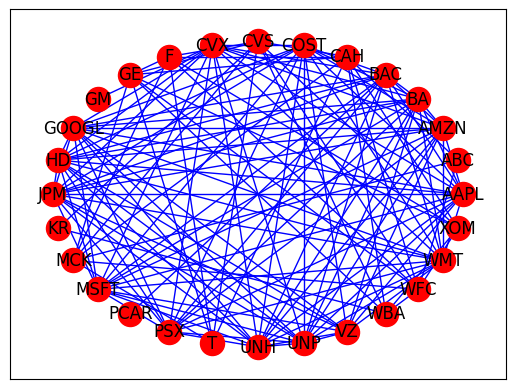

In [50]:
# kendall_tau

df_s_transpose_kendall_tau = df_s_transpose.corr(method = 'kendall', numeric_only = True)
df_s_transpose_kendall_tau


# # kendall_tau Correlation Coefficient based Adjacency Graph Matrix

# In[32]:


df_s_transpose_kendall_tau[df_s_transpose_kendall_tau >= 0.3] = 1
df_s_transpose_kendall_tau[df_s_transpose_kendall_tau < 0.3] = 0
df_s_transpose_kendall_tau


# In[33]:


# make the diagonal element to be zero. No self loop
import numpy as np
np.fill_diagonal(df_s_transpose_kendall_tau.values, 0)
df_s_transpose_kendall_tau


# Create and visualize the Graphs

# In[34]:


import networkx as nx
Graph_kendall_tau = nx.Graph(df_s_transpose_kendall_tau)


# In[36]:


nx.draw_networkx(Graph_kendall_tau, pos=nx.circular_layout(Graph_kendall_tau), node_color='r', edge_color='b')


# # Create GCN layer. Graph_kendall_tau

# # Find all stocks = nodes

# In[37]:


# improvement: make sure only stocks/nodes that are in the graph are taken
all_stock_nodes = df_s_transpose_kendall_tau.index.to_list()
all_stock_nodes


# # Find all edges between nodes

# In[38]:


source = [];
target = [];
edge_feature = [];

for aStock in all_stock_nodes:
    for anotherStock in all_stock_nodes:
        if df_s_transpose_kendall_tau[aStock][anotherStock] > 0:
            #print(df_s_transpose_kendall_tau[aStock][anotherStock])
            source.append(aStock)
            target.append(anotherStock)
            edge_feature.append(1)
            
source, target, edge_feature            


# In[39]:


# https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
kendall_tau_edges = pd.DataFrame(
    {"source": source, "target": target}
)

kendall_tau_edges_data = pd.DataFrame(
    {"source": source, "target": target, "edge_feature": edge_feature}
)


kendall_tau_edges[:10]


# # Graph with No Feature Data, No node data, only edges

# kendall_tau_graph = StellarGraph(edges = kendall_tau_edges, node_type_default="corner", edge_type_default="line")
# #kendall_tau_graph = StellarGraph(nodes = all_stock_nodes, edges = kendall_tau_edges)
# # graph = sg.StellarGraph(all_stock_nodes, square_edges)
# print(kendall_tau_graph.info())

# In[40]:


# Trying to have the time series data as part of the nodes


# In[41]:


df_s_transpose


# # Structure the Feature Matrix so that it can be passed to the GCN

# In[43]:


df_s_transpose_feature = df_s_transpose.reset_index(drop = True, inplace = False)
# df_s_transpose_feature =  df_s_transpose_feature.values.tolist()
# print(df_s_transpose_feature.values.tolist())
#df_s_transpose_feature['WY'].values
df_s_transpose_feature['AAPL'].values


# In[44]:


node_Data = [];
for x in all_stock_nodes:
    node_Data.append( df_s_transpose_feature[x].values)
    
    
node_Data    


# In[45]:


kendall_tau_graph_node_data = pd.DataFrame(node_Data, index = all_stock_nodes)
kendall_tau_graph_node_data


# # Graph with feature as part of Nodes

# In[46]:


kendall_tau_graph_with_node_features = StellarGraph(kendall_tau_graph_node_data, edges = kendall_tau_edges, node_type_default = "corner", edge_type_default = "line")
print(kendall_tau_graph_with_node_features.info())


# In[47]:


# Generator
generator = FullBatchNodeGenerator(kendall_tau_graph_with_node_features, method = "gcn") # , sparse = False
vars(generator)


# # Train Test Split

# In[48]:


train_subjects, test_subjects = model_selection.train_test_split(
    kendall_tau_graph_node_data #, train_size = 6, test_size = 4
)
# , train_size=6, test_size=None, stratify=kendall_tau_graph_node_data

val_subjects, test_subjects_step_2 = model_selection.train_test_split(
    test_subjects #, test_size = 2
)

#, train_size = 500, test_size = None, stratify = test_subjects


train_subjects.shape, test_subjects.shape, val_subjects.shape, test_subjects_step_2.shape


# In[49]:


kendall_tau_graph_node_data


# In[50]:


train_targets = train_subjects; 
val_targets = val_subjects; 
test_targets = test_subjects; 


# In[51]:


train_gen = generator.flow(train_subjects.index, train_targets)


# In[52]:


# debug
train_subjects.index, 
train_targets


# In[53]:


# train data size
# it is not must to use a number like unit_count
unit_count = train_subjects.shape[0]
unit_count


# In[54]:


from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow import keras

layer_sizes = [32, 32]
activations = ["relu", "relu"]

gcn = GCN(layer_sizes = layer_sizes, activations = activations, generator = generator) #, dropout = 0.5
x_inp, x_out = gcn.in_out_tensors()

# MLP -- Regression
predictions = layers.Dense(units = train_targets.shape[1], activation = "linear")(x_out)
x_out, 
x_inp, x_out


# # hard coded size adjustments
# test_subjects_adjusted = test_subjects[:len(val_subjects)]
# 
# val_gen = generator.flow(val_subjects.index, test_subjects_adjusted)
# # train_gen[1], val_gen[1]

# In[55]:


# Models


# In[56]:


# loss functions: https://keras.io/api/losses/

model = Model(
    inputs = x_inp, outputs = predictions)

'''
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.1),
    loss=losses.MeanSquaredError(),
    metrics=["acc"],
)
'''

# REF: https://stackoverflow.com/questions/57301698/how-to-change-a-learning-rate-for-adam-in-tf2
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PolynomialDecay
train_steps = 1000
lr_fn = optimizers.schedules.PolynomialDecay(1e-3, train_steps, 1e-5, 2)


# https://keras.io/api/metrics/
model.compile(
    loss = 'mean_absolute_error', 
    optimizer = optimizers.Adam( lr_fn ),
    # metrics = ['mean_squared_error']
    metrics=['mse', 'mae', 'mape']
)

# mape: https://towardsdatascience.com/choosing-the-correct-error-metric-mape-vs-smape-5328dec53fac
model.compile( 
    loss = 'mean_absolute_error', 
    optimizer = optimizers.Adam(learning_rate = 0.015), 
    #optimizer = optimizers.Adam(lr_fn), 
    # metrics=['mean_squared_error']
    metrics=['mean_squared_error', 'mae', 'mape']
    # metrics=[
    #    metrics.MeanSquaredError(),
    #    metrics.AUC(),
    #]
)


# In[57]:


len(x_inp), predictions.shape, print(model.summary())


# In[58]:


len(val_subjects)
test_subjects_ = test_subjects[:len(val_subjects)]


# In[59]:


# hard coded size adjustments
test_subjects_ = test_subjects[:len(val_subjects)]

val_gen = generator.flow(val_subjects.index, test_subjects_)
#train_gen[1], val_gen[1]


# train_gen[:1][:4]

# In[60]:


# https://keras.io/api/callbacks/early_stopping/
from tensorflow.keras.callbacks import EarlyStopping

#epochs_to_test = 1000
#patience_to_test = 1000

es_callback = EarlyStopping(
    monitor = "val_mean_squared_error", 
    patience = patience_to_test, 
    restore_best_weights = True
)

data_valid = val_gen #[:1][:4];
train_gen_data = train_gen #[:1][:4];

history = model.fit( train_gen_data, epochs = epochs_to_test, validation_data = data_valid, verbose = 2,    
    # shuffling = true means shuffling the whole graph
    shuffle = False, callbacks = [es_callback],
)




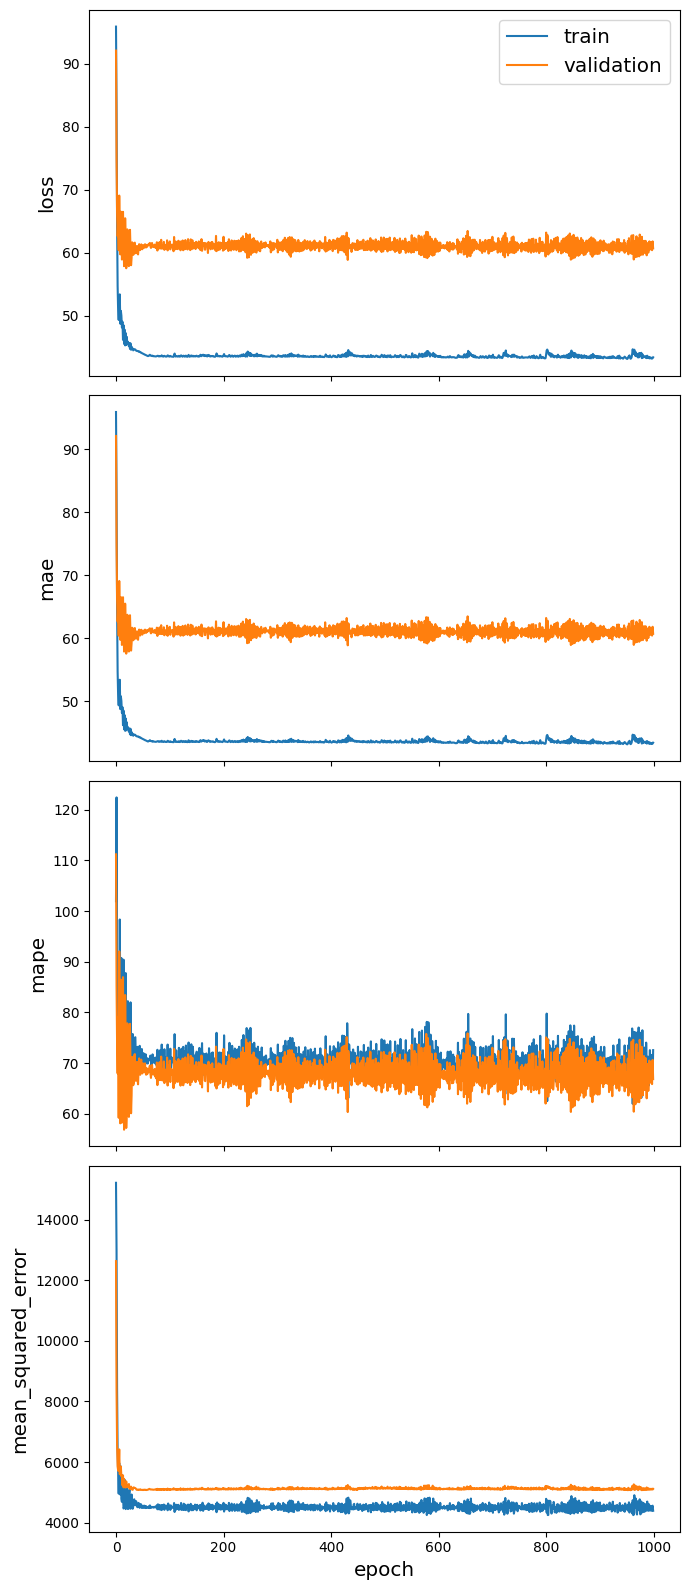

In [51]:
sg.utils.plot_history(history)

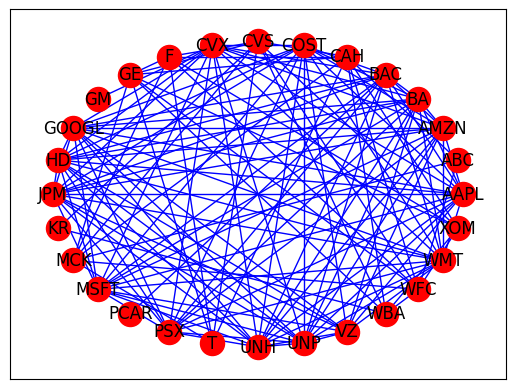

In [52]:
nx.draw_networkx(Graph_kendall_tau, pos=nx.circular_layout(Graph_kendall_tau), node_color='r', edge_color='b')

In [53]:
# [1]


# In[61]:


val_subjects, 
test_subjects


# In[62]:


test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))
    


# # Show the predicted prices by the Model
# 
# At this point, I still need to make sense of what GCN ( and CNN) combination + MLP is predicting. 
# I am just displaying the output. 
# It appears that price is predicted for each timestamp (day)

# In[63]:


all_nodes = kendall_tau_graph_node_data.index;
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

all_nodes, all_predictions, all_predictions.shape, kendall_tau_graph_node_data.shape


# In[64]:


# https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict
model.predict(
    all_gen,
    batch_size = None,
    verbose = 2,
    steps = None,
    callbacks = None,
    max_queue_size = 10,
    workers = 1,
    use_multiprocessing = False
)


# In[65]:


# all_predictions = model.predict(all_nodes)

# all_predictions, all_predictions.shape, kendall_tau_graph_node_data.shape
vars(all_gen)


# In[66]:


kendall_tau_graph_node_data


# In[67]:


vars(all_gen)


# In[ ]:


# In[68]:


train_gen[:1][:4]


# In[ ]:



1/1 [==============================] - 0s 38ms/step - loss: 37.7561 - mean_squared_error: 2384.2673 - mae: 37.7561 - mape: 41.0738

Test Set Metrics:
	loss: 37.7561
	mean_squared_error: 2384.2673
	mae: 37.7561
	mape: 41.0738
1/1 [==============================] - 0s 102ms/step
1/1 - 0s - 33ms/epoch - 33ms/step


([array([[[ 29.0375,  29.005 ,  29.1525, ...,  72.4775,  72.45  ,
            72.88  ],
          [ 82.61  ,  84.66  ,  83.68  , ...,  85.05  ,  84.91  ,
            83.64  ],
          [ 37.6835,  37.859 ,  39.0225, ...,  93.4385,  93.49  ,
            92.3445],
          ...,
          [ 56.    ,  56.05  ,  55.18  , ...,  54.15  ,  53.92  ,
            53.6   ],
          [ 68.66  ,  69.06  ,  69.21  , ..., 119.52  , 119.59  ,
           119.4   ],
          [ 90.89  ,  89.89  ,  88.55  , ...,  70.13  ,  69.89  ,
            69.48  ]]], dtype=float32),
  array([[ 0,  3,  6,  4, 24, 15, 19,  8,  7, 22, 26,  5, 21,  9, 27, 20,
          17,  1, 10, 25, 12]], dtype=uint8),
  array([[[ 0,  0],
          [ 0,  2],
          [ 0,  3],
          [ 0,  4],
          [ 0,  6],
          [ 0,  8],
          [ 0, 12],
          [ 0, 13],
          [ 0, 14],
          [ 0, 17],
          [ 0, 19],
          [ 0, 21],
          [ 0, 22],
          [ 0, 23],
          [ 0, 26],
          [ 1,  1],

In [54]:
# df_metrics = pd.DataFrame(columns=['Method', 'Loss', 'MSE', 'MAE', 'MAPE'])
# df_metrics = pd.DataFrame(columns=['Method', 'Loss', 'MSE', 'MAE', 'MAPE'])

temp = list()
temp.append('GCN-Kendall');
for name, val in zip(model.metrics_names, test_metrics):    
    temp.append(val)

print(temp)
df_metrics.loc[3] = temp


['GCN-Kendall', 37.75611114501953, 2384.267333984375, 37.75611114501953, 41.07376480102539]


In [55]:
# import math
df_metrics_plot = df_metrics[['Loss', 'MSE', 'MAE', 'MAPE']]

#temp = [10.71573, 13.578422, 10.71573, 16.638063]
#temp = [19.04899024963379, 1377.4075927734375, 19.04899024963379, 26.09033203125]
#df_metrics_plot.loc[4] = temp

df_metrics_plot['MSE'] = [ math.sqrt(x) for x in df_metrics_plot['MSE']]
df_metrics_plot
#df_metrics, df_metrics_plot

C:\Users\sayed\AppData\Local\Temp\ipykernel_40556\4000481403.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metrics_plot['MSE'] = [ math.sqrt(x) for x in df_metrics_plot['MSE']]


,Loss,MSE,MAE,MAPE
1,31.898991,38.588287,31.898991,52.818108
2,24.566895,33.956233,24.566895,22.741137
3,37.756111,48.828960,37.756111,41.073765


<Axes: >

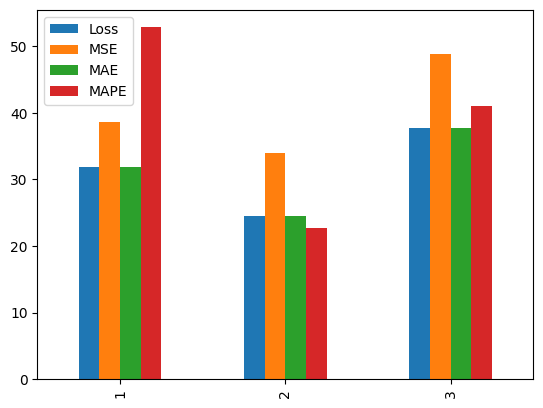

In [56]:
df_metrics_plot.plot( kind = 'bar')

# For the sake of easier execution, I have brought financial news based prediction in the same code file

StellarGraph: Undirected multigraph
 Nodes: 28, Edges: 21

 Node types:
  corner: [28]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [21]
        Weights: all 1 (default)
        Features: float32 vector, length 1
Using GCN (local pooling) filters...
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(1, 28, 753)]       0           []                               
                                                                                                  
 input_15 (InputLayer)          [(1, None, 2)]       0           []                               
                                                                                                  
 input_16 (InputLayer)          [(1, None)]          0           [] 

Epoch 22/1000
1/1 - 0s - loss: 29.5602 - mean_squared_error: 2121.2136 - mae: 29.5602 - mape: 31.4980 - val_loss: 43.1395 - val_mean_squared_error: 2558.5625 - val_mae: 43.1395 - val_mape: 85.3641 - 43ms/epoch - 43ms/step
Epoch 23/1000
1/1 - 0s - loss: 28.8004 - mean_squared_error: 2067.5520 - mae: 28.8004 - mape: 30.9357 - val_loss: 46.8237 - val_mean_squared_error: 3147.3726 - val_mae: 46.8237 - val_mape: 106.0045 - 44ms/epoch - 44ms/step
Epoch 24/1000
1/1 - 0s - loss: 28.3345 - mean_squared_error: 2193.5813 - mae: 28.3345 - mape: 34.5488 - val_loss: 47.2385 - val_mean_squared_error: 3225.1880 - val_mae: 47.2385 - val_mape: 108.2157 - 45ms/epoch - 45ms/step
Epoch 25/1000
1/1 - 0s - loss: 28.8742 - mean_squared_error: 2256.0688 - mae: 28.8742 - mape: 35.5238 - val_loss: 43.8948 - val_mean_squared_error: 2656.9456 - val_mae: 43.8948 - val_mape: 90.1414 - 46ms/epoch - 46ms/step
Epoch 26/1000
1/1 - 0s - loss: 26.4576 - mean_squared_error: 1927.3881 - mae: 26.4576 - mape: 29.5460 - val_lo

Epoch 59/1000
1/1 - 0s - loss: 20.5975 - mean_squared_error: 1540.1925 - mae: 20.5975 - mape: 24.5965 - val_loss: 44.2069 - val_mean_squared_error: 2754.5332 - val_mae: 44.2069 - val_mape: 92.5405 - 43ms/epoch - 43ms/step
Epoch 60/1000
1/1 - 0s - loss: 21.3250 - mean_squared_error: 1562.9801 - mae: 21.3250 - mape: 25.0921 - val_loss: 44.9106 - val_mean_squared_error: 2945.5325 - val_mae: 44.9106 - val_mape: 96.1111 - 43ms/epoch - 43ms/step
Epoch 61/1000
1/1 - 0s - loss: 22.3832 - mean_squared_error: 1617.6139 - mae: 22.3832 - mape: 26.9970 - val_loss: 44.3899 - val_mean_squared_error: 2785.4666 - val_mae: 44.3899 - val_mape: 93.4807 - 43ms/epoch - 43ms/step
Epoch 62/1000
1/1 - 0s - loss: 21.2292 - mean_squared_error: 1557.9072 - mae: 21.2292 - mape: 25.3111 - val_loss: 44.1843 - val_mean_squared_error: 2784.4434 - val_mae: 44.1843 - val_mape: 92.2377 - 45ms/epoch - 45ms/step
Epoch 63/1000
1/1 - 0s - loss: 20.5960 - mean_squared_error: 1537.4275 - mae: 20.5960 - mape: 24.2440 - val_loss

Epoch 96/1000
1/1 - 0s - loss: 22.2205 - mean_squared_error: 1574.4600 - mae: 22.2205 - mape: 25.7232 - val_loss: 45.6386 - val_mean_squared_error: 2983.3035 - val_mae: 45.6386 - val_mape: 96.5114 - 45ms/epoch - 45ms/step
Epoch 97/1000
1/1 - 0s - loss: 20.8223 - mean_squared_error: 1541.0330 - mae: 20.8223 - mape: 24.9570 - val_loss: 46.8387 - val_mean_squared_error: 3184.0566 - val_mae: 46.8387 - val_mape: 103.7549 - 44ms/epoch - 44ms/step
Epoch 98/1000
1/1 - 0s - loss: 21.8026 - mean_squared_error: 1611.0011 - mae: 21.8026 - mape: 27.5162 - val_loss: 44.5370 - val_mean_squared_error: 2769.9363 - val_mae: 44.5370 - val_mape: 90.8518 - 46ms/epoch - 46ms/step
Epoch 99/1000
1/1 - 0s - loss: 23.0414 - mean_squared_error: 1609.3220 - mae: 23.0414 - mape: 26.7399 - val_loss: 45.2950 - val_mean_squared_error: 2924.2117 - val_mae: 45.2950 - val_mape: 95.3264 - 46ms/epoch - 46ms/step
Epoch 100/1000
1/1 - 0s - loss: 20.3241 - mean_squared_error: 1518.9229 - mae: 20.3241 - mape: 24.4654 - val_lo

Epoch 133/1000
1/1 - 0s - loss: 20.2839 - mean_squared_error: 1508.9470 - mae: 20.2839 - mape: 24.3693 - val_loss: 46.8652 - val_mean_squared_error: 3206.4351 - val_mae: 46.8652 - val_mape: 102.8151 - 56ms/epoch - 56ms/step
Epoch 134/1000
1/1 - 0s - loss: 20.8408 - mean_squared_error: 1573.1449 - mae: 20.8408 - mape: 26.2595 - val_loss: 45.4749 - val_mean_squared_error: 2944.7571 - val_mae: 45.4749 - val_mape: 95.3804 - 48ms/epoch - 48ms/step
Epoch 135/1000
1/1 - 0s - loss: 20.0234 - mean_squared_error: 1502.2710 - mae: 20.0234 - mape: 24.1817 - val_loss: 46.4545 - val_mean_squared_error: 3085.3835 - val_mae: 46.4545 - val_mape: 100.8082 - 52ms/epoch - 52ms/step
Epoch 136/1000
1/1 - 0s - loss: 20.0752 - mean_squared_error: 1525.4646 - mae: 20.0752 - mape: 25.4836 - val_loss: 46.0601 - val_mean_squared_error: 3032.0476 - val_mae: 46.0601 - val_mape: 98.6643 - 55ms/epoch - 55ms/step
Epoch 137/1000
1/1 - 0s - loss: 19.6638 - mean_squared_error: 1506.0024 - mae: 19.6638 - mape: 24.5392 - v

Epoch 170/1000
1/1 - 0s - loss: 20.0117 - mean_squared_error: 1497.9298 - mae: 20.0117 - mape: 24.3920 - val_loss: 48.1278 - val_mean_squared_error: 3374.7935 - val_mae: 48.1278 - val_mape: 108.6290 - 44ms/epoch - 44ms/step
Epoch 171/1000
1/1 - 0s - loss: 21.6833 - mean_squared_error: 1632.7982 - mae: 21.6833 - mape: 28.3603 - val_loss: 45.5831 - val_mean_squared_error: 2955.1230 - val_mae: 45.5831 - val_mape: 95.0247 - 43ms/epoch - 43ms/step
Epoch 172/1000
1/1 - 0s - loss: 20.1921 - mean_squared_error: 1497.2947 - mae: 20.1921 - mape: 24.3631 - val_loss: 46.5008 - val_mean_squared_error: 3093.8660 - val_mae: 46.5008 - val_mape: 100.0971 - 47ms/epoch - 47ms/step
Epoch 173/1000
1/1 - 0s - loss: 19.3248 - mean_squared_error: 1492.4236 - mae: 19.3248 - mape: 24.3559 - val_loss: 46.7429 - val_mean_squared_error: 3119.0984 - val_mae: 46.7429 - val_mape: 101.3982 - 45ms/epoch - 45ms/step
Epoch 174/1000
1/1 - 0s - loss: 19.4771 - mean_squared_error: 1503.2007 - mae: 19.4771 - mape: 24.8801 - 

Epoch 207/1000
1/1 - 0s - loss: 26.0893 - mean_squared_error: 1953.4537 - mae: 26.0893 - mape: 35.0182 - val_loss: 46.6633 - val_mean_squared_error: 3137.8354 - val_mae: 46.6633 - val_mape: 100.6840 - 44ms/epoch - 44ms/step
Epoch 208/1000
1/1 - 0s - loss: 19.8556 - mean_squared_error: 1504.8073 - mae: 19.8556 - mape: 24.9527 - val_loss: 44.3203 - val_mean_squared_error: 2770.1589 - val_mae: 44.3203 - val_mape: 87.1196 - 49ms/epoch - 49ms/step
Epoch 209/1000
1/1 - 0s - loss: 25.9670 - mean_squared_error: 1690.1968 - mae: 25.9670 - mape: 28.9801 - val_loss: 46.5635 - val_mean_squared_error: 3127.8726 - val_mae: 46.5635 - val_mape: 100.0872 - 44ms/epoch - 44ms/step
Epoch 210/1000
1/1 - 0s - loss: 19.9405 - mean_squared_error: 1505.7036 - mae: 19.9405 - mape: 25.0015 - val_loss: 49.0290 - val_mean_squared_error: 3539.2349 - val_mae: 49.0290 - val_mape: 113.1443 - 47ms/epoch - 47ms/step
Epoch 211/1000
1/1 - 0s - loss: 23.7744 - mean_squared_error: 1777.5951 - mae: 23.7744 - mape: 31.6223 - 

Epoch 244/1000
1/1 - 0s - loss: 20.0971 - mean_squared_error: 1543.4043 - mae: 20.0971 - mape: 26.4259 - val_loss: 45.3809 - val_mean_squared_error: 2923.9058 - val_mae: 45.3809 - val_mape: 93.5686 - 45ms/epoch - 45ms/step
Epoch 245/1000
1/1 - 0s - loss: 21.1963 - mean_squared_error: 1516.6393 - mae: 21.1963 - mape: 25.0452 - val_loss: 46.8660 - val_mean_squared_error: 3171.3213 - val_mae: 46.8660 - val_mape: 101.5882 - 46ms/epoch - 46ms/step
Epoch 246/1000
1/1 - 0s - loss: 19.5860 - mean_squared_error: 1502.7902 - mae: 19.5860 - mape: 25.0200 - val_loss: 47.5474 - val_mean_squared_error: 3254.5825 - val_mae: 47.5474 - val_mape: 105.2022 - 45ms/epoch - 45ms/step
Epoch 247/1000
1/1 - 0s - loss: 19.8333 - mean_squared_error: 1530.9307 - mae: 19.8333 - mape: 26.0649 - val_loss: 45.4873 - val_mean_squared_error: 2906.4163 - val_mae: 45.4873 - val_mape: 94.0740 - 43ms/epoch - 43ms/step
Epoch 248/1000
1/1 - 0s - loss: 20.6721 - mean_squared_error: 1510.9175 - mae: 20.6721 - mape: 24.6406 - v

Epoch 281/1000
1/1 - 0s - loss: 21.5461 - mean_squared_error: 1649.2574 - mae: 21.5461 - mape: 29.2200 - val_loss: 46.6386 - val_mean_squared_error: 3089.4011 - val_mae: 46.6386 - val_mape: 98.7360 - 44ms/epoch - 44ms/step
Epoch 282/1000
1/1 - 0s - loss: 19.0499 - mean_squared_error: 1464.0500 - mae: 19.0499 - mape: 24.0564 - val_loss: 46.6887 - val_mean_squared_error: 3102.6255 - val_mae: 46.6887 - val_mape: 98.9372 - 46ms/epoch - 46ms/step
Epoch 283/1000
1/1 - 0s - loss: 18.9907 - mean_squared_error: 1461.9706 - mae: 18.9907 - mape: 24.0448 - val_loss: 48.9234 - val_mean_squared_error: 3491.8931 - val_mae: 48.9234 - val_mape: 110.7403 - 43ms/epoch - 43ms/step
Epoch 284/1000
1/1 - 0s - loss: 20.6424 - mean_squared_error: 1597.5767 - mae: 20.6424 - mape: 27.8870 - val_loss: 46.4228 - val_mean_squared_error: 3048.6929 - val_mae: 46.4228 - val_mape: 97.5601 - 46ms/epoch - 46ms/step
Epoch 285/1000
1/1 - 0s - loss: 19.2586 - mean_squared_error: 1463.9019 - mae: 19.2586 - mape: 24.0008 - va

Epoch 318/1000
1/1 - 0s - loss: 18.3376 - mean_squared_error: 1453.4563 - mae: 18.3376 - mape: 23.7909 - val_loss: 47.1838 - val_mean_squared_error: 3166.0415 - val_mae: 47.1838 - val_mape: 101.2826 - 48ms/epoch - 48ms/step
Epoch 319/1000
1/1 - 0s - loss: 18.2646 - mean_squared_error: 1454.6349 - mae: 18.2646 - mape: 23.8094 - val_loss: 48.3284 - val_mean_squared_error: 3371.3223 - val_mae: 48.3284 - val_mape: 107.2500 - 43ms/epoch - 43ms/step
Epoch 320/1000
1/1 - 0s - loss: 18.9839 - mean_squared_error: 1511.2574 - mae: 18.9839 - mape: 25.5340 - val_loss: 46.1514 - val_mean_squared_error: 3009.0852 - val_mae: 46.1514 - val_mape: 95.6585 - 45ms/epoch - 45ms/step
Epoch 321/1000
1/1 - 0s - loss: 20.2345 - mean_squared_error: 1474.4453 - mae: 20.2345 - mape: 24.7238 - val_loss: 49.2882 - val_mean_squared_error: 3554.5149 - val_mae: 49.2882 - val_mape: 112.3131 - 43ms/epoch - 43ms/step
Epoch 322/1000
1/1 - 0s - loss: 20.8887 - mean_squared_error: 1624.0526 - mae: 20.8887 - mape: 28.5023 - 

Epoch 355/1000
1/1 - 0s - loss: 22.0241 - mean_squared_error: 1694.8203 - mae: 22.0241 - mape: 30.6399 - val_loss: 45.9638 - val_mean_squared_error: 2968.4167 - val_mae: 45.9638 - val_mape: 93.5519 - 45ms/epoch - 45ms/step
Epoch 356/1000
1/1 - 0s - loss: 23.1328 - mean_squared_error: 1551.5411 - mae: 23.1328 - mape: 27.3166 - val_loss: 47.5491 - val_mean_squared_error: 3250.1062 - val_mae: 47.5491 - val_mape: 101.4779 - 44ms/epoch - 44ms/step
Epoch 357/1000
1/1 - 0s - loss: 21.9834 - mean_squared_error: 1562.7002 - mae: 21.9834 - mape: 27.5732 - val_loss: 49.1975 - val_mean_squared_error: 3583.2085 - val_mae: 49.1975 - val_mape: 111.0044 - 45ms/epoch - 45ms/step
Epoch 358/1000
1/1 - 0s - loss: 21.9363 - mean_squared_error: 1662.8821 - mae: 21.9363 - mape: 28.6486 - val_loss: 48.1624 - val_mean_squared_error: 3331.6187 - val_mae: 48.1624 - val_mape: 106.5540 - 43ms/epoch - 43ms/step
Epoch 359/1000
1/1 - 0s - loss: 18.8800 - mean_squared_error: 1500.6859 - mae: 18.8800 - mape: 25.3934 - 

Epoch 392/1000
1/1 - 0s - loss: 18.2645 - mean_squared_error: 1461.6588 - mae: 18.2645 - mape: 24.2355 - val_loss: 49.0649 - val_mean_squared_error: 3496.3835 - val_mae: 49.0649 - val_mape: 110.2156 - 50ms/epoch - 50ms/step
Epoch 393/1000
1/1 - 0s - loss: 19.0911 - mean_squared_error: 1539.0646 - mae: 19.0911 - mape: 26.2558 - val_loss: 46.5731 - val_mean_squared_error: 3068.9856 - val_mae: 46.5731 - val_mape: 96.8837 - 54ms/epoch - 54ms/step
Epoch 394/1000
1/1 - 0s - loss: 20.3319 - mean_squared_error: 1470.4255 - mae: 20.3319 - mape: 25.2164 - val_loss: 49.7104 - val_mean_squared_error: 3640.1211 - val_mae: 49.7104 - val_mape: 113.4844 - 54ms/epoch - 54ms/step
Epoch 395/1000
1/1 - 0s - loss: 20.3828 - mean_squared_error: 1619.8945 - mae: 20.3828 - mape: 27.8813 - val_loss: 47.8507 - val_mean_squared_error: 3283.9910 - val_mae: 47.8507 - val_mape: 103.8019 - 53ms/epoch - 53ms/step
Epoch 396/1000
1/1 - 0s - loss: 18.1577 - mean_squared_error: 1457.7434 - mae: 18.1577 - mape: 24.0823 - 

Epoch 429/1000
1/1 - 0s - loss: 18.7655 - mean_squared_error: 1448.3384 - mae: 18.7655 - mape: 23.7434 - val_loss: 48.4093 - val_mean_squared_error: 3380.2356 - val_mae: 48.4093 - val_mape: 107.7359 - 53ms/epoch - 53ms/step
Epoch 430/1000
1/1 - 0s - loss: 18.6952 - mean_squared_error: 1504.1068 - mae: 18.6952 - mape: 25.5269 - val_loss: 47.3408 - val_mean_squared_error: 3192.1289 - val_mae: 47.3408 - val_mape: 102.0543 - 52ms/epoch - 52ms/step
Epoch 431/1000
1/1 - 0s - loss: 18.1051 - mean_squared_error: 1449.7897 - mae: 18.1051 - mape: 23.7607 - val_loss: 47.4216 - val_mean_squared_error: 3204.4219 - val_mae: 47.4216 - val_mape: 102.3694 - 52ms/epoch - 52ms/step
Epoch 432/1000
1/1 - 0s - loss: 17.9188 - mean_squared_error: 1447.5442 - mae: 17.9188 - mape: 23.6664 - val_loss: 48.4288 - val_mean_squared_error: 3378.7332 - val_mae: 48.4288 - val_mape: 107.5471 - 51ms/epoch - 51ms/step
Epoch 433/1000
1/1 - 0s - loss: 18.3932 - mean_squared_error: 1494.7518 - mae: 18.3932 - mape: 25.0302 -

Epoch 466/1000
1/1 - 0s - loss: 18.0166 - mean_squared_error: 1492.8759 - mae: 18.0166 - mape: 24.9237 - val_loss: 46.8476 - val_mean_squared_error: 3107.3977 - val_mae: 46.8476 - val_mape: 98.1413 - 45ms/epoch - 45ms/step
Epoch 467/1000
1/1 - 0s - loss: 19.7645 - mean_squared_error: 1459.0881 - mae: 19.7645 - mape: 24.7562 - val_loss: 50.2454 - val_mean_squared_error: 3735.8696 - val_mae: 50.2454 - val_mape: 115.9647 - 46ms/epoch - 46ms/step
Epoch 468/1000
1/1 - 0s - loss: 20.8206 - mean_squared_error: 1663.4459 - mae: 20.8206 - mape: 29.3214 - val_loss: 47.5181 - val_mean_squared_error: 3219.2896 - val_mae: 47.5181 - val_mape: 101.6021 - 51ms/epoch - 51ms/step
Epoch 469/1000
1/1 - 0s - loss: 18.5724 - mean_squared_error: 1451.2020 - mae: 18.5724 - mape: 24.1929 - val_loss: 47.8933 - val_mean_squared_error: 3280.7739 - val_mae: 47.8933 - val_mape: 103.5112 - 48ms/epoch - 48ms/step
Epoch 470/1000
1/1 - 0s - loss: 18.0557 - mean_squared_error: 1450.8158 - mae: 18.0557 - mape: 24.0183 - 

Epoch 503/1000
1/1 - 0s - loss: 20.7219 - mean_squared_error: 1669.5771 - mae: 20.7219 - mape: 29.4637 - val_loss: 47.4793 - val_mean_squared_error: 3193.9971 - val_mae: 47.4793 - val_mape: 100.8674 - 45ms/epoch - 45ms/step
Epoch 504/1000
1/1 - 0s - loss: 18.9194 - mean_squared_error: 1452.3010 - mae: 18.9194 - mape: 24.4202 - val_loss: 48.9787 - val_mean_squared_error: 3463.0117 - val_mae: 48.9787 - val_mape: 108.7161 - 45ms/epoch - 45ms/step
Epoch 505/1000
1/1 - 0s - loss: 17.9811 - mean_squared_error: 1493.0829 - mae: 17.9811 - mape: 24.8800 - val_loss: 48.5757 - val_mean_squared_error: 3392.7241 - val_mae: 48.5757 - val_mape: 106.6554 - 46ms/epoch - 46ms/step
Epoch 506/1000
1/1 - 0s - loss: 17.6864 - mean_squared_error: 1465.9792 - mae: 17.6864 - mape: 24.2175 - val_loss: 48.0924 - val_mean_squared_error: 3306.3816 - val_mae: 48.0924 - val_mape: 104.2449 - 58ms/epoch - 58ms/step
Epoch 507/1000
1/1 - 0s - loss: 17.5986 - mean_squared_error: 1444.3247 - mae: 17.5986 - mape: 23.7320 -

Epoch 540/1000
1/1 - 0s - loss: 18.3656 - mean_squared_error: 1440.3987 - mae: 18.3656 - mape: 24.1911 - val_loss: 49.3332 - val_mean_squared_error: 3539.4207 - val_mae: 49.3332 - val_mape: 110.4626 - 46ms/epoch - 46ms/step
Epoch 541/1000
1/1 - 0s - loss: 18.2400 - mean_squared_error: 1515.1824 - mae: 18.2400 - mape: 25.3512 - val_loss: 48.1495 - val_mean_squared_error: 3307.4219 - val_mae: 48.1495 - val_mape: 104.4133 - 43ms/epoch - 43ms/step
Epoch 542/1000
1/1 - 0s - loss: 17.7486 - mean_squared_error: 1449.5533 - mae: 17.7486 - mape: 23.9188 - val_loss: 49.2451 - val_mean_squared_error: 3504.0483 - val_mae: 49.2451 - val_mape: 110.1113 - 47ms/epoch - 47ms/step
Epoch 543/1000
1/1 - 0s - loss: 17.8475 - mean_squared_error: 1504.4908 - mae: 17.8475 - mape: 25.2134 - val_loss: 47.6445 - val_mean_squared_error: 3226.3364 - val_mae: 47.6445 - val_mape: 101.6372 - 50ms/epoch - 50ms/step
Epoch 544/1000
1/1 - 0s - loss: 18.5213 - mean_squared_error: 1442.1404 - mae: 18.5213 - mape: 24.2152 -

Epoch 577/1000
1/1 - 0s - loss: 17.5009 - mean_squared_error: 1460.0123 - mae: 17.5009 - mape: 24.0706 - val_loss: 49.5553 - val_mean_squared_error: 3576.7671 - val_mae: 49.5553 - val_mape: 111.2871 - 47ms/epoch - 47ms/step
Epoch 578/1000
1/1 - 0s - loss: 17.9721 - mean_squared_error: 1517.8184 - mae: 17.9721 - mape: 25.0611 - val_loss: 47.6629 - val_mean_squared_error: 3238.0110 - val_mae: 47.6629 - val_mape: 101.3211 - 56ms/epoch - 56ms/step
Epoch 579/1000
1/1 - 0s - loss: 18.7926 - mean_squared_error: 1440.2484 - mae: 18.7926 - mape: 24.6770 - val_loss: 50.6524 - val_mean_squared_error: 3804.6890 - val_mae: 50.6524 - val_mape: 116.9957 - 52ms/epoch - 52ms/step
Epoch 580/1000
1/1 - 0s - loss: 20.0855 - mean_squared_error: 1652.2372 - mae: 20.0855 - mape: 28.3014 - val_loss: 47.9902 - val_mean_squared_error: 3282.6692 - val_mae: 47.9902 - val_mape: 103.1566 - 54ms/epoch - 54ms/step
Epoch 581/1000
1/1 - 0s - loss: 18.1091 - mean_squared_error: 1443.7778 - mae: 18.1091 - mape: 24.1754 -

Epoch 614/1000
1/1 - 0s - loss: 21.5857 - mean_squared_error: 1722.8586 - mae: 21.5857 - mape: 31.2198 - val_loss: 47.5524 - val_mean_squared_error: 3217.5701 - val_mae: 47.5524 - val_mape: 101.9488 - 45ms/epoch - 45ms/step
Epoch 615/1000
1/1 - 0s - loss: 18.2023 - mean_squared_error: 1441.6283 - mae: 18.2023 - mape: 23.7802 - val_loss: 48.3791 - val_mean_squared_error: 3374.3391 - val_mae: 48.3791 - val_mape: 106.1773 - 48ms/epoch - 48ms/step
Epoch 616/1000
1/1 - 0s - loss: 17.5120 - mean_squared_error: 1456.6010 - mae: 17.5120 - mape: 24.0547 - val_loss: 49.3210 - val_mean_squared_error: 3546.0032 - val_mae: 49.3210 - val_mape: 111.1629 - 47ms/epoch - 47ms/step
Epoch 617/1000
1/1 - 0s - loss: 18.0691 - mean_squared_error: 1519.8967 - mae: 18.0691 - mape: 25.5554 - val_loss: 46.8977 - val_mean_squared_error: 3109.0354 - val_mae: 46.8977 - val_mape: 98.5495 - 45ms/epoch - 45ms/step
Epoch 618/1000
1/1 - 0s - loss: 19.7190 - mean_squared_error: 1459.3077 - mae: 19.7190 - mape: 24.6662 - 

Epoch 651/1000
1/1 - 0s - loss: 18.2210 - mean_squared_error: 1442.7090 - mae: 18.2210 - mape: 24.1173 - val_loss: 51.3745 - val_mean_squared_error: 3981.7219 - val_mae: 51.3745 - val_mape: 121.2590 - 50ms/epoch - 50ms/step
Epoch 652/1000
1/1 - 0s - loss: 22.1966 - mean_squared_error: 1784.5402 - mae: 22.1966 - mape: 32.1422 - val_loss: 47.5097 - val_mean_squared_error: 3199.8906 - val_mae: 47.5097 - val_mape: 101.0002 - 57ms/epoch - 57ms/step
Epoch 653/1000
1/1 - 0s - loss: 19.0093 - mean_squared_error: 1453.6725 - mae: 19.0093 - mape: 24.4339 - val_loss: 48.9434 - val_mean_squared_error: 3460.9585 - val_mae: 48.9434 - val_mape: 108.4655 - 52ms/epoch - 52ms/step
Epoch 654/1000
1/1 - 0s - loss: 17.1852 - mean_squared_error: 1470.8522 - mae: 17.1852 - mape: 24.1276 - val_loss: 49.5331 - val_mean_squared_error: 3581.7019 - val_mae: 49.5331 - val_mape: 111.5444 - 62ms/epoch - 62ms/step
Epoch 655/1000
1/1 - 0s - loss: 17.7935 - mean_squared_error: 1517.9592 - mae: 17.7935 - mape: 25.1485 -

Epoch 688/1000
1/1 - 0s - loss: 17.3976 - mean_squared_error: 1498.4479 - mae: 17.3976 - mape: 24.7715 - val_loss: 47.2314 - val_mean_squared_error: 3161.9902 - val_mae: 47.2314 - val_mape: 99.7425 - 47ms/epoch - 47ms/step
Epoch 689/1000
1/1 - 0s - loss: 19.5079 - mean_squared_error: 1450.9236 - mae: 19.5079 - mape: 24.8511 - val_loss: 50.5229 - val_mean_squared_error: 3795.8530 - val_mae: 50.5229 - val_mape: 117.0348 - 46ms/epoch - 46ms/step
Epoch 690/1000
1/1 - 0s - loss: 19.9347 - mean_squared_error: 1649.7943 - mae: 19.9347 - mape: 28.6906 - val_loss: 48.3000 - val_mean_squared_error: 3347.1489 - val_mae: 48.3000 - val_mape: 105.3999 - 45ms/epoch - 45ms/step
Epoch 691/1000
1/1 - 0s - loss: 17.6360 - mean_squared_error: 1454.2979 - mae: 17.6360 - mape: 24.0497 - val_loss: 47.9325 - val_mean_squared_error: 3287.0554 - val_mae: 47.9325 - val_mape: 103.4726 - 47ms/epoch - 47ms/step
Epoch 692/1000
1/1 - 0s - loss: 17.9234 - mean_squared_error: 1442.3668 - mae: 17.9234 - mape: 24.0005 - 

Epoch 725/1000
1/1 - 0s - loss: 18.9857 - mean_squared_error: 1449.0171 - mae: 18.9857 - mape: 24.4704 - val_loss: 51.3208 - val_mean_squared_error: 3989.6528 - val_mae: 51.3208 - val_mape: 121.4942 - 43ms/epoch - 43ms/step
Epoch 726/1000
1/1 - 0s - loss: 22.3981 - mean_squared_error: 1797.6062 - mae: 22.3981 - mape: 32.6069 - val_loss: 47.9713 - val_mean_squared_error: 3287.4055 - val_mae: 47.9713 - val_mape: 103.9766 - 44ms/epoch - 44ms/step
Epoch 727/1000
1/1 - 0s - loss: 17.7109 - mean_squared_error: 1445.6927 - mae: 17.7109 - mape: 23.7939 - val_loss: 47.8168 - val_mean_squared_error: 3273.0222 - val_mae: 47.8168 - val_mape: 103.0057 - 46ms/epoch - 46ms/step
Epoch 728/1000
1/1 - 0s - loss: 17.9602 - mean_squared_error: 1435.9600 - mae: 17.9602 - mape: 24.0228 - val_loss: 50.8814 - val_mean_squared_error: 3898.2109 - val_mae: 50.8814 - val_mape: 118.9844 - 44ms/epoch - 44ms/step
Epoch 729/1000
1/1 - 0s - loss: 20.9192 - mean_squared_error: 1724.7213 - mae: 20.9192 - mape: 29.8032 -

Epoch 762/1000
1/1 - 0s - loss: 20.3919 - mean_squared_error: 1664.8733 - mae: 20.3919 - mape: 29.5768 - val_loss: 47.7261 - val_mean_squared_error: 3242.8484 - val_mae: 47.7261 - val_mape: 103.3023 - 52ms/epoch - 52ms/step
Epoch 763/1000
1/1 - 0s - loss: 18.2301 - mean_squared_error: 1460.2876 - mae: 18.2301 - mape: 24.0717 - val_loss: 47.9902 - val_mean_squared_error: 3294.4761 - val_mae: 47.9902 - val_mape: 104.4476 - 54ms/epoch - 54ms/step
Epoch 764/1000
1/1 - 0s - loss: 17.4564 - mean_squared_error: 1443.7903 - mae: 17.4564 - mape: 23.7067 - val_loss: 50.4711 - val_mean_squared_error: 3807.0481 - val_mae: 50.4711 - val_mape: 117.1029 - 56ms/epoch - 56ms/step
Epoch 765/1000
1/1 - 0s - loss: 20.1446 - mean_squared_error: 1670.6268 - mae: 20.1446 - mape: 28.5110 - val_loss: 48.1837 - val_mean_squared_error: 3351.0054 - val_mae: 48.1837 - val_mape: 105.0540 - 60ms/epoch - 60ms/step
Epoch 766/1000
1/1 - 0s - loss: 18.1043 - mean_squared_error: 1456.1879 - mae: 18.1043 - mape: 24.4440 -

Epoch 799/1000
1/1 - 0s - loss: 18.0332 - mean_squared_error: 1505.2490 - mae: 18.0332 - mape: 25.2628 - val_loss: 47.0815 - val_mean_squared_error: 3140.5823 - val_mae: 47.0815 - val_mape: 99.7292 - 44ms/epoch - 44ms/step
Epoch 800/1000
1/1 - 0s - loss: 19.3428 - mean_squared_error: 1454.5328 - mae: 19.3428 - mape: 24.6338 - val_loss: 49.8938 - val_mean_squared_error: 3681.0071 - val_mae: 49.8938 - val_mape: 114.2331 - 46ms/epoch - 46ms/step
Epoch 801/1000
1/1 - 0s - loss: 18.8096 - mean_squared_error: 1583.8384 - mae: 18.8096 - mape: 26.7462 - val_loss: 48.8800 - val_mean_squared_error: 3485.0415 - val_mae: 48.8800 - val_mape: 108.8830 - 44ms/epoch - 44ms/step
Epoch 802/1000
1/1 - 0s - loss: 17.8428 - mean_squared_error: 1490.8743 - mae: 17.8428 - mape: 24.7619 - val_loss: 47.0517 - val_mean_squared_error: 3149.8491 - val_mae: 47.0517 - val_mape: 99.5132 - 43ms/epoch - 43ms/step
Epoch 803/1000
1/1 - 0s - loss: 19.4005 - mean_squared_error: 1447.2264 - mae: 19.4005 - mape: 24.6889 - v

Epoch 836/1000
1/1 - 0s - loss: 18.8978 - mean_squared_error: 1449.6031 - mae: 18.8978 - mape: 24.2734 - val_loss: 49.7122 - val_mean_squared_error: 3642.8203 - val_mae: 49.7122 - val_mape: 113.4295 - 48ms/epoch - 48ms/step
Epoch 837/1000
1/1 - 0s - loss: 18.2803 - mean_squared_error: 1558.7719 - mae: 18.2803 - mape: 26.2870 - val_loss: 48.4943 - val_mean_squared_error: 3406.9399 - val_mae: 48.4943 - val_mape: 107.0423 - 48ms/epoch - 48ms/step
Epoch 838/1000
1/1 - 0s - loss: 17.2292 - mean_squared_error: 1459.8759 - mae: 17.2292 - mape: 24.0293 - val_loss: 47.6587 - val_mean_squared_error: 3249.7512 - val_mae: 47.6587 - val_mape: 102.8230 - 45ms/epoch - 45ms/step
Epoch 839/1000
1/1 - 0s - loss: 17.9157 - mean_squared_error: 1437.7534 - mae: 17.9157 - mape: 23.8057 - val_loss: 50.1330 - val_mean_squared_error: 3727.5645 - val_mae: 50.1330 - val_mape: 115.8391 - 47ms/epoch - 47ms/step
Epoch 840/1000
1/1 - 0s - loss: 19.3423 - mean_squared_error: 1617.2476 - mae: 19.3423 - mape: 28.2290 -

Epoch 873/1000
1/1 - 0s - loss: 19.1366 - mean_squared_error: 1614.0522 - mae: 19.1366 - mape: 27.0663 - val_loss: 48.8138 - val_mean_squared_error: 3479.4790 - val_mae: 48.8138 - val_mape: 108.1908 - 99ms/epoch - 99ms/step
Epoch 874/1000
1/1 - 0s - loss: 18.1920 - mean_squared_error: 1491.0496 - mae: 18.1920 - mape: 24.9354 - val_loss: 47.3353 - val_mean_squared_error: 3196.2795 - val_mae: 47.3353 - val_mape: 100.6346 - 50ms/epoch - 50ms/step
Epoch 875/1000
1/1 - 0s - loss: 19.0704 - mean_squared_error: 1441.6736 - mae: 19.0704 - mape: 24.8552 - val_loss: 50.2524 - val_mean_squared_error: 3749.4062 - val_mae: 50.2524 - val_mape: 116.2107 - 49ms/epoch - 49ms/step
Epoch 876/1000
1/1 - 0s - loss: 19.4192 - mean_squared_error: 1627.4645 - mae: 19.4192 - mape: 28.3319 - val_loss: 48.5455 - val_mean_squared_error: 3392.9836 - val_mae: 48.5455 - val_mape: 107.4641 - 47ms/epoch - 47ms/step
Epoch 877/1000
1/1 - 0s - loss: 17.8927 - mean_squared_error: 1489.8263 - mae: 17.8927 - mape: 24.7590 -

Epoch 910/1000
1/1 - 0s - loss: 17.7878 - mean_squared_error: 1514.8314 - mae: 17.7878 - mape: 25.0737 - val_loss: 47.1165 - val_mean_squared_error: 3154.3345 - val_mae: 47.1165 - val_mape: 99.9289 - 48ms/epoch - 48ms/step
Epoch 911/1000
1/1 - 0s - loss: 19.3266 - mean_squared_error: 1452.6711 - mae: 19.3266 - mape: 24.7833 - val_loss: 49.5456 - val_mean_squared_error: 3602.7195 - val_mae: 49.5456 - val_mape: 112.9576 - 49ms/epoch - 49ms/step
Epoch 912/1000
1/1 - 0s - loss: 18.5621 - mean_squared_error: 1565.5892 - mae: 18.5621 - mape: 26.9702 - val_loss: 49.0071 - val_mean_squared_error: 3490.6301 - val_mae: 49.0071 - val_mape: 110.0820 - 63ms/epoch - 63ms/step
Epoch 913/1000
1/1 - 0s - loss: 17.6275 - mean_squared_error: 1508.2812 - mae: 17.6275 - mape: 25.2453 - val_loss: 47.4869 - val_mean_squared_error: 3222.8965 - val_mae: 47.4869 - val_mape: 101.7008 - 55ms/epoch - 55ms/step
Epoch 914/1000
1/1 - 0s - loss: 18.4230 - mean_squared_error: 1435.3076 - mae: 18.4230 - mape: 24.3491 - 

Epoch 947/1000
1/1 - 0s - loss: 16.9358 - mean_squared_error: 1470.0195 - mae: 16.9358 - mape: 24.0648 - val_loss: 48.1604 - val_mean_squared_error: 3334.5032 - val_mae: 48.1604 - val_mape: 104.9084 - 57ms/epoch - 57ms/step
Epoch 948/1000
1/1 - 0s - loss: 17.3197 - mean_squared_error: 1440.7096 - mae: 17.3197 - mape: 23.7867 - val_loss: 50.4322 - val_mean_squared_error: 3793.5747 - val_mae: 50.4322 - val_mape: 116.8055 - 48ms/epoch - 48ms/step
Epoch 949/1000
1/1 - 0s - loss: 19.0505 - mean_squared_error: 1624.7513 - mae: 19.0505 - mape: 27.9459 - val_loss: 47.7402 - val_mean_squared_error: 3259.8904 - val_mae: 47.7402 - val_mape: 102.7179 - 59ms/epoch - 59ms/step
Epoch 950/1000
1/1 - 0s - loss: 18.2276 - mean_squared_error: 1440.5164 - mae: 18.2276 - mape: 24.2091 - val_loss: 49.1998 - val_mean_squared_error: 3533.7727 - val_mae: 49.1998 - val_mape: 110.3337 - 52ms/epoch - 52ms/step
Epoch 951/1000
1/1 - 0s - loss: 16.9497 - mean_squared_error: 1492.3214 - mae: 16.9497 - mape: 24.5116 -

Epoch 984/1000
1/1 - 0s - loss: 16.9790 - mean_squared_error: 1484.5349 - mae: 16.9790 - mape: 24.4385 - val_loss: 49.7857 - val_mean_squared_error: 3662.8464 - val_mae: 49.7857 - val_mape: 113.1743 - 47ms/epoch - 47ms/step
Epoch 985/1000
1/1 - 0s - loss: 17.4287 - mean_squared_error: 1538.8958 - mae: 17.4287 - mape: 25.5142 - val_loss: 47.4829 - val_mean_squared_error: 3223.6165 - val_mae: 47.4829 - val_mape: 101.0041 - 43ms/epoch - 43ms/step
Epoch 986/1000
1/1 - 0s - loss: 19.2215 - mean_squared_error: 1443.4750 - mae: 19.2215 - mape: 25.0015 - val_loss: 50.5275 - val_mean_squared_error: 3821.7996 - val_mae: 50.5275 - val_mape: 117.0201 - 45ms/epoch - 45ms/step
Epoch 987/1000
1/1 - 0s - loss: 18.7608 - mean_squared_error: 1624.1740 - mae: 18.7608 - mape: 27.6857 - val_loss: 48.4221 - val_mean_squared_error: 3386.3164 - val_mae: 48.4221 - val_mape: 105.9982 - 44ms/epoch - 44ms/step
Epoch 988/1000
1/1 - 0s - loss: 17.2741 - mean_squared_error: 1450.1797 - mae: 17.2741 - mape: 23.9387 -

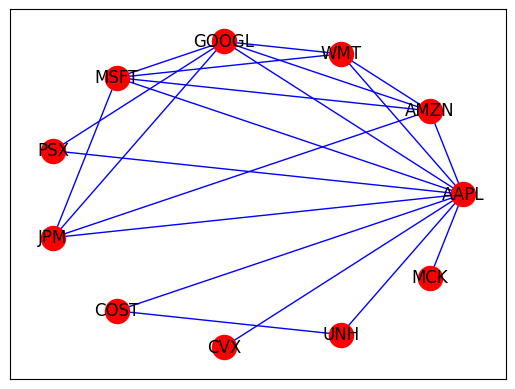

In [57]:
#!/usr/bin/env python
# coding: utf-8

# # Import Libraries

# In[1]:


import pandas as pd
# Import Libraries for Graph, GNN, and GCN

import stellargraph as sg
from stellargraph import StellarGraph

from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN


# In[2]:


# Machine Learnig related library Imports

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')


# In[3]:


# was active

data_folder = './data/yahoonewsarchive/'
# os.chdir(data_folder);
# file = data_folder + 'NEWS_YAHOO_stock_prediction.csv';
file = data_folder + 'News_Yahoo_stock.csv';


# In[4]:


df_news = pd.read_csv(file)
df_news.head()


# In[5]:


df_news = df_news[:100]


# # Approaches: Find all stock tickers in an/all article/articles
# 
# 1. Find code that does this: from internet or from previous work or from courses that you have taken online or in academia
# 2. Iterative read the article and match with stock tickers, and find all tickers. Drawback: to which tickers to match or how will you know what is a ticker? Any two to four letters Uppercase, NASDAQ AAPL
# 3. Load the article in database and then use SQL -> may not work that well unless you write some functions
# 4. NLTK, remove stop words, find all tokens, then find All Uppercase words. create a list. attach article ids to the list. Then match with the list of tockers. find common tickers between them. then create tuples with two (indicating edge) (source target weight) 

# In[6]:


# import NLTK libraries
# remove stop words using NLTK methods 
# remove all sorts of unnecessary words
# find all tokens
# Keep only All Uppercase words in a list : dictionary/map: dataframe will be ideal
# create a list/dictionary/map: dataframe will be ideal. attach article ids to the list/dataframe data.
# Create a list of all NasDAQ Tickers
# Then match with the list of NASDAQ tockers. 
# find common tickers between them. 
# then create tuples with two (indicating edge) (source target weight)
# increase weight for each article and pair when you see a match


# In[7]:


# import NLTK libraries
import nltk


# In[8]:


# remove stop words using NLTK methods 
# remove all sorts of unnecessary words
# find all tokens
# Keep only All Uppercase words in a list : dictionary/map: dataframe will be ideal

from nltk.tokenize import RegexpTokenizer

dataFrameWithOnlyCapitalWords = pd.DataFrame(columns =  ["id", "Title", "Content"]) 
for index, row in df_news.iterrows():
    # print(row[id], row['title'], row['content'])
                
    # words with capital letters in the beginning +  as much as possible
    capitalWords = RegexpTokenizer('[A-Z]+[A-Z]\w+')
    # print("\n::All Capital Words::", capitalWords.tokenize(row['content']))
    allCapitalWords = capitalWords.tokenize(row['content'])
        
    dataFrameWithOnlyCapitalWords.loc[index] = [index, row['title'], allCapitalWords]
    #break



dataFrameWithOnlyCapitalWords.head() #, dataFrameWithOnlyCapitalWords.shape


# # Create a list of all (NasDAQ) 30 stocks as per the paper
# 

# In[9]:


# Find/Create a list of NASDAQ Stocks
import os
import glob
nasdaqDataFolder = './archive/stock_market_data/nasdaq/csv'
os.chdir(nasdaqDataFolder)





# In[10]:


# Create a list of all NasDAQ Tickers

extension = "csv"
fileTypesToMerge = ""
# all_filenames = [i for i in glob.glob('*' + '*.{}'.format(extension))]
all_nasdaq_tickers = [i[:-4] for i in glob.glob('*' + fileTypesToMerge + '*.{}'.format(extension))]
nasdaq_tickers_to_process = all_nasdaq_tickers #[:10]
nasdaq_tickers_to_process


# In[11]:


nasdaq_tickers_to_process.remove('FREE')
nasdaq_tickers_to_process.remove('CBOE')
nasdaq_tickers_to_process.remove('III')
nasdaq_tickers_to_process.remove('RVNC')
sorted(nasdaq_tickers_to_process)


# In[ ]:





# In[12]:


fortune_30_tickers_to_process = [
'WMT',
'XOM',
'AAPL',
'UNH',
'MCK',
'CVS',
'AMZN',
'T',
'GM',
'F',
'ABC',
'CVX',
'CAH',
'COST',
'VZ',
'KR',
'GE',
'WBA',
'JPM',
'GOOGL',
'HD',
'BAC',
'WFC',
'BA',
'PSX',
'ANTM',
'MSFT',
'UNP',
'PCAR',
'DWDP']




# In[ ]:





# nasdaq_tickers_to_process = [
# 'WMT',
# 'XOM',
# 'AAPL',
# 'UNH',
# 'MCK',
# 'CVS',
# 'AMZN',
# 'T',
# 'GM',
# 'F',
# 'ABC',
# 'CVX',
# 'CAH',
# 'COST',
# 'VZ',
# 'KR',
# 'GE',
# 'WBA',
# # 'JPM',
# #'GOOGL',
# 'HD',
# 'BAC',
# 'WFC',
# 'BA',
# 'PSX',
# 'ANTM',
# 'MSFT',
# 'UNP',
# 'PCAR',
# 'DWDP']
# 

# # Find NASDQ Tickers in each article
# Create graph steps
# Find all edges 

# In[13]:


combinedTupleList = [];
allMatchingTickers = [];
from itertools import combinations
for index, row in dataFrameWithOnlyCapitalWords.iterrows():
    #print(index)
    #print(set(row['Content']))
    #print(set(nasdaq_tickers_to_process));    
    matchingTickers = set(set(fortune_30_tickers_to_process).intersection(set(row['Content'])))
    #print(matchingTickers)
    if len (matchingTickers) > 1:
        allTuples = list(combinations(matchingTickers, 2));
        #print(list(combinations(matchingTickers, 2)))
        
        #allMatchingTickers = set(allMatchingTickers).union(matchingTickers);
        for aTuple in allTuples:
            combinedTupleList.append(tuple(sorted(aTuple)));
            allMatchingTickers.append(aTuple[0])
            allMatchingTickers.append(aTuple[1])
            
        
    # print("*******************");
    #break
    
#combinedTupleList = list(set(combinedTupleList))
allMatchingTickers = set(allMatchingTickers)

# list(set(combinedTupleList)), len(combinedTupleList), len(set(combinedTupleList)), allMatchingTickers, len(allMatchingTickers), len(set(allMatchingTickers))
sorted(combinedTupleList), type(aTuple), type(sorted(aTuple)), allMatchingTickers


# In[14]:


#combinedTupleList[:1], set(allMatchingTickers)


# In[15]:


# calculate edge weights
from collections import Counter

tuplesWithCount = dict(Counter(combinedTupleList))
tuplesWithCount


# In[16]:


l = list(tuplesWithCount.keys())
l

#print(list(zip(*l))[0])
#print(list(zip(*l))[1])

source = list(zip(*l))[0];
target = list(zip(*l))[1];
edge_weights = tuplesWithCount.values()
source, target, edge_weights, len(source), len(target)


# In[62]:


import networkx as nx
Graph_news = nx.Graph(tuplesWithCount.keys())
nx.draw_networkx(Graph_news, pos = nx.circular_layout(Graph_news), node_color = 'r', edge_color = 'b')
#tuplesWithCount.keys()


# # Finally Create graph based on financial news

# In[17]:


import os
os.getcwd()
os.chdir('../../../../')
#os.chdir('./mcmaster/meng/747/project/')
os.getcwd()


# In[18]:


# Now create node data i.e time series to pass as part of the nodes
'''
df = pd.DataFrame();
data_file = "../../../..//archive/stock_market_data/nasdaq/nasdq-stock-price--all-merged.csv"
# stock-price--all-merged.csv"
df = pd.read_csv(data_file);
df.head()
'''

# this is the place where the new dataset starts i.e. fortune 30 companies
df = pd.DataFrame();
data_file = "per-day-fortune-30-company-stock-price-data.csv";
df = pd.read_csv("./data/" + data_file, low_memory = False);
df.head()


# In[19]:


df.index


# In[20]:


drop_cols_with_na = 1
drop_rows_with_na = 0


# In[21]:


# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html


try:
  df = df.interpolate(inplace = False)
except:
  print("An exception occurred. Operation ignored")
  exit
    
df.isnull().values.any()
df[df.isna().any(axis = 1)]  


#----



if drop_cols_with_na == 1:
    df = df.dropna(axis = 1);    
   
df, df.shape

## -- 

df.isnull().values.any()
df[df.isna().any( axis = 1 )]


## --

# df_s_transpose.index = df_s_transpose['Date']
#df.index = df.index.astype('datetime64[ns]')
df


# In[22]:


df_s =  df #[ ['Ticker', 'Date', 'Adjusted Close'] ];
df_s


# In[23]:


df_s["Date"] = df_s["Date"].astype('datetime64[ns]')
df_s = df_s.sort_values( by = 'Date', ascending = True )
df_s


# df_s_pivot = df_s.pivot_table(index = 'Ticker', columns = 'Date', values = 'Adjusted Close')
# df_s_pivot

# In[24]:


allMatchingTickers


# 
# 
# drop_rows_with_na = 0
# if drop_rows_with_na == 1:
#     df_s_transpose = df_s_transpose.dropna(axis=0);
#     #df_s_transpose["Date"] = df_s_transpose["Date"].astype('datetime64[ns]')
#     #df_s_transpose.sort_values(by='Date', ascending=False)
#     df_s_transpose.to_csv('../../../..//archive/stock_market_data/nasdaq/-na-dropped-nasdq-stock-price--all-merged.csv');
#    
# df_s_transpose.head(100)
# 
# 

# In[25]:


df_s_transpose = df_s #_pivot.T
df_s_transpose

df_s_transpose_feature = df_s_transpose.reset_index(drop = True, inplace=False)
# df_s_transpose_feature =  df_s_transpose_feature.values.tolist()
# print(df_s_transpose_feature.values.tolist())
#df_s_transpose_feature['AAPL'].values



# In[26]:


df_s_transpose_feature = df_s_transpose.set_index('Date')


# In[27]:


df_s_transpose_feature


# In[28]:


#df_s_transpose['SIMO']


# In[29]:


# df_s_transpose_feature['AAPL'].values
len(allMatchingTickers), len(set(allMatchingTickers)) #, df_s['Ticker']
#df_s_tickers = df_s['Ticker'];
#len(df_s_tickers), len(set(allMatchingTickers)), df_s_transpose.columns.unique, len(set(df_s['Ticker']))
#df_s_tickers = list(set(df_s['Ticker'])); # list(df_s_transpose.columns.unique) #
#sorted(df_s_tickers)
#for x in df_s_tickers:
 #   print(x)


# In[30]:


df_s_tickers = df_s_transpose_feature.columns
#df_s_tickers = list(set(df_s_tickers.drop('Date')))
sorted(df_s_tickers[:5])


# In[31]:


set_allMatchingTickers = set(allMatchingTickers)
df_s_tickers = fortune_30_tickers_to_process #list(set(df_s['Ticker'])); # list(df_s_transpose.columns.unique) #
node_Data_financial_news = [];

'''
for x in set_allMatchingTickers :
    # if x in df_s_tickers:
    print(x)
    node_Data_financial_news.append( df_s_transpose_feature[x].values)
'''  

node_Data_financial_news = pd.DataFrame(df_s_transpose_feature) #, index = list(allMatchingTickers)) #, index = list(set_allMatchingTickers))
#node_Data_financial_news = node_Data_financial_news.T 
node_Data_financial_news


# In[32]:


node_Data_financial_news = node_Data_financial_news.T
node_Data_financial_news


# In[33]:


node_Data_financial_news


# node_Data_financial_news#.drop(axis = 0)
# node_Data_financial_news = node_Data_financial_news.T
# node_Data_financial_news

# node_Data_financial_news = node_Data_financial_news.drop('Date')
# node_Data_financial_news

# In[34]:


financial_news_edge_data = pd.DataFrame(
    {"source": source, "target": target, "edge_feature": edge_weights}
)

financial_news_graph = StellarGraph(node_Data_financial_news, edges = financial_news_edge_data, node_type_default="corner", edge_type_default="line")
print(financial_news_graph.info())


# In[35]:


# debug code
# financial_news_graph_data,  sorted(node_Data_financial_news.columns.unique())
# [1,2] + [2, 3,4], set(source + target).difference(sorted(node_Data_financial_news.columns.unique()))


# In[36]:


# Generator
generator = FullBatchNodeGenerator(financial_news_graph, method = "gcn")


# # Machine Learning, Deep Learning, GCN, CNN

# # Train Test Split

# In[37]:


train_subjects, test_subjects = model_selection.train_test_split(
    node_Data_financial_news #, train_size = 6, test_size = 4
)
# , train_size=6, test_size=None, stratify=pearson_graph_node_data

val_subjects, test_subjects_step_2 = model_selection.train_test_split(
    test_subjects #, test_size = 2
)

#, train_size = 500, test_size = None, stratify = test_subjects


train_subjects.shape, test_subjects.shape, val_subjects.shape, test_subjects_step_2.shape


# In[38]:


# just the target variables

train_targets = train_subjects; 
val_targets = val_subjects; 
test_targets = test_subjects; 


# In[39]:


# Architecture of the Neural Network
train_subjects.index, train_targets


# In[40]:


train_gen = generator.flow(train_subjects.index, train_targets)


# In[41]:


from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow import keras

layer_sizes = [32, 32]
activations = ["relu", "relu"]

gcn = GCN(layer_sizes = layer_sizes, activations = activations, generator = generator) #, dropout = 0.5
x_inp, x_out = gcn.in_out_tensors()

# MLP -- Regression
predictions = layers.Dense(units = train_targets.shape[1], activation = "linear")(x_out)
x_out, 
x_inp, x_out


# # Models

# In[42]:


# loss functions: https://keras.io/api/losses/

model = Model(
    inputs = x_inp, outputs = predictions)

'''
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.1),
    loss=losses.MeanSquaredError(),
    metrics=["acc"],
)
'''

# REF: https://stackoverflow.com/questions/57301698/how-to-change-a-learning-rate-for-adam-in-tf2
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PolynomialDecay
train_steps = 1000
lr_fn = optimizers.schedules.PolynomialDecay(1e-3, train_steps, 1e-5, 2)


# https://keras.io/api/metrics/
model.compile(
    loss = 'mean_absolute_error', 
    optimizer = optimizers.Adam( lr_fn ),
    # metrics = ['mean_squared_error']
    metrics=['mse', 'mae', 'mape']
)

# mape: https://towardsdatascience.com/choosing-the-correct-error-metric-mape-vs-smape-5328dec53fac
model.compile( 
    loss = 'mean_absolute_error', 
    optimizer = optimizers.Adam(learning_rate = 0.015), 
    #optimizer = optimizers.Adam(lr_fn), 
    # metrics=['mean_squared_error']
    metrics=['mean_squared_error', 'mae', 'mape']
    # metrics=[
    #    metrics.MeanSquaredError(),
    #    metrics.AUC(),
    #]
)


# In[43]:


len(x_inp), predictions.shape, print(model.summary())


# In[44]:


len(val_subjects)
test_subjects_ = test_subjects[:len(val_subjects)]


# In[45]:


# hard coded size adjustments
test_subjects_ = test_subjects[:len(val_subjects)]

val_gen = generator.flow(val_subjects.index, test_subjects_)
#train_gen[1], val_gen[1]


# In[46]:


# epochs_to_test = 10
# patience_to_test = 10
data_valid = val_gen #[:1][:4];
train_gen_data = train_gen #[:1][:4];


# In[47]:


type(train_gen_data), type(data_valid), type(x_inp), type(x_out) 


# In[48]:


# https://keras.io/api/callbacks/early_stopping/
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(
    monitor = "val_mean_squared_error", 
    patience = patience_to_test, 
    restore_best_weights = True
)

history = model.fit( train_gen_data, epochs = epochs_to_test, validation_data = data_valid, verbose = 2,    
    # shuffling = true means shuffling the whole graph
    shuffle = False, callbacks = [es_callback],
)



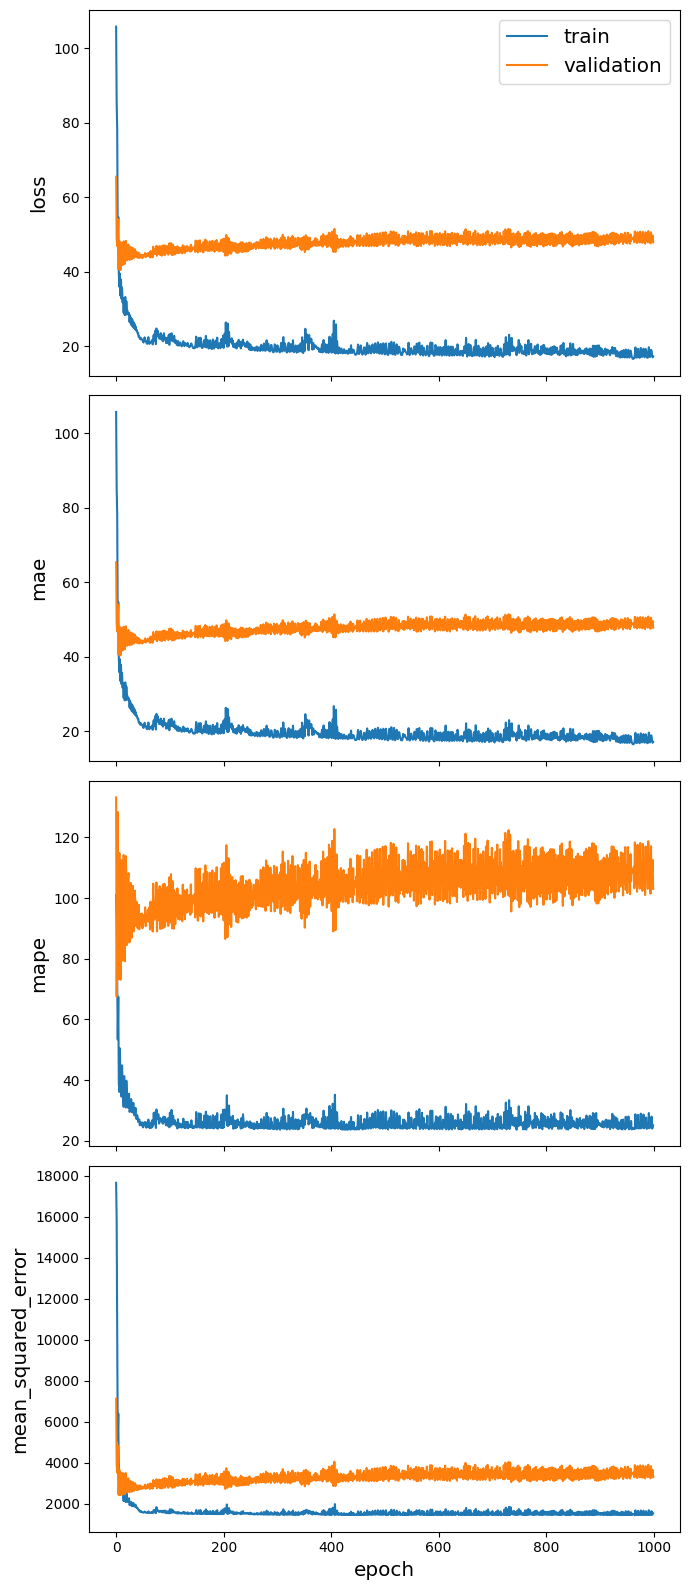

In [58]:
sg.utils.plot_history(history)

In [59]:
# [1]
val_subjects, 
test_subjects

test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))
    


# # Show the predicted prices by the Model
# 
# At this point, I still need to make sense of what GCN ( and CNN) combination + MLP is predicting. 
# I am just displaying the output. 
# It appears that price is predicted for each timestamp (day)

# In[51]:


all_nodes = node_Data_financial_news.index;
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

all_predictions, all_predictions.shape, node_Data_financial_news.shape


# In[52]:




1/1 [==============================] - 0s 43ms/step - loss: 20.7874 - mean_squared_error: 838.6087 - mae: 20.7874 - mape: 33.3571

Test Set Metrics:
	loss: 20.7874
	mean_squared_error: 838.6087
	mae: 20.7874
	mape: 33.3571
1/1 [==============================] - 0s 106ms/step


(array([[[155.81052 , 155.97379 , 157.68181 , ..., 224.25017 ,
          231.42216 , 227.3182  ],
         [ 88.66439 ,  88.6886  ,  89.245476, ...,  85.45921 ,
           88.49094 ,  86.72132 ],
         [ 83.47144 ,  83.556076,  84.4479  , ..., 130.186   ,
          134.09135 , 131.91954 ],
         ...,
         [ 53.890587,  53.905846,  54.100967, ...,  48.812195,
           50.48473 ,  49.566616],
         [ 79.27268 ,  79.34988 ,  80.17719 , ..., 122.48629 ,
          126.15381 , 124.117676],
         [ 74.57883 ,  74.58913 ,  74.99541 , ...,  68.23361 ,
           70.652725,  69.24786 ]]], dtype=float32),
 (1, 28, 753),
 (28, 753))

df_metrics = pd.DataFrame(columns=['Method', 'Loss', 'MSE', 'MAE', 'MAPE'])

temp = list()
temp.append('GCN-Causation-News');
for name, val in zip(model.metrics_names, test_metrics):    
    temp.append(val)

print(temp)
df_metrics.loc[1] = temp

import math
df_metrics_plot = df_metrics[['Loss', 'MSE', 'MAE', 'MAPE']]
df_metrics_plot['MSE'] = math.sqrt(df_metrics['MSE'])
df_metrics_plot


df_metrics_plot.plot( kind = 'bar')

In [60]:
# df_metrics = pd.DataFrame(columns=['Method', 'Loss', 'MSE', 'MAE', 'MAPE'])

temp = list()
temp.append('GCN-News');
for name, val in zip(model.metrics_names, test_metrics):    
    temp.append(val)

df_metrics.loc[4] = temp

# import math
df_metrics_plot = df_metrics[['Loss', 'MSE', 'MAE', 'MAPE']]

df_metrics_plot['MSE'] = [ math.sqrt(x) for x in df_metrics_plot['MSE']]
df_metrics_plot

C:\Users\sayed\AppData\Local\Temp\ipykernel_40556\1465589808.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metrics_plot['MSE'] = [ math.sqrt(x) for x in df_metrics_plot['MSE']]


,Loss,MSE,MAE,MAPE
1,31.898991,38.588287,31.898991,52.818108
2,24.566895,33.956233,24.566895,22.741137
3,37.756111,48.828960,37.756111,41.073765
4,20.787388,28.958741,20.787388,33.357090


<Axes: >

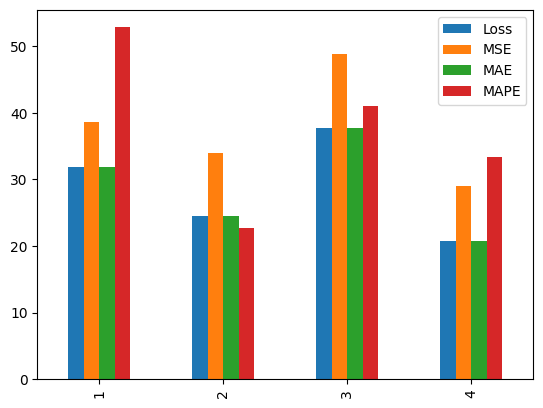

In [61]:
df_metrics_plot.plot( kind = 'bar')

To start with, I have taken ideas from the following code esp. to see what GCN is and how GCN works.

Although, it does not use any CNN. 

Node classification with Graph Convolutional Network (GCN). 

https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gcn-node-classification.html 

References:



[1] Node classification with Graph Convolutional Network (GCN). https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gcn-node-classification.html 


[2] Loading data into StellarGraph from Pandas. https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html

[3] Load Timeseries https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-numpy.html

[4] NetworkX: https://networkx.org/documentation/stable/reference/introduction.html 

[5]  StellerGraph and Networkx https://stellargraph.readthedocs.io/en/latest/demos/basics/loading-networkx.html 

[6] Select StellerGraph Algorithm : https://stellargraph.readthedocs.io/en/stable/demos/#find-a-demo-for-an-algorithm 
[link text](https://)


Learning: 
GNN/GCN/Keras
https://www.youtube.com/watch?v=0KH95BEz370


Install StellarGraph:
https://pypi.org/project/stellargraph/#install-stellargraph-using-pypi


May want to use without Stellar
https://keras.io/examples/graph/gnn_citations/

to get feature data from pandas dataframe: 
https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html


Create graph properly:
https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html    

https://stellargraph.readthedocs.io/en/v0.11.0/api.html


Graph Regression Dataset
https://paperswithcode.com/task/graph-regression/codeless

StellerGraph Reference:
https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html
https://stellargraph.readthedocs.io

GRaph CNN or similar
It has multiple GCN layers and one 1d CNN + ... this idea might help
https://stellargraph.readthedocs.io/en/stable/demos/graph-classification/dgcnn-graph-classification.html?highlight=cnn

# References -- exploring ideas on the GCN-CNN
https://ieeexplore.ieee.org/document/9149910

https://antonsruberts.github.io/graph/gcn/

This may work. As Unit GCN is created also unit tcn. This may give the opportunity to customize to product the correct output
https://github.com/lshiwjx/2s-AGCN  https://paperswithcode.com/paper/non-local-graph-convolutional-networks-for

    

# from scracth and equations
https://towardsdatascience.com/understanding-graph-convolutional-networks-for-node-classification-a2bfdb7aba7b

https://jonathan-hui.medium.com/graph-convolutional-networks-gcn-pooling-839184205692